In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import copy 
import matplotlib.pyplot as plt 
import tqdm
import ast 


In [2]:
base_dir='/Users/vayungoel/Desktop/opl/scene_maam_audioset_without_opl'
base_mode='scene'
folder_name='device_maam_audioset_without_opl/'
b_s = 256
list_val_acc = []

In [3]:
run_mode='device'

In [4]:
data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_train_all_blocks.csv")
test_data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_test_all_blocks.csv")

In [5]:
df=pd.DataFrame()
df['file_name']=test_data['file_name']
df.head()

,file_name
0,airport-barcelona-203-6122-b.wav
1,airport-barcelona-203-6122-s1.wav
2,airport-barcelona-203-6122-s2.wav
3,airport-barcelona-203-6122-s4.wav
4,airport-barcelona-203-6122-s6.wav


In [6]:
lr=0.0001

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
acc_list=[]

In [9]:
def train_ready(data,col_name):
    new_list=[]
    for i in range(len(data)):
        temp_list=[]
        x=data[col_name][i]
        tensor_string = x

# Extract the numbers part of the string
        numbers_string = tensor_string.split("[[")[1].split("]]")[0]

# Parse the string into a Python list
        tensor_list = ast.literal_eval("[" + numbers_string + "]")

# Convert the list to a numpy array
        numpy_array = np.array(tensor_list)
        list_data=list(numpy_array)
        
        new_list.append(list_data)
    return new_list

In [10]:
number_of_classes=len(list(np.unique(np.array(data[run_mode]))))
number_of_classes

6

In [11]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

198406


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [12]:
y=data[run_mode].tolist()
print(y)
label_array_train = np.array(y).reshape(-1, 1)
encoder=OneHotEncoder()
y_one_hot_encoded = encoder.fit_transform(label_array_train).toarray()
# print(len(y_one_hot_encoded))
y_one_hot_encoded

['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'a', 's2', 'a', 'a', 'a', 'a', 'a', 'a', 's1', 'a', 's3', 'a', 'a', 'a', 'a', 's2', 'a', 'a', 's3', 'a', 'a', 'a', 'c', 's1', 'a', 'a', 's1', 'a', 'a', 'a', 's2', 'a', 'a', 'a', 'c', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 's2', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 's2', 'a', 'a', 'b', 's1', 'a', 'a', 'a', 'a', 'b', 'a', 'b', 's3', 'a', 'a', 'a', 'a', 'c', 'a', 's3', 'a', 'a', 'a', 'a', 'c', 'a', 'a', 'a', 's2', 's3', 'a', 's1', 'a', 's2', 'a', 'a', 'a', 'a', 'a', 'b', 'a', 'a', 'a', 'a', 's1', 'a', 's2', 'a', 'a', 's3', 'a', 'c', 'a', 's3', 'a', 'a', 'a', 'a', 'a', 's1', 'a', 'b', 'c', 's1', 'a', 'a', 'a', 'a', 'a', 's3', 'a', 'a', 'a', 'c', 's1', 'a', 'a', 'a', 'a', 'a', 'a', 's2', 'a', 's3', 'a', 'a', 's2', 'a', 'a', 's3', 'a', 'a', 'a', 'a', 's3', 'a', 'a', 'a', 'a', 's1', 'a', 'a', 'a', 'a', 'a', 'c', 'a', 'a', 'a', 'a', 'a', 'a', 'a'

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [13]:
from collections import Counter
labels = np.argmax(y_one_hot_encoded, axis=1)

# Calculate class frequencies
class_counts = Counter(labels)
total_samples = sum(class_counts.values())

# Calculate class weights as inverse of class frequencies
class_weights = {cls: total_samples / (class_counts[cls] * len(class_counts)) for cls in range(len(class_counts))}
weights_array = np.array(list(class_weights.values()), dtype=np.float32)

In [14]:
y_test=test_data[run_mode].tolist()
label_array_test=np.array(y_test).reshape(-1,1)
encoder=OneHotEncoder()
y_test_one_hot_encoded = encoder.fit_transform(label_array_test).toarray()
y_test_one_hot_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
class_names = list(np.unique(y_test))

# Block-1

In [16]:
Block_number=1

In [17]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [18]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [20]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [21]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

198406


In [23]:
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
num_params_last_layer

1542

In [24]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [25]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [26]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [27]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 322.97batch/s, acc=0.0469, loss=1.85]


Epoch 0 validation: Cross-entropy=1.86, Accuracy=5.9%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 551.63batch/s, acc=0.082, loss=1.8]  


Epoch 1 validation: Cross-entropy=1.82, Accuracy=9.6%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 577.37batch/s, acc=0.148, loss=1.78] 


Epoch 2 validation: Cross-entropy=1.79, Accuracy=17.0%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 573.18batch/s, acc=0.219, loss=1.76]


Epoch 3 validation: Cross-entropy=1.78, Accuracy=23.7%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 330.13batch/s, acc=0.277, loss=1.74]


Epoch 4 validation: Cross-entropy=1.76, Accuracy=28.1%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 517.26batch/s, acc=0.301, loss=1.73]


Epoch 5 validation: Cross-entropy=1.75, Accuracy=30.5%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 594.10batch/s, acc=0.32, loss=1.71] 


Epoch 6 validation: Cross-entropy=1.74, Accuracy=32.7%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 610.01batch/s, acc=0.344, loss=1.7] 


Epoch 7 validation: Cross-entropy=1.73, Accuracy=35.1%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 366.33batch/s, acc=0.371, loss=1.68]


Epoch 8 validation: Cross-entropy=1.72, Accuracy=37.1%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 482.54batch/s, acc=0.371, loss=1.67]


Epoch 9 validation: Cross-entropy=1.70, Accuracy=37.6%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 386.05batch/s, acc=0.379, loss=1.66]


Epoch 10 validation: Cross-entropy=1.69, Accuracy=38.6%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 350.40batch/s, acc=0.391, loss=1.65]


Epoch 11 validation: Cross-entropy=1.68, Accuracy=38.8%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 310.06batch/s, acc=0.395, loss=1.63]


Epoch 12 validation: Cross-entropy=1.67, Accuracy=38.9%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 476.20batch/s, acc=0.379, loss=1.62]


Epoch 13 validation: Cross-entropy=1.66, Accuracy=39.0%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 371.14batch/s, acc=0.375, loss=1.61]


Epoch 14 validation: Cross-entropy=1.65, Accuracy=39.0%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 446.03batch/s, acc=0.371, loss=1.6] 


Epoch 15 validation: Cross-entropy=1.64, Accuracy=38.9%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 314.91batch/s, acc=0.379, loss=1.59]


Epoch 16 validation: Cross-entropy=1.64, Accuracy=38.8%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 591.61batch/s, acc=0.375, loss=1.58]


Epoch 17 validation: Cross-entropy=1.63, Accuracy=39.0%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 375.57batch/s, acc=0.371, loss=1.57]


Epoch 18 validation: Cross-entropy=1.62, Accuracy=38.8%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 516.86batch/s, acc=0.375, loss=1.56]


Epoch 19 validation: Cross-entropy=1.61, Accuracy=39.0%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 284.99batch/s, acc=0.383, loss=1.55]


Epoch 20 validation: Cross-entropy=1.60, Accuracy=39.0%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 556.74batch/s, acc=0.387, loss=1.54]


Epoch 21 validation: Cross-entropy=1.60, Accuracy=39.0%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 300.47batch/s, acc=0.387, loss=1.53]


Epoch 22 validation: Cross-entropy=1.59, Accuracy=39.2%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 464.04batch/s, acc=0.387, loss=1.52]


Epoch 23 validation: Cross-entropy=1.58, Accuracy=39.7%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 571.86batch/s, acc=0.387, loss=1.52]


Epoch 24 validation: Cross-entropy=1.58, Accuracy=39.8%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 238.29batch/s, acc=0.387, loss=1.51]


Epoch 25 validation: Cross-entropy=1.57, Accuracy=40.1%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 550.67batch/s, acc=0.387, loss=1.5] 


Epoch 26 validation: Cross-entropy=1.56, Accuracy=40.2%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 391.08batch/s, acc=0.391, loss=1.49]


Epoch 27 validation: Cross-entropy=1.56, Accuracy=40.4%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 562.45batch/s, acc=0.395, loss=1.48]


Epoch 28 validation: Cross-entropy=1.55, Accuracy=40.6%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 269.33batch/s, acc=0.395, loss=1.48]


Epoch 29 validation: Cross-entropy=1.55, Accuracy=40.8%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 544.94batch/s, acc=0.398, loss=1.47]


Epoch 30 validation: Cross-entropy=1.54, Accuracy=41.0%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 548.05batch/s, acc=0.398, loss=1.46]


Epoch 31 validation: Cross-entropy=1.54, Accuracy=41.2%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 336.83batch/s, acc=0.398, loss=1.46]


Epoch 32 validation: Cross-entropy=1.53, Accuracy=41.6%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 341.20batch/s, acc=0.402, loss=1.45]


Epoch 33 validation: Cross-entropy=1.53, Accuracy=41.7%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 565.72batch/s, acc=0.402, loss=1.44]


Epoch 34 validation: Cross-entropy=1.52, Accuracy=41.9%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 532.79batch/s, acc=0.406, loss=1.44]


Epoch 35 validation: Cross-entropy=1.52, Accuracy=42.2%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 310.75batch/s, acc=0.41, loss=1.43] 


Epoch 36 validation: Cross-entropy=1.51, Accuracy=42.5%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 551.63batch/s, acc=0.41, loss=1.43] 


Epoch 37 validation: Cross-entropy=1.51, Accuracy=42.7%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 348.47batch/s, acc=0.418, loss=1.42]


Epoch 38 validation: Cross-entropy=1.50, Accuracy=42.9%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 323.04batch/s, acc=0.418, loss=1.42]


Epoch 39 validation: Cross-entropy=1.50, Accuracy=43.0%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 314.15batch/s, acc=0.418, loss=1.41]


Epoch 40 validation: Cross-entropy=1.49, Accuracy=43.2%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 591.29batch/s, acc=0.426, loss=1.4] 


Epoch 41 validation: Cross-entropy=1.49, Accuracy=43.3%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 340.86batch/s, acc=0.426, loss=1.4] 


Epoch 42 validation: Cross-entropy=1.48, Accuracy=43.4%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 491.20batch/s, acc=0.426, loss=1.39]


Epoch 43 validation: Cross-entropy=1.48, Accuracy=43.8%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 509.47batch/s, acc=0.426, loss=1.39]


Epoch 44 validation: Cross-entropy=1.48, Accuracy=43.8%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 291.82batch/s, acc=0.422, loss=1.39]


Epoch 45 validation: Cross-entropy=1.47, Accuracy=43.9%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 556.22batch/s, acc=0.43, loss=1.38] 


Epoch 46 validation: Cross-entropy=1.47, Accuracy=44.2%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 559.25batch/s, acc=0.434, loss=1.38]


Epoch 47 validation: Cross-entropy=1.46, Accuracy=44.4%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 440.54batch/s, acc=0.438, loss=1.37]


Epoch 48 validation: Cross-entropy=1.46, Accuracy=44.7%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 282.46batch/s, acc=0.441, loss=1.37]


Epoch 49 validation: Cross-entropy=1.46, Accuracy=44.8%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 547.39batch/s, acc=0.441, loss=1.36]


Epoch 50 validation: Cross-entropy=1.45, Accuracy=44.9%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 394.82batch/s, acc=0.441, loss=1.36]


Epoch 51 validation: Cross-entropy=1.45, Accuracy=45.1%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 513.77batch/s, acc=0.445, loss=1.35]


Epoch 52 validation: Cross-entropy=1.45, Accuracy=45.3%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 296.39batch/s, acc=0.449, loss=1.35]


Epoch 53 validation: Cross-entropy=1.44, Accuracy=45.4%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 590.82batch/s, acc=0.453, loss=1.35]


Epoch 54 validation: Cross-entropy=1.44, Accuracy=45.8%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 311.38batch/s, acc=0.453, loss=1.34]


Epoch 55 validation: Cross-entropy=1.44, Accuracy=46.1%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 598.43batch/s, acc=0.461, loss=1.34]


Epoch 56 validation: Cross-entropy=1.43, Accuracy=46.2%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 320.35batch/s, acc=0.461, loss=1.33]


Epoch 57 validation: Cross-entropy=1.43, Accuracy=46.2%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 534.63batch/s, acc=0.465, loss=1.33]


Epoch 58 validation: Cross-entropy=1.43, Accuracy=46.3%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 287.87batch/s, acc=0.461, loss=1.33]


Epoch 59 validation: Cross-entropy=1.42, Accuracy=46.4%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 527.72batch/s, acc=0.465, loss=1.32]


Epoch 60 validation: Cross-entropy=1.42, Accuracy=46.5%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 576.60batch/s, acc=0.469, loss=1.32]


Epoch 61 validation: Cross-entropy=1.42, Accuracy=46.7%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 302.96batch/s, acc=0.469, loss=1.32]


Epoch 62 validation: Cross-entropy=1.42, Accuracy=46.9%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 585.50batch/s, acc=0.473, loss=1.31]


Epoch 63 validation: Cross-entropy=1.41, Accuracy=47.0%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 285.17batch/s, acc=0.477, loss=1.31]


Epoch 64 validation: Cross-entropy=1.41, Accuracy=47.2%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 591.54batch/s, acc=0.477, loss=1.31]


Epoch 65 validation: Cross-entropy=1.41, Accuracy=47.4%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 286.08batch/s, acc=0.477, loss=1.3] 


Epoch 66 validation: Cross-entropy=1.41, Accuracy=47.5%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 559.81batch/s, acc=0.48, loss=1.3]  


Epoch 67 validation: Cross-entropy=1.40, Accuracy=47.5%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 532.88batch/s, acc=0.484, loss=1.3] 


Epoch 68 validation: Cross-entropy=1.40, Accuracy=47.7%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 295.06batch/s, acc=0.484, loss=1.29]


Epoch 69 validation: Cross-entropy=1.40, Accuracy=47.9%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 608.02batch/s, acc=0.488, loss=1.29]


Epoch 70 validation: Cross-entropy=1.40, Accuracy=48.0%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 417.89batch/s, acc=0.488, loss=1.29]


Epoch 71 validation: Cross-entropy=1.39, Accuracy=48.1%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 417.64batch/s, acc=0.488, loss=1.28]


Epoch 72 validation: Cross-entropy=1.39, Accuracy=48.2%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 329.19batch/s, acc=0.488, loss=1.28]


Epoch 73 validation: Cross-entropy=1.39, Accuracy=48.4%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 581.82batch/s, acc=0.488, loss=1.28]


Epoch 74 validation: Cross-entropy=1.39, Accuracy=48.5%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 614.58batch/s, acc=0.484, loss=1.28]


Epoch 75 validation: Cross-entropy=1.38, Accuracy=48.6%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 310.86batch/s, acc=0.484, loss=1.27]


Epoch 76 validation: Cross-entropy=1.38, Accuracy=48.8%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 576.11batch/s, acc=0.48, loss=1.27] 


Epoch 77 validation: Cross-entropy=1.38, Accuracy=48.9%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 314.35batch/s, acc=0.48, loss=1.27] 


Epoch 78 validation: Cross-entropy=1.38, Accuracy=49.2%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 499.09batch/s, acc=0.48, loss=1.27] 


Epoch 79 validation: Cross-entropy=1.37, Accuracy=49.2%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 549.05batch/s, acc=0.484, loss=1.26]


Epoch 80 validation: Cross-entropy=1.37, Accuracy=49.3%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 355.34batch/s, acc=0.48, loss=1.26] 


Epoch 81 validation: Cross-entropy=1.37, Accuracy=49.6%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 459.17batch/s, acc=0.48, loss=1.26] 


Epoch 82 validation: Cross-entropy=1.37, Accuracy=49.7%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 341.59batch/s, acc=0.48, loss=1.26] 


Epoch 83 validation: Cross-entropy=1.37, Accuracy=49.8%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 482.59batch/s, acc=0.484, loss=1.25]


Epoch 84 validation: Cross-entropy=1.36, Accuracy=49.9%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 566.47batch/s, acc=0.488, loss=1.25]


Epoch 85 validation: Cross-entropy=1.36, Accuracy=49.9%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 595.40batch/s, acc=0.488, loss=1.25]


Epoch 86 validation: Cross-entropy=1.36, Accuracy=50.1%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 249.19batch/s, acc=0.488, loss=1.25]


Epoch 87 validation: Cross-entropy=1.36, Accuracy=50.1%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 598.89batch/s, acc=0.488, loss=1.24]


Epoch 88 validation: Cross-entropy=1.36, Accuracy=50.2%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 575.84batch/s, acc=0.488, loss=1.24]


Epoch 89 validation: Cross-entropy=1.35, Accuracy=50.2%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 349.70batch/s, acc=0.488, loss=1.24]


Epoch 90 validation: Cross-entropy=1.35, Accuracy=50.3%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 472.98batch/s, acc=0.492, loss=1.24]


Epoch 91 validation: Cross-entropy=1.35, Accuracy=50.4%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 383.35batch/s, acc=0.492, loss=1.24]


Epoch 92 validation: Cross-entropy=1.35, Accuracy=50.6%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 447.66batch/s, acc=0.488, loss=1.23]


Epoch 93 validation: Cross-entropy=1.35, Accuracy=50.8%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 556.20batch/s, acc=0.488, loss=1.23]


Epoch 94 validation: Cross-entropy=1.34, Accuracy=50.9%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 594.03batch/s, acc=0.488, loss=1.23]


Epoch 95 validation: Cross-entropy=1.34, Accuracy=51.1%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 300.56batch/s, acc=0.484, loss=1.23]


Epoch 96 validation: Cross-entropy=1.34, Accuracy=51.1%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 531.87batch/s, acc=0.484, loss=1.23]


Epoch 97 validation: Cross-entropy=1.34, Accuracy=51.0%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 555.66batch/s, acc=0.488, loss=1.22]


Epoch 98 validation: Cross-entropy=1.34, Accuracy=51.1%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 307.61batch/s, acc=0.488, loss=1.22]


Epoch 99 validation: Cross-entropy=1.34, Accuracy=51.2%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 479.26batch/s, acc=0.488, loss=1.22]


Epoch 100 validation: Cross-entropy=1.33, Accuracy=51.4%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 605.34batch/s, acc=0.496, loss=1.22]


Epoch 101 validation: Cross-entropy=1.33, Accuracy=51.5%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 395.43batch/s, acc=0.496, loss=1.22]


Epoch 102 validation: Cross-entropy=1.33, Accuracy=51.7%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 413.12batch/s, acc=0.496, loss=1.21]


Epoch 103 validation: Cross-entropy=1.33, Accuracy=51.7%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 547.98batch/s, acc=0.5, loss=1.21]  


Epoch 104 validation: Cross-entropy=1.33, Accuracy=51.7%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 575.01batch/s, acc=0.5, loss=1.21]  


Epoch 105 validation: Cross-entropy=1.33, Accuracy=51.8%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 333.87batch/s, acc=0.504, loss=1.21]


Epoch 106 validation: Cross-entropy=1.32, Accuracy=51.9%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 578.27batch/s, acc=0.504, loss=1.21]


Epoch 107 validation: Cross-entropy=1.32, Accuracy=52.1%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 583.95batch/s, acc=0.504, loss=1.21]


Epoch 108 validation: Cross-entropy=1.32, Accuracy=52.2%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 331.05batch/s, acc=0.504, loss=1.2] 


Epoch 109 validation: Cross-entropy=1.32, Accuracy=52.3%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 600.76batch/s, acc=0.504, loss=1.2] 


Epoch 110 validation: Cross-entropy=1.32, Accuracy=52.2%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 441.43batch/s, acc=0.504, loss=1.2] 


Epoch 111 validation: Cross-entropy=1.32, Accuracy=52.3%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 405.45batch/s, acc=0.508, loss=1.2] 


Epoch 112 validation: Cross-entropy=1.32, Accuracy=52.3%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 588.91batch/s, acc=0.508, loss=1.2] 


Epoch 113 validation: Cross-entropy=1.31, Accuracy=52.3%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 322.64batch/s, acc=0.512, loss=1.2] 


Epoch 114 validation: Cross-entropy=1.31, Accuracy=52.3%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 562.00batch/s, acc=0.512, loss=1.19]


Epoch 115 validation: Cross-entropy=1.31, Accuracy=52.5%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 338.33batch/s, acc=0.523, loss=1.19]


Epoch 116 validation: Cross-entropy=1.31, Accuracy=52.6%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 503.41batch/s, acc=0.527, loss=1.19]


Epoch 117 validation: Cross-entropy=1.31, Accuracy=52.7%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 582.31batch/s, acc=0.531, loss=1.19]


Epoch 118 validation: Cross-entropy=1.31, Accuracy=52.8%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 305.25batch/s, acc=0.531, loss=1.19]


Epoch 119 validation: Cross-entropy=1.31, Accuracy=52.9%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 599.73batch/s, acc=0.527, loss=1.19]


Epoch 120 validation: Cross-entropy=1.30, Accuracy=53.0%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 528.90batch/s, acc=0.527, loss=1.18]


Epoch 121 validation: Cross-entropy=1.30, Accuracy=53.1%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 301.04batch/s, acc=0.527, loss=1.18]


Epoch 122 validation: Cross-entropy=1.30, Accuracy=53.1%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 529.16batch/s, acc=0.527, loss=1.18]


Epoch 123 validation: Cross-entropy=1.30, Accuracy=53.0%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 315.67batch/s, acc=0.527, loss=1.18]


Epoch 124 validation: Cross-entropy=1.30, Accuracy=53.0%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 484.11batch/s, acc=0.527, loss=1.18]


Epoch 125 validation: Cross-entropy=1.30, Accuracy=53.1%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 386.77batch/s, acc=0.535, loss=1.18]


Epoch 126 validation: Cross-entropy=1.30, Accuracy=53.2%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 549.37batch/s, acc=0.535, loss=1.18]


Epoch 127 validation: Cross-entropy=1.30, Accuracy=53.3%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 310.86batch/s, acc=0.535, loss=1.17]


Epoch 128 validation: Cross-entropy=1.29, Accuracy=53.3%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 564.41batch/s, acc=0.535, loss=1.17]


Epoch 129 validation: Cross-entropy=1.29, Accuracy=53.3%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 574.78batch/s, acc=0.535, loss=1.17]


Epoch 130 validation: Cross-entropy=1.29, Accuracy=53.4%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 389.84batch/s, acc=0.535, loss=1.17]


Epoch 131 validation: Cross-entropy=1.29, Accuracy=53.4%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 410.26batch/s, acc=0.531, loss=1.17]


Epoch 132 validation: Cross-entropy=1.29, Accuracy=53.4%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 586.87batch/s, acc=0.531, loss=1.17]


Epoch 133 validation: Cross-entropy=1.29, Accuracy=53.3%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 558.22batch/s, acc=0.539, loss=1.17]


Epoch 134 validation: Cross-entropy=1.29, Accuracy=53.4%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 369.53batch/s, acc=0.543, loss=1.17]


Epoch 135 validation: Cross-entropy=1.29, Accuracy=53.4%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 469.02batch/s, acc=0.543, loss=1.16]


Epoch 136 validation: Cross-entropy=1.29, Accuracy=53.4%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 335.22batch/s, acc=0.543, loss=1.16]


Epoch 137 validation: Cross-entropy=1.28, Accuracy=53.4%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 548.16batch/s, acc=0.543, loss=1.16]


Epoch 138 validation: Cross-entropy=1.28, Accuracy=53.3%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 583.19batch/s, acc=0.543, loss=1.16]


Epoch 139 validation: Cross-entropy=1.28, Accuracy=53.3%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 319.13batch/s, acc=0.547, loss=1.16]


Epoch 140 validation: Cross-entropy=1.28, Accuracy=53.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 571.89batch/s, acc=0.547, loss=1.16]


Epoch 141 validation: Cross-entropy=1.28, Accuracy=53.5%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 465.63batch/s, acc=0.547, loss=1.16]


Epoch 142 validation: Cross-entropy=1.28, Accuracy=53.4%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 374.65batch/s, acc=0.547, loss=1.16]


Epoch 143 validation: Cross-entropy=1.28, Accuracy=53.4%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 616.22batch/s, acc=0.547, loss=1.16]


Epoch 144 validation: Cross-entropy=1.28, Accuracy=53.5%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 402.41batch/s, acc=0.551, loss=1.15]


Epoch 145 validation: Cross-entropy=1.28, Accuracy=53.6%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 515.77batch/s, acc=0.551, loss=1.15]


Epoch 146 validation: Cross-entropy=1.27, Accuracy=53.5%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 573.74batch/s, acc=0.551, loss=1.15]


Epoch 147 validation: Cross-entropy=1.27, Accuracy=53.5%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 284.60batch/s, acc=0.551, loss=1.15]


Epoch 148 validation: Cross-entropy=1.27, Accuracy=53.6%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 570.16batch/s, acc=0.551, loss=1.15]


Epoch 149 validation: Cross-entropy=1.27, Accuracy=53.6%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 398.77batch/s, acc=0.547, loss=1.15]


Epoch 150 validation: Cross-entropy=1.27, Accuracy=53.6%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 484.85batch/s, acc=0.547, loss=1.15]


Epoch 151 validation: Cross-entropy=1.27, Accuracy=53.6%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 590.03batch/s, acc=0.555, loss=1.15]


Epoch 152 validation: Cross-entropy=1.27, Accuracy=53.6%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 307.17batch/s, acc=0.555, loss=1.15]


Epoch 153 validation: Cross-entropy=1.27, Accuracy=53.6%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 583.78batch/s, acc=0.555, loss=1.14]


Epoch 154 validation: Cross-entropy=1.27, Accuracy=53.6%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 629.27batch/s, acc=0.559, loss=1.14]


Epoch 155 validation: Cross-entropy=1.27, Accuracy=53.7%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 312.49batch/s, acc=0.559, loss=1.14]


Epoch 156 validation: Cross-entropy=1.26, Accuracy=53.8%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 615.71batch/s, acc=0.559, loss=1.14]


Epoch 157 validation: Cross-entropy=1.26, Accuracy=53.7%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 613.26batch/s, acc=0.555, loss=1.14]


Epoch 158 validation: Cross-entropy=1.26, Accuracy=53.6%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 308.29batch/s, acc=0.555, loss=1.14]


Epoch 159 validation: Cross-entropy=1.26, Accuracy=53.6%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 594.24batch/s, acc=0.555, loss=1.14]


Epoch 160 validation: Cross-entropy=1.26, Accuracy=53.6%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 626.96batch/s, acc=0.551, loss=1.14]


Epoch 161 validation: Cross-entropy=1.26, Accuracy=53.7%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 354.82batch/s, acc=0.551, loss=1.14]


Epoch 162 validation: Cross-entropy=1.26, Accuracy=53.7%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 348.99batch/s, acc=0.551, loss=1.14]


Epoch 163 validation: Cross-entropy=1.26, Accuracy=53.8%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 540.36batch/s, acc=0.551, loss=1.14]


Epoch 164 validation: Cross-entropy=1.26, Accuracy=53.8%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 562.13batch/s, acc=0.551, loss=1.13]


Epoch 165 validation: Cross-entropy=1.26, Accuracy=53.8%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 305.44batch/s, acc=0.551, loss=1.13]


Epoch 166 validation: Cross-entropy=1.26, Accuracy=54.0%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 615.81batch/s, acc=0.551, loss=1.13]


Epoch 167 validation: Cross-entropy=1.26, Accuracy=54.0%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 325.77batch/s, acc=0.551, loss=1.13]


Epoch 168 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 590.60batch/s, acc=0.551, loss=1.13]


Epoch 169 validation: Cross-entropy=1.25, Accuracy=53.9%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 480.00batch/s, acc=0.551, loss=1.13]


Epoch 170 validation: Cross-entropy=1.25, Accuracy=53.9%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 392.99batch/s, acc=0.551, loss=1.13]


Epoch 171 validation: Cross-entropy=1.25, Accuracy=53.9%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 306.62batch/s, acc=0.551, loss=1.13]


Epoch 172 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 569.63batch/s, acc=0.551, loss=1.13]


Epoch 173 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 555.45batch/s, acc=0.551, loss=1.13]


Epoch 174 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 300.91batch/s, acc=0.551, loss=1.13]


Epoch 175 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 582.21batch/s, acc=0.555, loss=1.12]


Epoch 176 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 582.93batch/s, acc=0.555, loss=1.12]


Epoch 177 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 326.95batch/s, acc=0.555, loss=1.12]


Epoch 178 validation: Cross-entropy=1.25, Accuracy=53.9%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 510.53batch/s, acc=0.559, loss=1.12]


Epoch 179 validation: Cross-entropy=1.25, Accuracy=54.0%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 596.69batch/s, acc=0.559, loss=1.12]


Epoch 180 validation: Cross-entropy=1.24, Accuracy=54.0%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 570.37batch/s, acc=0.559, loss=1.12]


Epoch 181 validation: Cross-entropy=1.24, Accuracy=54.0%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 294.60batch/s, acc=0.559, loss=1.12]


Epoch 182 validation: Cross-entropy=1.24, Accuracy=54.0%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 352.61batch/s, acc=0.559, loss=1.12]


Epoch 183 validation: Cross-entropy=1.24, Accuracy=54.0%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 520.00batch/s, acc=0.555, loss=1.12]


Epoch 184 validation: Cross-entropy=1.24, Accuracy=54.0%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 566.49batch/s, acc=0.555, loss=1.12]


Epoch 185 validation: Cross-entropy=1.24, Accuracy=54.1%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 301.28batch/s, acc=0.555, loss=1.12]


Epoch 186 validation: Cross-entropy=1.24, Accuracy=54.1%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 527.27batch/s, acc=0.555, loss=1.12]


Epoch 187 validation: Cross-entropy=1.24, Accuracy=54.1%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 581.47batch/s, acc=0.555, loss=1.12]


Epoch 188 validation: Cross-entropy=1.24, Accuracy=54.1%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 302.13batch/s, acc=0.555, loss=1.11]


Epoch 189 validation: Cross-entropy=1.24, Accuracy=54.2%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 526.05batch/s, acc=0.555, loss=1.11]


Epoch 190 validation: Cross-entropy=1.24, Accuracy=54.1%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 564.36batch/s, acc=0.555, loss=1.11]


Epoch 191 validation: Cross-entropy=1.24, Accuracy=54.1%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 373.22batch/s, acc=0.555, loss=1.11]


Epoch 192 validation: Cross-entropy=1.24, Accuracy=54.0%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 568.58batch/s, acc=0.555, loss=1.11]


Epoch 193 validation: Cross-entropy=1.24, Accuracy=54.1%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 512.47batch/s, acc=0.555, loss=1.11]


Epoch 194 validation: Cross-entropy=1.23, Accuracy=54.1%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 259.22batch/s, acc=0.555, loss=1.11]


Epoch 195 validation: Cross-entropy=1.23, Accuracy=54.2%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 542.07batch/s, acc=0.555, loss=1.11]


Epoch 196 validation: Cross-entropy=1.23, Accuracy=54.1%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 557.14batch/s, acc=0.555, loss=1.11]


Epoch 197 validation: Cross-entropy=1.23, Accuracy=54.2%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 317.44batch/s, acc=0.555, loss=1.11]


Epoch 198 validation: Cross-entropy=1.23, Accuracy=54.2%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 516.98batch/s, acc=0.559, loss=1.11]


Epoch 199 validation: Cross-entropy=1.23, Accuracy=54.2%


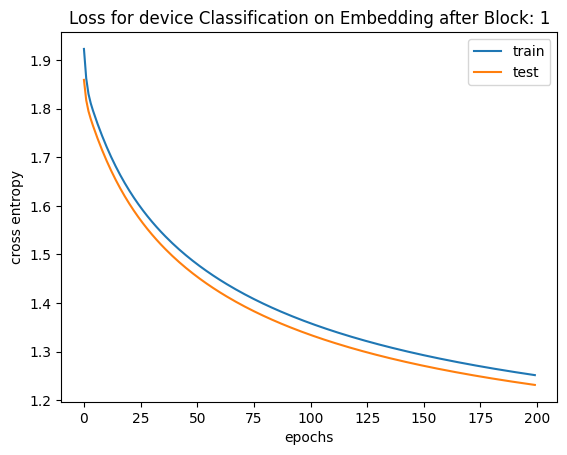

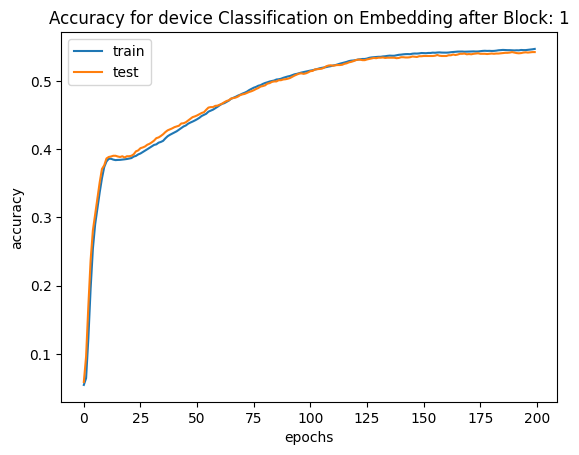

In [28]:
n_epochs = 200
batch_size = 256
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [29]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [30]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [31]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [32]:
X_test=train_ready(test_data,col_name)

In [33]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

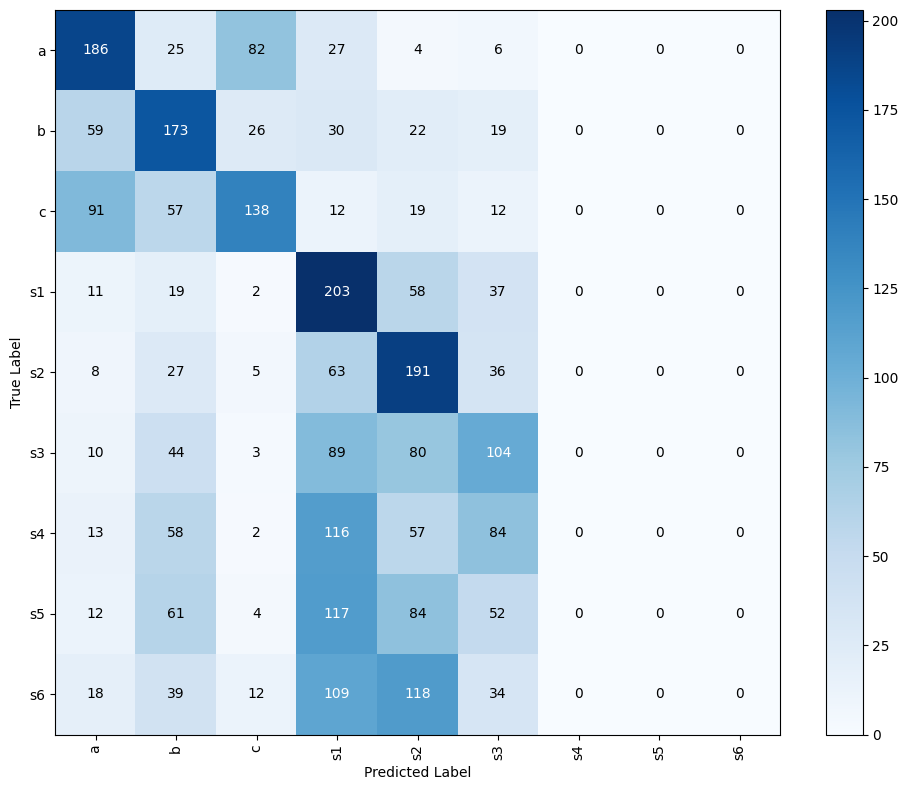

Accuracy: 0.3352


In [34]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-2

In [35]:
Block_number=2

In [36]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [37]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [39]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [40]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [41]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [42]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [43]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [44]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [45]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 544.13batch/s, acc=0.0781, loss=1.98]


Epoch 0 validation: Cross-entropy=1.89, Accuracy=7.7%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 476.00batch/s, acc=0.125, loss=1.91] 


Epoch 1 validation: Cross-entropy=1.83, Accuracy=14.7%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 405.99batch/s, acc=0.164, loss=1.87]


Epoch 2 validation: Cross-entropy=1.79, Accuracy=16.6%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 597.43batch/s, acc=0.164, loss=1.84]


Epoch 3 validation: Cross-entropy=1.76, Accuracy=17.7%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 596.37batch/s, acc=0.18, loss=1.81] 


Epoch 4 validation: Cross-entropy=1.74, Accuracy=19.4%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 379.25batch/s, acc=0.203, loss=1.79]


Epoch 5 validation: Cross-entropy=1.72, Accuracy=21.6%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 423.65batch/s, acc=0.211, loss=1.76]


Epoch 6 validation: Cross-entropy=1.70, Accuracy=23.7%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 609.44batch/s, acc=0.238, loss=1.74]


Epoch 7 validation: Cross-entropy=1.68, Accuracy=26.7%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 626.91batch/s, acc=0.262, loss=1.72]


Epoch 8 validation: Cross-entropy=1.66, Accuracy=28.5%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 615.03batch/s, acc=0.273, loss=1.69]


Epoch 9 validation: Cross-entropy=1.64, Accuracy=30.3%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 609.35batch/s, acc=0.281, loss=1.67]


Epoch 10 validation: Cross-entropy=1.62, Accuracy=32.4%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 495.81batch/s, acc=0.309, loss=1.65]


Epoch 11 validation: Cross-entropy=1.61, Accuracy=34.3%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 488.30batch/s, acc=0.34, loss=1.63] 


Epoch 12 validation: Cross-entropy=1.59, Accuracy=36.0%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 590.72batch/s, acc=0.359, loss=1.62]


Epoch 13 validation: Cross-entropy=1.57, Accuracy=37.2%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 450.59batch/s, acc=0.363, loss=1.6] 


Epoch 14 validation: Cross-entropy=1.56, Accuracy=38.3%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 511.08batch/s, acc=0.363, loss=1.58]


Epoch 15 validation: Cross-entropy=1.54, Accuracy=39.1%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 508.13batch/s, acc=0.375, loss=1.56]


Epoch 16 validation: Cross-entropy=1.53, Accuracy=39.9%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 453.06batch/s, acc=0.383, loss=1.55]


Epoch 17 validation: Cross-entropy=1.52, Accuracy=40.6%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 527.96batch/s, acc=0.395, loss=1.53]


Epoch 18 validation: Cross-entropy=1.51, Accuracy=41.5%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 353.01batch/s, acc=0.406, loss=1.52]


Epoch 19 validation: Cross-entropy=1.49, Accuracy=42.2%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 559.82batch/s, acc=0.418, loss=1.5] 


Epoch 20 validation: Cross-entropy=1.48, Accuracy=42.8%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 405.66batch/s, acc=0.41, loss=1.49] 


Epoch 21 validation: Cross-entropy=1.47, Accuracy=43.6%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 477.40batch/s, acc=0.41, loss=1.48] 


Epoch 22 validation: Cross-entropy=1.46, Accuracy=44.4%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 508.62batch/s, acc=0.426, loss=1.47]


Epoch 23 validation: Cross-entropy=1.45, Accuracy=44.5%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 492.65batch/s, acc=0.434, loss=1.45]


Epoch 24 validation: Cross-entropy=1.44, Accuracy=45.0%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 479.51batch/s, acc=0.438, loss=1.44]


Epoch 25 validation: Cross-entropy=1.43, Accuracy=45.5%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 510.79batch/s, acc=0.441, loss=1.43]


Epoch 26 validation: Cross-entropy=1.42, Accuracy=45.5%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 445.32batch/s, acc=0.441, loss=1.42]


Epoch 27 validation: Cross-entropy=1.41, Accuracy=45.8%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 394.23batch/s, acc=0.445, loss=1.41]


Epoch 28 validation: Cross-entropy=1.40, Accuracy=46.2%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 546.84batch/s, acc=0.445, loss=1.4] 


Epoch 29 validation: Cross-entropy=1.39, Accuracy=46.4%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 417.40batch/s, acc=0.445, loss=1.39]


Epoch 30 validation: Cross-entropy=1.39, Accuracy=46.6%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 567.14batch/s, acc=0.445, loss=1.38]


Epoch 31 validation: Cross-entropy=1.38, Accuracy=46.7%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 500.64batch/s, acc=0.457, loss=1.37]


Epoch 32 validation: Cross-entropy=1.37, Accuracy=46.9%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 472.82batch/s, acc=0.457, loss=1.36]


Epoch 33 validation: Cross-entropy=1.36, Accuracy=47.1%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 482.57batch/s, acc=0.457, loss=1.35]


Epoch 34 validation: Cross-entropy=1.35, Accuracy=47.2%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 505.44batch/s, acc=0.461, loss=1.34]


Epoch 35 validation: Cross-entropy=1.35, Accuracy=47.4%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 626.45batch/s, acc=0.461, loss=1.34]


Epoch 36 validation: Cross-entropy=1.34, Accuracy=47.7%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 420.32batch/s, acc=0.461, loss=1.33]


Epoch 37 validation: Cross-entropy=1.33, Accuracy=47.9%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 623.02batch/s, acc=0.465, loss=1.32]


Epoch 38 validation: Cross-entropy=1.33, Accuracy=48.2%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 386.13batch/s, acc=0.469, loss=1.31]


Epoch 39 validation: Cross-entropy=1.32, Accuracy=48.7%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 435.82batch/s, acc=0.465, loss=1.31]


Epoch 40 validation: Cross-entropy=1.32, Accuracy=48.9%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 395.63batch/s, acc=0.469, loss=1.3] 


Epoch 41 validation: Cross-entropy=1.31, Accuracy=49.1%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 632.43batch/s, acc=0.469, loss=1.29]


Epoch 42 validation: Cross-entropy=1.30, Accuracy=49.3%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 393.49batch/s, acc=0.48, loss=1.29] 


Epoch 43 validation: Cross-entropy=1.30, Accuracy=49.5%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 619.73batch/s, acc=0.48, loss=1.28] 


Epoch 44 validation: Cross-entropy=1.29, Accuracy=49.7%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 391.22batch/s, acc=0.488, loss=1.27]


Epoch 45 validation: Cross-entropy=1.29, Accuracy=49.9%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 621.64batch/s, acc=0.488, loss=1.27]


Epoch 46 validation: Cross-entropy=1.28, Accuracy=50.0%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 365.19batch/s, acc=0.488, loss=1.26]


Epoch 47 validation: Cross-entropy=1.28, Accuracy=50.0%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 599.44batch/s, acc=0.488, loss=1.25]


Epoch 48 validation: Cross-entropy=1.27, Accuracy=50.0%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 365.38batch/s, acc=0.492, loss=1.25]


Epoch 49 validation: Cross-entropy=1.27, Accuracy=50.1%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 606.35batch/s, acc=0.492, loss=1.24]


Epoch 50 validation: Cross-entropy=1.26, Accuracy=50.2%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 372.60batch/s, acc=0.496, loss=1.24]


Epoch 51 validation: Cross-entropy=1.26, Accuracy=50.3%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 604.91batch/s, acc=0.5, loss=1.23]  


Epoch 52 validation: Cross-entropy=1.25, Accuracy=50.3%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 372.53batch/s, acc=0.5, loss=1.23]  


Epoch 53 validation: Cross-entropy=1.25, Accuracy=50.3%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 562.28batch/s, acc=0.5, loss=1.22]  


Epoch 54 validation: Cross-entropy=1.24, Accuracy=50.3%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 435.63batch/s, acc=0.5, loss=1.22]  


Epoch 55 validation: Cross-entropy=1.24, Accuracy=50.4%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 591.02batch/s, acc=0.5, loss=1.21]  


Epoch 56 validation: Cross-entropy=1.24, Accuracy=50.4%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 339.29batch/s, acc=0.5, loss=1.21]  


Epoch 57 validation: Cross-entropy=1.23, Accuracy=50.5%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 568.62batch/s, acc=0.5, loss=1.2]   


Epoch 58 validation: Cross-entropy=1.23, Accuracy=50.6%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 395.99batch/s, acc=0.504, loss=1.2] 


Epoch 59 validation: Cross-entropy=1.22, Accuracy=50.6%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 440.29batch/s, acc=0.504, loss=1.19]


Epoch 60 validation: Cross-entropy=1.22, Accuracy=50.6%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 404.55batch/s, acc=0.504, loss=1.19]


Epoch 61 validation: Cross-entropy=1.22, Accuracy=50.8%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 618.50batch/s, acc=0.504, loss=1.19]


Epoch 62 validation: Cross-entropy=1.21, Accuracy=50.8%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 384.87batch/s, acc=0.504, loss=1.18]


Epoch 63 validation: Cross-entropy=1.21, Accuracy=50.8%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 617.09batch/s, acc=0.504, loss=1.18]


Epoch 64 validation: Cross-entropy=1.21, Accuracy=50.8%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 391.49batch/s, acc=0.5, loss=1.17]  


Epoch 65 validation: Cross-entropy=1.20, Accuracy=50.9%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 613.69batch/s, acc=0.5, loss=1.17]  


Epoch 66 validation: Cross-entropy=1.20, Accuracy=50.9%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 379.03batch/s, acc=0.5, loss=1.17]  


Epoch 67 validation: Cross-entropy=1.20, Accuracy=51.1%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 601.09batch/s, acc=0.5, loss=1.16]  


Epoch 68 validation: Cross-entropy=1.19, Accuracy=51.2%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 392.05batch/s, acc=0.5, loss=1.16]  


Epoch 69 validation: Cross-entropy=1.19, Accuracy=51.1%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 616.31batch/s, acc=0.5, loss=1.15]  


Epoch 70 validation: Cross-entropy=1.19, Accuracy=51.2%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 386.27batch/s, acc=0.504, loss=1.15]


Epoch 71 validation: Cross-entropy=1.18, Accuracy=51.2%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 612.65batch/s, acc=0.504, loss=1.15]


Epoch 72 validation: Cross-entropy=1.18, Accuracy=51.3%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 388.49batch/s, acc=0.504, loss=1.14]


Epoch 73 validation: Cross-entropy=1.18, Accuracy=51.5%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 631.91batch/s, acc=0.512, loss=1.14]


Epoch 74 validation: Cross-entropy=1.17, Accuracy=51.5%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 383.01batch/s, acc=0.516, loss=1.14]


Epoch 75 validation: Cross-entropy=1.17, Accuracy=51.7%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 624.62batch/s, acc=0.516, loss=1.13]


Epoch 76 validation: Cross-entropy=1.17, Accuracy=51.9%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 389.14batch/s, acc=0.516, loss=1.13]


Epoch 77 validation: Cross-entropy=1.17, Accuracy=52.0%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 615.40batch/s, acc=0.512, loss=1.13]


Epoch 78 validation: Cross-entropy=1.16, Accuracy=52.1%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 387.20batch/s, acc=0.512, loss=1.13]


Epoch 79 validation: Cross-entropy=1.16, Accuracy=52.1%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 419.93batch/s, acc=0.512, loss=1.12]


Epoch 80 validation: Cross-entropy=1.16, Accuracy=52.3%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 423.56batch/s, acc=0.516, loss=1.12]


Epoch 81 validation: Cross-entropy=1.16, Accuracy=52.4%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 483.29batch/s, acc=0.516, loss=1.12]


Epoch 82 validation: Cross-entropy=1.15, Accuracy=52.5%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 482.87batch/s, acc=0.516, loss=1.11]


Epoch 83 validation: Cross-entropy=1.15, Accuracy=52.3%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 492.21batch/s, acc=0.516, loss=1.11]


Epoch 84 validation: Cross-entropy=1.15, Accuracy=52.3%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 588.68batch/s, acc=0.516, loss=1.11]


Epoch 85 validation: Cross-entropy=1.15, Accuracy=52.3%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 406.21batch/s, acc=0.516, loss=1.11]


Epoch 86 validation: Cross-entropy=1.14, Accuracy=52.4%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 630.78batch/s, acc=0.512, loss=1.1] 


Epoch 87 validation: Cross-entropy=1.14, Accuracy=52.6%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 372.53batch/s, acc=0.512, loss=1.1] 


Epoch 88 validation: Cross-entropy=1.14, Accuracy=52.6%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 604.28batch/s, acc=0.512, loss=1.1] 


Epoch 89 validation: Cross-entropy=1.14, Accuracy=52.7%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 390.19batch/s, acc=0.512, loss=1.1] 


Epoch 90 validation: Cross-entropy=1.14, Accuracy=52.7%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 622.59batch/s, acc=0.512, loss=1.09]


Epoch 91 validation: Cross-entropy=1.13, Accuracy=52.7%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 381.17batch/s, acc=0.512, loss=1.09]


Epoch 92 validation: Cross-entropy=1.13, Accuracy=52.7%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 621.85batch/s, acc=0.512, loss=1.09]


Epoch 93 validation: Cross-entropy=1.13, Accuracy=52.8%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 360.19batch/s, acc=0.512, loss=1.09]


Epoch 94 validation: Cross-entropy=1.13, Accuracy=52.8%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 608.33batch/s, acc=0.512, loss=1.08]


Epoch 95 validation: Cross-entropy=1.13, Accuracy=52.8%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 387.19batch/s, acc=0.512, loss=1.08]


Epoch 96 validation: Cross-entropy=1.12, Accuracy=52.9%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 618.87batch/s, acc=0.508, loss=1.08]


Epoch 97 validation: Cross-entropy=1.12, Accuracy=53.0%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 409.74batch/s, acc=0.508, loss=1.08]


Epoch 98 validation: Cross-entropy=1.12, Accuracy=52.9%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 595.02batch/s, acc=0.508, loss=1.07] 


Epoch 99 validation: Cross-entropy=1.12, Accuracy=52.8%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 271.64batch/s, acc=0.508, loss=1.07] 


Epoch 100 validation: Cross-entropy=1.12, Accuracy=52.8%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 606.15batch/s, acc=0.508, loss=1.07] 


Epoch 101 validation: Cross-entropy=1.11, Accuracy=52.8%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 380.63batch/s, acc=0.508, loss=1.07] 


Epoch 102 validation: Cross-entropy=1.11, Accuracy=52.8%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 607.59batch/s, acc=0.508, loss=1.07] 


Epoch 103 validation: Cross-entropy=1.11, Accuracy=53.1%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 400.23batch/s, acc=0.508, loss=1.06] 


Epoch 104 validation: Cross-entropy=1.11, Accuracy=53.1%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 561.93batch/s, acc=0.508, loss=1.06] 


Epoch 105 validation: Cross-entropy=1.11, Accuracy=53.1%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 402.74batch/s, acc=0.508, loss=1.06] 


Epoch 106 validation: Cross-entropy=1.11, Accuracy=53.3%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 571.42batch/s, acc=0.512, loss=1.06]


Epoch 107 validation: Cross-entropy=1.10, Accuracy=53.3%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 368.24batch/s, acc=0.516, loss=1.06] 

Epoch 108 validation: Cross-entropy=1.10, Accuracy=53.4%

Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 613.58batch/s, acc=0.516, loss=1.05] 


Epoch 109 validation: Cross-entropy=1.10, Accuracy=53.4%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 373.67batch/s, acc=0.52, loss=1.05]  


Epoch 110 validation: Cross-entropy=1.10, Accuracy=53.4%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 620.84batch/s, acc=0.52, loss=1.05]  


Epoch 111 validation: Cross-entropy=1.10, Accuracy=53.6%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 377.77batch/s, acc=0.52, loss=1.05]  


Epoch 112 validation: Cross-entropy=1.10, Accuracy=53.7%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 605.30batch/s, acc=0.52, loss=1.05]  


Epoch 113 validation: Cross-entropy=1.09, Accuracy=53.7%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 367.44batch/s, acc=0.52, loss=1.05]  


Epoch 114 validation: Cross-entropy=1.09, Accuracy=53.7%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 608.32batch/s, acc=0.52, loss=1.04]  


Epoch 115 validation: Cross-entropy=1.09, Accuracy=53.7%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 393.06batch/s, acc=0.52, loss=1.04]  


Epoch 116 validation: Cross-entropy=1.09, Accuracy=53.8%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 608.99batch/s, acc=0.52, loss=1.04]  


Epoch 117 validation: Cross-entropy=1.09, Accuracy=53.8%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 391.68batch/s, acc=0.52, loss=1.04]  


Epoch 118 validation: Cross-entropy=1.09, Accuracy=54.0%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 609.95batch/s, acc=0.52, loss=1.04]  


Epoch 119 validation: Cross-entropy=1.08, Accuracy=54.0%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 273.23batch/s, acc=0.52, loss=1.04]  


Epoch 120 validation: Cross-entropy=1.08, Accuracy=54.1%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 595.55batch/s, acc=0.52, loss=1.03]  


Epoch 121 validation: Cross-entropy=1.08, Accuracy=54.1%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 329.50batch/s, acc=0.52, loss=1.03]  


Epoch 122 validation: Cross-entropy=1.08, Accuracy=54.2%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 496.37batch/s, acc=0.516, loss=1.03] 


Epoch 123 validation: Cross-entropy=1.08, Accuracy=54.2%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 345.10batch/s, acc=0.516, loss=1.03] 


Epoch 124 validation: Cross-entropy=1.08, Accuracy=54.3%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 586.73batch/s, acc=0.516, loss=1.03] 


Epoch 125 validation: Cross-entropy=1.08, Accuracy=54.3%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 373.95batch/s, acc=0.516, loss=1.03] 


Epoch 126 validation: Cross-entropy=1.08, Accuracy=54.3%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 605.96batch/s, acc=0.516, loss=1.02] 


Epoch 127 validation: Cross-entropy=1.07, Accuracy=54.4%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 371.40batch/s, acc=0.516, loss=1.02] 


Epoch 128 validation: Cross-entropy=1.07, Accuracy=54.3%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 593.56batch/s, acc=0.52, loss=1.02]  


Epoch 129 validation: Cross-entropy=1.07, Accuracy=54.3%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 355.43batch/s, acc=0.52, loss=1.02]  


Epoch 130 validation: Cross-entropy=1.07, Accuracy=54.3%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 615.01batch/s, acc=0.52, loss=1.02]  


Epoch 131 validation: Cross-entropy=1.07, Accuracy=54.3%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 343.98batch/s, acc=0.52, loss=1.02]  


Epoch 132 validation: Cross-entropy=1.07, Accuracy=54.3%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 571.82batch/s, acc=0.52, loss=1.02]  


Epoch 133 validation: Cross-entropy=1.07, Accuracy=54.4%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 347.98batch/s, acc=0.52, loss=1.01]  


Epoch 134 validation: Cross-entropy=1.07, Accuracy=54.4%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 404.75batch/s, acc=0.52, loss=1.01]  


Epoch 135 validation: Cross-entropy=1.06, Accuracy=54.4%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 332.02batch/s, acc=0.52, loss=1.01]  


Epoch 136 validation: Cross-entropy=1.06, Accuracy=54.4%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 535.66batch/s, acc=0.52, loss=1.01]  


Epoch 137 validation: Cross-entropy=1.06, Accuracy=54.4%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 252.44batch/s, acc=0.52, loss=1.01]  


Epoch 138 validation: Cross-entropy=1.06, Accuracy=54.4%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 308.90batch/s, acc=0.52, loss=1.01]  


Epoch 139 validation: Cross-entropy=1.06, Accuracy=54.4%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 570.32batch/s, acc=0.52, loss=1.01]  


Epoch 140 validation: Cross-entropy=1.06, Accuracy=54.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 324.85batch/s, acc=0.52, loss=1.01]  


Epoch 141 validation: Cross-entropy=1.06, Accuracy=54.5%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 575.93batch/s, acc=0.52, loss=1]     


Epoch 142 validation: Cross-entropy=1.06, Accuracy=54.5%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 310.93batch/s, acc=0.52, loss=1]     


Epoch 143 validation: Cross-entropy=1.06, Accuracy=54.5%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 546.59batch/s, acc=0.52, loss=1]     


Epoch 144 validation: Cross-entropy=1.05, Accuracy=54.6%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 341.07batch/s, acc=0.516, loss=1]    


Epoch 145 validation: Cross-entropy=1.05, Accuracy=54.6%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 334.98batch/s, acc=0.516, loss=0.999]


Epoch 146 validation: Cross-entropy=1.05, Accuracy=54.6%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 506.94batch/s, acc=0.516, loss=0.998]


Epoch 147 validation: Cross-entropy=1.05, Accuracy=54.6%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 368.15batch/s, acc=0.516, loss=0.997]


Epoch 148 validation: Cross-entropy=1.05, Accuracy=54.6%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 556.09batch/s, acc=0.516, loss=0.996]


Epoch 149 validation: Cross-entropy=1.05, Accuracy=54.6%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 440.59batch/s, acc=0.516, loss=0.995]


Epoch 150 validation: Cross-entropy=1.05, Accuracy=54.7%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 557.76batch/s, acc=0.516, loss=0.994]


Epoch 151 validation: Cross-entropy=1.05, Accuracy=54.7%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 417.16batch/s, acc=0.516, loss=0.993]


Epoch 152 validation: Cross-entropy=1.05, Accuracy=54.7%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 410.86batch/s, acc=0.516, loss=0.992]


Epoch 153 validation: Cross-entropy=1.05, Accuracy=54.7%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 396.99batch/s, acc=0.516, loss=0.99] 


Epoch 154 validation: Cross-entropy=1.04, Accuracy=54.8%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 616.78batch/s, acc=0.52, loss=0.989] 


Epoch 155 validation: Cross-entropy=1.04, Accuracy=54.8%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 418.28batch/s, acc=0.52, loss=0.988] 


Epoch 156 validation: Cross-entropy=1.04, Accuracy=54.8%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 560.89batch/s, acc=0.52, loss=0.987] 


Epoch 157 validation: Cross-entropy=1.04, Accuracy=54.7%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 382.76batch/s, acc=0.52, loss=0.986] 


Epoch 158 validation: Cross-entropy=1.04, Accuracy=54.7%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 569.18batch/s, acc=0.52, loss=0.985] 


Epoch 159 validation: Cross-entropy=1.04, Accuracy=54.8%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 209.86batch/s, acc=0.52, loss=0.984] 


Epoch 160 validation: Cross-entropy=1.04, Accuracy=54.8%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 547.27batch/s, acc=0.52, loss=0.983] 


Epoch 161 validation: Cross-entropy=1.04, Accuracy=54.8%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 328.35batch/s, acc=0.52, loss=0.982] 


Epoch 162 validation: Cross-entropy=1.04, Accuracy=54.9%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 558.02batch/s, acc=0.52, loss=0.981] 


Epoch 163 validation: Cross-entropy=1.04, Accuracy=54.9%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 295.56batch/s, acc=0.523, loss=0.98] 


Epoch 164 validation: Cross-entropy=1.04, Accuracy=55.0%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 386.24batch/s, acc=0.523, loss=0.979]


Epoch 165 validation: Cross-entropy=1.03, Accuracy=55.0%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 520.03batch/s, acc=0.523, loss=0.978]


Epoch 166 validation: Cross-entropy=1.03, Accuracy=54.9%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 239.80batch/s, acc=0.523, loss=0.977]


Epoch 167 validation: Cross-entropy=1.03, Accuracy=55.0%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 505.87batch/s, acc=0.523, loss=0.976]


Epoch 168 validation: Cross-entropy=1.03, Accuracy=55.0%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 347.40batch/s, acc=0.523, loss=0.975]


Epoch 169 validation: Cross-entropy=1.03, Accuracy=55.0%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 575.64batch/s, acc=0.523, loss=0.974]


Epoch 170 validation: Cross-entropy=1.03, Accuracy=55.0%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 322.47batch/s, acc=0.523, loss=0.973]


Epoch 171 validation: Cross-entropy=1.03, Accuracy=55.0%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 596.67batch/s, acc=0.523, loss=0.973]


Epoch 172 validation: Cross-entropy=1.03, Accuracy=55.0%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 345.72batch/s, acc=0.527, loss=0.972]


Epoch 173 validation: Cross-entropy=1.03, Accuracy=55.1%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 515.49batch/s, acc=0.531, loss=0.971]


Epoch 174 validation: Cross-entropy=1.03, Accuracy=55.2%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 287.75batch/s, acc=0.531, loss=0.97] 


Epoch 175 validation: Cross-entropy=1.03, Accuracy=55.2%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 623.87batch/s, acc=0.535, loss=0.969]


Epoch 176 validation: Cross-entropy=1.03, Accuracy=55.3%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 399.87batch/s, acc=0.535, loss=0.968]


Epoch 177 validation: Cross-entropy=1.02, Accuracy=55.4%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 613.41batch/s, acc=0.535, loss=0.967]


Epoch 178 validation: Cross-entropy=1.02, Accuracy=55.4%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 391.76batch/s, acc=0.539, loss=0.966]


Epoch 179 validation: Cross-entropy=1.02, Accuracy=55.5%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 620.34batch/s, acc=0.539, loss=0.965]


Epoch 180 validation: Cross-entropy=1.02, Accuracy=55.6%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 403.07batch/s, acc=0.539, loss=0.965]


Epoch 181 validation: Cross-entropy=1.02, Accuracy=55.6%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 429.70batch/s, acc=0.539, loss=0.964]


Epoch 182 validation: Cross-entropy=1.02, Accuracy=55.6%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 286.59batch/s, acc=0.539, loss=0.963]


Epoch 183 validation: Cross-entropy=1.02, Accuracy=55.6%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 528.04batch/s, acc=0.539, loss=0.962]


Epoch 184 validation: Cross-entropy=1.02, Accuracy=55.6%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 328.36batch/s, acc=0.543, loss=0.961]


Epoch 185 validation: Cross-entropy=1.02, Accuracy=55.5%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 596.48batch/s, acc=0.543, loss=0.96] 


Epoch 186 validation: Cross-entropy=1.02, Accuracy=55.6%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 378.27batch/s, acc=0.547, loss=0.96] 


Epoch 187 validation: Cross-entropy=1.02, Accuracy=55.6%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 610.24batch/s, acc=0.547, loss=0.959]


Epoch 188 validation: Cross-entropy=1.02, Accuracy=55.7%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 234.86batch/s, acc=0.547, loss=0.958]


Epoch 189 validation: Cross-entropy=1.02, Accuracy=55.7%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 581.62batch/s, acc=0.547, loss=0.957]


Epoch 190 validation: Cross-entropy=1.02, Accuracy=55.7%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 322.44batch/s, acc=0.551, loss=0.957]


Epoch 191 validation: Cross-entropy=1.01, Accuracy=55.8%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 523.17batch/s, acc=0.551, loss=0.956]


Epoch 192 validation: Cross-entropy=1.01, Accuracy=55.8%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 368.06batch/s, acc=0.551, loss=0.955]


Epoch 193 validation: Cross-entropy=1.01, Accuracy=55.8%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 611.33batch/s, acc=0.551, loss=0.954]


Epoch 194 validation: Cross-entropy=1.01, Accuracy=55.9%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 311.92batch/s, acc=0.551, loss=0.953]


Epoch 195 validation: Cross-entropy=1.01, Accuracy=55.9%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 275.65batch/s, acc=0.551, loss=0.953]


Epoch 196 validation: Cross-entropy=1.01, Accuracy=55.9%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 606.88batch/s, acc=0.551, loss=0.952]


Epoch 197 validation: Cross-entropy=1.01, Accuracy=56.0%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 441.87batch/s, acc=0.551, loss=0.951]


Epoch 198 validation: Cross-entropy=1.01, Accuracy=56.1%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 549.22batch/s, acc=0.551, loss=0.95] 


Epoch 199 validation: Cross-entropy=1.01, Accuracy=56.2%


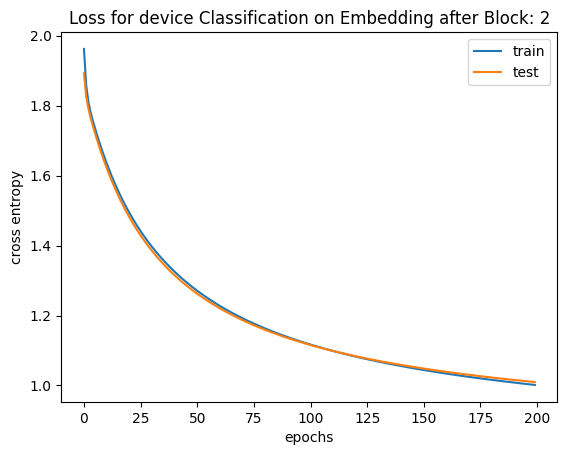

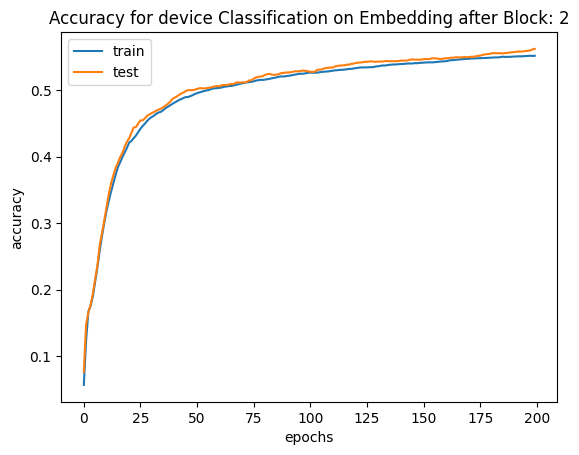

In [46]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [47]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [48]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [49]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [50]:
X_test=train_ready(test_data,col_name)

In [51]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

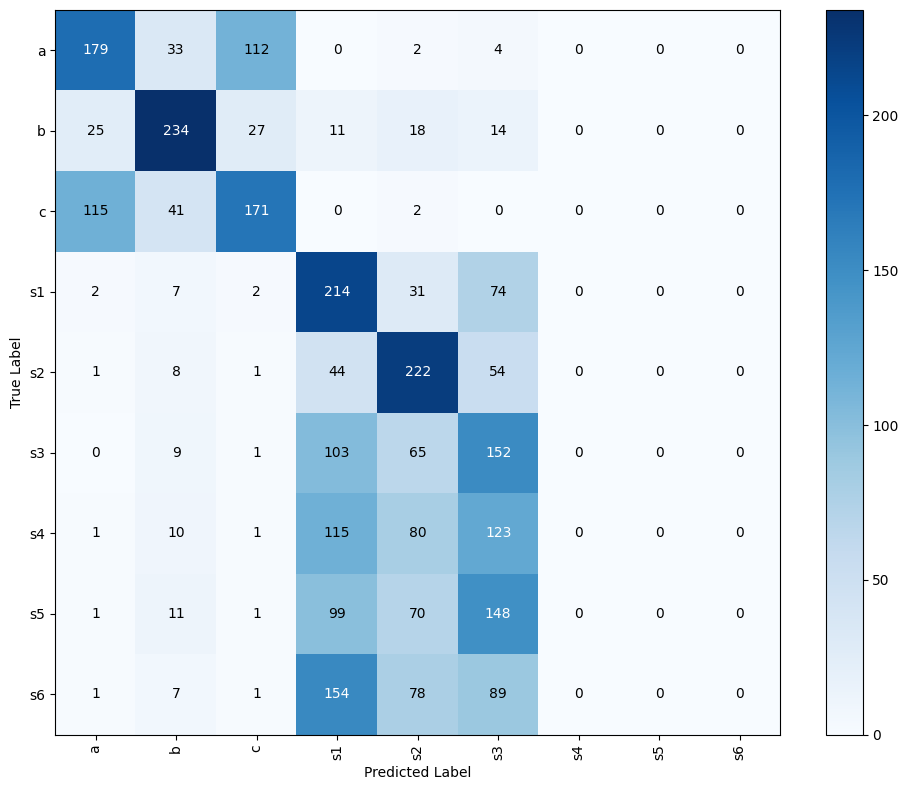

Accuracy: 0.3949


In [52]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-3

In [53]:
Block_number=3

In [54]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [55]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [57]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [58]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [59]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [60]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [61]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [62]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [63]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 337.97batch/s, acc=0.141, loss=2.22] 


Epoch 0 validation: Cross-entropy=2.09, Accuracy=15.5%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 611.58batch/s, acc=0.172, loss=2.09]


Epoch 1 validation: Cross-entropy=1.99, Accuracy=21.3%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 357.20batch/s, acc=0.172, loss=2.03]


Epoch 2 validation: Cross-entropy=1.93, Accuracy=21.3%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 620.44batch/s, acc=0.195, loss=1.99]


Epoch 3 validation: Cross-entropy=1.90, Accuracy=21.3%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 278.07batch/s, acc=0.219, loss=1.96]


Epoch 4 validation: Cross-entropy=1.88, Accuracy=21.7%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 616.90batch/s, acc=0.223, loss=1.93]


Epoch 5 validation: Cross-entropy=1.86, Accuracy=21.9%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 437.98batch/s, acc=0.227, loss=1.91]


Epoch 6 validation: Cross-entropy=1.84, Accuracy=22.6%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 625.79batch/s, acc=0.238, loss=1.88]


Epoch 7 validation: Cross-entropy=1.82, Accuracy=23.9%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 407.12batch/s, acc=0.258, loss=1.86]


Epoch 8 validation: Cross-entropy=1.80, Accuracy=24.6%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 622.49batch/s, acc=0.27, loss=1.84] 


Epoch 9 validation: Cross-entropy=1.79, Accuracy=25.7%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 397.22batch/s, acc=0.285, loss=1.82]


Epoch 10 validation: Cross-entropy=1.77, Accuracy=27.2%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 434.75batch/s, acc=0.309, loss=1.8] 


Epoch 11 validation: Cross-entropy=1.76, Accuracy=29.0%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 397.00batch/s, acc=0.324, loss=1.78]


Epoch 12 validation: Cross-entropy=1.74, Accuracy=30.8%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 632.70batch/s, acc=0.32, loss=1.76] 


Epoch 13 validation: Cross-entropy=1.73, Accuracy=32.4%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 399.56batch/s, acc=0.352, loss=1.75]


Epoch 14 validation: Cross-entropy=1.72, Accuracy=33.8%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 624.48batch/s, acc=0.379, loss=1.73]


Epoch 15 validation: Cross-entropy=1.71, Accuracy=35.3%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 404.15batch/s, acc=0.387, loss=1.72]


Epoch 16 validation: Cross-entropy=1.69, Accuracy=36.7%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 625.71batch/s, acc=0.391, loss=1.7] 


Epoch 17 validation: Cross-entropy=1.68, Accuracy=37.9%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 415.46batch/s, acc=0.422, loss=1.69]


Epoch 18 validation: Cross-entropy=1.67, Accuracy=39.6%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 356.18batch/s, acc=0.426, loss=1.68]


Epoch 19 validation: Cross-entropy=1.66, Accuracy=40.5%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 538.11batch/s, acc=0.445, loss=1.66]


Epoch 20 validation: Cross-entropy=1.65, Accuracy=42.0%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 535.76batch/s, acc=0.449, loss=1.65]


Epoch 21 validation: Cross-entropy=1.64, Accuracy=43.0%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 419.95batch/s, acc=0.465, loss=1.64]


Epoch 22 validation: Cross-entropy=1.63, Accuracy=44.2%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 410.40batch/s, acc=0.469, loss=1.63]


Epoch 23 validation: Cross-entropy=1.63, Accuracy=45.1%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 524.63batch/s, acc=0.453, loss=1.62]


Epoch 24 validation: Cross-entropy=1.62, Accuracy=46.3%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 325.94batch/s, acc=0.465, loss=1.61]


Epoch 25 validation: Cross-entropy=1.61, Accuracy=46.8%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 512.31batch/s, acc=0.469, loss=1.6] 


Epoch 26 validation: Cross-entropy=1.60, Accuracy=47.1%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 253.90batch/s, acc=0.48, loss=1.59] 


Epoch 27 validation: Cross-entropy=1.59, Accuracy=47.5%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 561.97batch/s, acc=0.48, loss=1.58] 


Epoch 28 validation: Cross-entropy=1.59, Accuracy=47.9%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 362.92batch/s, acc=0.48, loss=1.57] 


Epoch 29 validation: Cross-entropy=1.58, Accuracy=47.9%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 567.04batch/s, acc=0.48, loss=1.57] 


Epoch 30 validation: Cross-entropy=1.57, Accuracy=48.5%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 345.66batch/s, acc=0.492, loss=1.56]


Epoch 31 validation: Cross-entropy=1.56, Accuracy=48.8%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 608.63batch/s, acc=0.492, loss=1.55]


Epoch 32 validation: Cross-entropy=1.56, Accuracy=49.2%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 401.66batch/s, acc=0.512, loss=1.54]


Epoch 33 validation: Cross-entropy=1.55, Accuracy=49.5%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 380.40batch/s, acc=0.516, loss=1.53]


Epoch 34 validation: Cross-entropy=1.54, Accuracy=49.9%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 342.70batch/s, acc=0.52, loss=1.53] 


Epoch 35 validation: Cross-entropy=1.54, Accuracy=49.8%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 612.30batch/s, acc=0.508, loss=1.52]


Epoch 36 validation: Cross-entropy=1.53, Accuracy=50.1%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 397.78batch/s, acc=0.5, loss=1.51]  


Epoch 37 validation: Cross-entropy=1.52, Accuracy=50.2%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 614.25batch/s, acc=0.504, loss=1.51]


Epoch 38 validation: Cross-entropy=1.52, Accuracy=50.3%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 404.36batch/s, acc=0.496, loss=1.5] 


Epoch 39 validation: Cross-entropy=1.51, Accuracy=50.6%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 624.09batch/s, acc=0.496, loss=1.49]


Epoch 40 validation: Cross-entropy=1.51, Accuracy=50.8%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 262.40batch/s, acc=0.496, loss=1.49]


Epoch 41 validation: Cross-entropy=1.50, Accuracy=50.8%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 584.16batch/s, acc=0.5, loss=1.48]  


Epoch 42 validation: Cross-entropy=1.49, Accuracy=50.8%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 331.21batch/s, acc=0.504, loss=1.47]


Epoch 43 validation: Cross-entropy=1.49, Accuracy=51.0%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 455.87batch/s, acc=0.504, loss=1.47]


Epoch 44 validation: Cross-entropy=1.48, Accuracy=51.0%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 559.46batch/s, acc=0.504, loss=1.46]


Epoch 45 validation: Cross-entropy=1.48, Accuracy=51.0%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 439.35batch/s, acc=0.504, loss=1.46]


Epoch 46 validation: Cross-entropy=1.47, Accuracy=51.2%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 563.95batch/s, acc=0.5, loss=1.45]  


Epoch 47 validation: Cross-entropy=1.47, Accuracy=51.3%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 266.25batch/s, acc=0.508, loss=1.45]


Epoch 48 validation: Cross-entropy=1.46, Accuracy=51.6%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 619.22batch/s, acc=0.504, loss=1.44]


Epoch 49 validation: Cross-entropy=1.46, Accuracy=51.8%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 389.03batch/s, acc=0.504, loss=1.43]


Epoch 50 validation: Cross-entropy=1.45, Accuracy=52.0%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 631.50batch/s, acc=0.504, loss=1.43]


Epoch 51 validation: Cross-entropy=1.45, Accuracy=52.2%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 405.67batch/s, acc=0.504, loss=1.42]


Epoch 52 validation: Cross-entropy=1.44, Accuracy=52.3%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 622.21batch/s, acc=0.508, loss=1.42]


Epoch 53 validation: Cross-entropy=1.44, Accuracy=52.3%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 286.36batch/s, acc=0.512, loss=1.41]


Epoch 54 validation: Cross-entropy=1.43, Accuracy=52.6%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 343.57batch/s, acc=0.512, loss=1.41]


Epoch 55 validation: Cross-entropy=1.43, Accuracy=52.8%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 362.50batch/s, acc=0.52, loss=1.4]  


Epoch 56 validation: Cross-entropy=1.42, Accuracy=52.9%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 605.61batch/s, acc=0.52, loss=1.4]  


Epoch 57 validation: Cross-entropy=1.42, Accuracy=53.0%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 413.16batch/s, acc=0.52, loss=1.39] 


Epoch 58 validation: Cross-entropy=1.41, Accuracy=53.0%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 625.94batch/s, acc=0.52, loss=1.39] 


Epoch 59 validation: Cross-entropy=1.41, Accuracy=52.8%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 393.79batch/s, acc=0.52, loss=1.39] 


Epoch 60 validation: Cross-entropy=1.41, Accuracy=52.9%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 607.55batch/s, acc=0.527, loss=1.38]


Epoch 61 validation: Cross-entropy=1.40, Accuracy=52.9%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 345.00batch/s, acc=0.527, loss=1.38]


Epoch 62 validation: Cross-entropy=1.40, Accuracy=52.9%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 573.11batch/s, acc=0.527, loss=1.37]


Epoch 63 validation: Cross-entropy=1.39, Accuracy=53.1%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 405.29batch/s, acc=0.527, loss=1.37]


Epoch 64 validation: Cross-entropy=1.39, Accuracy=53.3%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 631.22batch/s, acc=0.523, loss=1.36]


Epoch 65 validation: Cross-entropy=1.38, Accuracy=53.1%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 403.67batch/s, acc=0.523, loss=1.36]


Epoch 66 validation: Cross-entropy=1.38, Accuracy=53.3%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 629.93batch/s, acc=0.523, loss=1.36]


Epoch 67 validation: Cross-entropy=1.38, Accuracy=53.5%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 406.20batch/s, acc=0.523, loss=1.35]


Epoch 68 validation: Cross-entropy=1.37, Accuracy=53.5%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 626.73batch/s, acc=0.523, loss=1.35]


Epoch 69 validation: Cross-entropy=1.37, Accuracy=53.5%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 281.02batch/s, acc=0.523, loss=1.34]


Epoch 70 validation: Cross-entropy=1.37, Accuracy=53.4%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 617.87batch/s, acc=0.52, loss=1.34] 


Epoch 71 validation: Cross-entropy=1.36, Accuracy=53.4%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 383.44batch/s, acc=0.52, loss=1.34] 


Epoch 72 validation: Cross-entropy=1.36, Accuracy=53.3%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 617.85batch/s, acc=0.52, loss=1.33] 


Epoch 73 validation: Cross-entropy=1.36, Accuracy=53.3%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 384.37batch/s, acc=0.516, loss=1.33]


Epoch 74 validation: Cross-entropy=1.35, Accuracy=53.3%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 615.29batch/s, acc=0.516, loss=1.32]


Epoch 75 validation: Cross-entropy=1.35, Accuracy=53.5%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 408.43batch/s, acc=0.516, loss=1.32]


Epoch 76 validation: Cross-entropy=1.35, Accuracy=53.4%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 370.29batch/s, acc=0.516, loss=1.32]


Epoch 77 validation: Cross-entropy=1.34, Accuracy=53.5%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 401.36batch/s, acc=0.516, loss=1.31]


Epoch 78 validation: Cross-entropy=1.34, Accuracy=53.7%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 626.02batch/s, acc=0.516, loss=1.31]


Epoch 79 validation: Cross-entropy=1.34, Accuracy=53.8%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 406.80batch/s, acc=0.512, loss=1.31]


Epoch 80 validation: Cross-entropy=1.33, Accuracy=53.8%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 632.12batch/s, acc=0.512, loss=1.3] 


Epoch 81 validation: Cross-entropy=1.33, Accuracy=53.9%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 402.82batch/s, acc=0.512, loss=1.3] 


Epoch 82 validation: Cross-entropy=1.33, Accuracy=54.0%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 623.62batch/s, acc=0.512, loss=1.3] 


Epoch 83 validation: Cross-entropy=1.32, Accuracy=54.2%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 312.06batch/s, acc=0.512, loss=1.29]


Epoch 84 validation: Cross-entropy=1.32, Accuracy=54.2%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 598.22batch/s, acc=0.512, loss=1.29]


Epoch 85 validation: Cross-entropy=1.32, Accuracy=54.2%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 388.19batch/s, acc=0.512, loss=1.29]


Epoch 86 validation: Cross-entropy=1.31, Accuracy=54.2%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 618.98batch/s, acc=0.512, loss=1.28]


Epoch 87 validation: Cross-entropy=1.31, Accuracy=54.4%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 413.50batch/s, acc=0.512, loss=1.28]


Epoch 88 validation: Cross-entropy=1.31, Accuracy=54.5%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 621.61batch/s, acc=0.516, loss=1.28]


Epoch 89 validation: Cross-entropy=1.31, Accuracy=54.5%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 412.00batch/s, acc=0.52, loss=1.28] 


Epoch 90 validation: Cross-entropy=1.30, Accuracy=54.5%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 499.22batch/s, acc=0.516, loss=1.27]


Epoch 91 validation: Cross-entropy=1.30, Accuracy=54.5%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 343.62batch/s, acc=0.52, loss=1.27] 


Epoch 92 validation: Cross-entropy=1.30, Accuracy=54.7%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 630.24batch/s, acc=0.52, loss=1.27] 


Epoch 93 validation: Cross-entropy=1.29, Accuracy=54.7%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 398.84batch/s, acc=0.52, loss=1.26] 


Epoch 94 validation: Cross-entropy=1.29, Accuracy=54.8%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 614.59batch/s, acc=0.523, loss=1.26]


Epoch 95 validation: Cross-entropy=1.29, Accuracy=54.7%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 406.13batch/s, acc=0.527, loss=1.26]


Epoch 96 validation: Cross-entropy=1.29, Accuracy=54.8%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 633.04batch/s, acc=0.531, loss=1.25]


Epoch 97 validation: Cross-entropy=1.28, Accuracy=54.9%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 399.77batch/s, acc=0.535, loss=1.25]


Epoch 98 validation: Cross-entropy=1.28, Accuracy=54.9%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 423.79batch/s, acc=0.535, loss=1.25]


Epoch 99 validation: Cross-entropy=1.28, Accuracy=54.9%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 426.99batch/s, acc=0.539, loss=1.25]


Epoch 100 validation: Cross-entropy=1.28, Accuracy=54.8%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 614.57batch/s, acc=0.539, loss=1.24]


Epoch 101 validation: Cross-entropy=1.27, Accuracy=54.9%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 386.63batch/s, acc=0.539, loss=1.24]


Epoch 102 validation: Cross-entropy=1.27, Accuracy=55.1%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 611.69batch/s, acc=0.539, loss=1.24]


Epoch 103 validation: Cross-entropy=1.27, Accuracy=55.2%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 389.86batch/s, acc=0.535, loss=1.24]


Epoch 104 validation: Cross-entropy=1.27, Accuracy=55.2%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 602.71batch/s, acc=0.535, loss=1.23]


Epoch 105 validation: Cross-entropy=1.26, Accuracy=55.2%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 432.78batch/s, acc=0.531, loss=1.23]


Epoch 106 validation: Cross-entropy=1.26, Accuracy=55.2%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 586.89batch/s, acc=0.531, loss=1.23]


Epoch 107 validation: Cross-entropy=1.26, Accuracy=55.3%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 300.20batch/s, acc=0.531, loss=1.23]


Epoch 108 validation: Cross-entropy=1.26, Accuracy=55.4%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 601.86batch/s, acc=0.531, loss=1.22]


Epoch 109 validation: Cross-entropy=1.26, Accuracy=55.4%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 453.50batch/s, acc=0.531, loss=1.22]


Epoch 110 validation: Cross-entropy=1.25, Accuracy=55.4%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 566.77batch/s, acc=0.531, loss=1.22]


Epoch 111 validation: Cross-entropy=1.25, Accuracy=55.3%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 525.63batch/s, acc=0.535, loss=1.22]


Epoch 112 validation: Cross-entropy=1.25, Accuracy=55.4%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 456.72batch/s, acc=0.535, loss=1.21]


Epoch 113 validation: Cross-entropy=1.25, Accuracy=55.4%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 411.03batch/s, acc=0.535, loss=1.21]


Epoch 114 validation: Cross-entropy=1.24, Accuracy=55.4%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 393.72batch/s, acc=0.535, loss=1.21]


Epoch 115 validation: Cross-entropy=1.24, Accuracy=55.5%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 346.82batch/s, acc=0.535, loss=1.21]


Epoch 116 validation: Cross-entropy=1.24, Accuracy=55.4%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 543.04batch/s, acc=0.531, loss=1.21]


Epoch 117 validation: Cross-entropy=1.24, Accuracy=55.4%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 382.57batch/s, acc=0.535, loss=1.2] 

Epoch 118 validation: Cross-entropy=1.24, Accuracy=55.4%

Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 567.45batch/s, acc=0.535, loss=1.2] 


Epoch 119 validation: Cross-entropy=1.23, Accuracy=55.4%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 384.06batch/s, acc=0.535, loss=1.2] 


Epoch 120 validation: Cross-entropy=1.23, Accuracy=55.4%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 630.86batch/s, acc=0.535, loss=1.2] 


Epoch 121 validation: Cross-entropy=1.23, Accuracy=55.3%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 319.26batch/s, acc=0.531, loss=1.2] 


Epoch 122 validation: Cross-entropy=1.23, Accuracy=55.2%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 573.63batch/s, acc=0.535, loss=1.19]


Epoch 123 validation: Cross-entropy=1.23, Accuracy=55.3%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 393.57batch/s, acc=0.535, loss=1.19]


Epoch 124 validation: Cross-entropy=1.22, Accuracy=55.2%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 625.70batch/s, acc=0.535, loss=1.19]


Epoch 125 validation: Cross-entropy=1.22, Accuracy=55.2%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 427.82batch/s, acc=0.535, loss=1.19]


Epoch 126 validation: Cross-entropy=1.22, Accuracy=55.3%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 577.37batch/s, acc=0.535, loss=1.19]


Epoch 127 validation: Cross-entropy=1.22, Accuracy=55.3%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 453.66batch/s, acc=0.535, loss=1.18]


Epoch 128 validation: Cross-entropy=1.22, Accuracy=55.3%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 546.70batch/s, acc=0.535, loss=1.18]


Epoch 129 validation: Cross-entropy=1.22, Accuracy=55.2%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 514.69batch/s, acc=0.535, loss=1.18]


Epoch 130 validation: Cross-entropy=1.21, Accuracy=55.2%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 477.84batch/s, acc=0.531, loss=1.18]


Epoch 131 validation: Cross-entropy=1.21, Accuracy=55.2%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 493.62batch/s, acc=0.531, loss=1.18]


Epoch 132 validation: Cross-entropy=1.21, Accuracy=55.3%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 366.80batch/s, acc=0.531, loss=1.17]


Epoch 133 validation: Cross-entropy=1.21, Accuracy=55.3%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 414.60batch/s, acc=0.531, loss=1.17]


Epoch 134 validation: Cross-entropy=1.21, Accuracy=55.3%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 563.49batch/s, acc=0.535, loss=1.17]


Epoch 135 validation: Cross-entropy=1.21, Accuracy=55.3%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 486.96batch/s, acc=0.535, loss=1.17]


Epoch 136 validation: Cross-entropy=1.20, Accuracy=55.4%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 460.70batch/s, acc=0.535, loss=1.17]


Epoch 137 validation: Cross-entropy=1.20, Accuracy=55.4%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 389.57batch/s, acc=0.535, loss=1.17]


Epoch 138 validation: Cross-entropy=1.20, Accuracy=55.5%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 614.36batch/s, acc=0.535, loss=1.16]


Epoch 139 validation: Cross-entropy=1.20, Accuracy=55.4%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 398.65batch/s, acc=0.535, loss=1.16]


Epoch 140 validation: Cross-entropy=1.20, Accuracy=55.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 608.28batch/s, acc=0.535, loss=1.16]


Epoch 141 validation: Cross-entropy=1.20, Accuracy=55.5%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 289.68batch/s, acc=0.535, loss=1.16]


Epoch 142 validation: Cross-entropy=1.19, Accuracy=55.6%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 626.89batch/s, acc=0.539, loss=1.16]


Epoch 143 validation: Cross-entropy=1.19, Accuracy=55.6%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 382.41batch/s, acc=0.539, loss=1.15]


Epoch 144 validation: Cross-entropy=1.19, Accuracy=55.6%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 600.87batch/s, acc=0.539, loss=1.15]


Epoch 145 validation: Cross-entropy=1.19, Accuracy=55.6%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 392.42batch/s, acc=0.535, loss=1.15]


Epoch 146 validation: Cross-entropy=1.19, Accuracy=55.5%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 610.76batch/s, acc=0.535, loss=1.15]


Epoch 147 validation: Cross-entropy=1.19, Accuracy=55.6%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 445.03batch/s, acc=0.539, loss=1.15]


Epoch 148 validation: Cross-entropy=1.18, Accuracy=55.7%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 387.46batch/s, acc=0.539, loss=1.15]


Epoch 149 validation: Cross-entropy=1.18, Accuracy=55.7%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 396.30batch/s, acc=0.539, loss=1.15]


Epoch 150 validation: Cross-entropy=1.18, Accuracy=55.6%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 619.31batch/s, acc=0.543, loss=1.14]


Epoch 151 validation: Cross-entropy=1.18, Accuracy=55.8%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 396.59batch/s, acc=0.543, loss=1.14]


Epoch 152 validation: Cross-entropy=1.18, Accuracy=55.7%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 621.76batch/s, acc=0.543, loss=1.14]


Epoch 153 validation: Cross-entropy=1.18, Accuracy=55.9%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 397.75batch/s, acc=0.543, loss=1.14]


Epoch 154 validation: Cross-entropy=1.18, Accuracy=55.9%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 444.62batch/s, acc=0.543, loss=1.14]


Epoch 155 validation: Cross-entropy=1.17, Accuracy=55.9%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 365.68batch/s, acc=0.539, loss=1.14]


Epoch 156 validation: Cross-entropy=1.17, Accuracy=55.9%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 619.44batch/s, acc=0.539, loss=1.13]


Epoch 157 validation: Cross-entropy=1.17, Accuracy=55.9%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 441.22batch/s, acc=0.539, loss=1.13]


Epoch 158 validation: Cross-entropy=1.17, Accuracy=55.9%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 626.62batch/s, acc=0.539, loss=1.13]


Epoch 159 validation: Cross-entropy=1.17, Accuracy=55.9%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 401.49batch/s, acc=0.539, loss=1.13]


Epoch 160 validation: Cross-entropy=1.17, Accuracy=55.9%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 491.31batch/s, acc=0.539, loss=1.13]


Epoch 161 validation: Cross-entropy=1.17, Accuracy=55.9%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 497.28batch/s, acc=0.539, loss=1.13]


Epoch 162 validation: Cross-entropy=1.17, Accuracy=55.9%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 466.47batch/s, acc=0.539, loss=1.13]


Epoch 163 validation: Cross-entropy=1.16, Accuracy=55.9%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 547.90batch/s, acc=0.539, loss=1.12]


Epoch 164 validation: Cross-entropy=1.16, Accuracy=55.9%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 336.98batch/s, acc=0.539, loss=1.12]


Epoch 165 validation: Cross-entropy=1.16, Accuracy=55.9%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 527.79batch/s, acc=0.539, loss=1.12]


Epoch 166 validation: Cross-entropy=1.16, Accuracy=55.9%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 430.27batch/s, acc=0.543, loss=1.12]


Epoch 167 validation: Cross-entropy=1.16, Accuracy=55.9%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 519.05batch/s, acc=0.543, loss=1.12]


Epoch 168 validation: Cross-entropy=1.16, Accuracy=56.1%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 463.92batch/s, acc=0.547, loss=1.12]


Epoch 169 validation: Cross-entropy=1.16, Accuracy=56.0%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 545.28batch/s, acc=0.547, loss=1.12]


Epoch 170 validation: Cross-entropy=1.16, Accuracy=56.0%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 308.78batch/s, acc=0.547, loss=1.12]


Epoch 171 validation: Cross-entropy=1.15, Accuracy=56.0%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 589.93batch/s, acc=0.547, loss=1.11]


Epoch 172 validation: Cross-entropy=1.15, Accuracy=56.1%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 389.82batch/s, acc=0.547, loss=1.11]


Epoch 173 validation: Cross-entropy=1.15, Accuracy=56.1%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 600.47batch/s, acc=0.547, loss=1.11]


Epoch 174 validation: Cross-entropy=1.15, Accuracy=56.1%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 384.25batch/s, acc=0.547, loss=1.11]


Epoch 175 validation: Cross-entropy=1.15, Accuracy=56.0%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 617.90batch/s, acc=0.547, loss=1.11]


Epoch 176 validation: Cross-entropy=1.15, Accuracy=56.1%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 394.74batch/s, acc=0.547, loss=1.11]


Epoch 177 validation: Cross-entropy=1.15, Accuracy=56.1%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 614.80batch/s, acc=0.547, loss=1.11]


Epoch 178 validation: Cross-entropy=1.15, Accuracy=56.0%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 287.17batch/s, acc=0.547, loss=1.11]


Epoch 179 validation: Cross-entropy=1.14, Accuracy=56.0%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 451.18batch/s, acc=0.547, loss=1.1] 


Epoch 180 validation: Cross-entropy=1.14, Accuracy=56.1%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 543.97batch/s, acc=0.547, loss=1.1] 


Epoch 181 validation: Cross-entropy=1.14, Accuracy=56.1%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 421.91batch/s, acc=0.543, loss=1.1] 


Epoch 182 validation: Cross-entropy=1.14, Accuracy=56.1%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 549.30batch/s, acc=0.543, loss=1.1] 


Epoch 183 validation: Cross-entropy=1.14, Accuracy=56.2%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 513.89batch/s, acc=0.543, loss=1.1] 


Epoch 184 validation: Cross-entropy=1.14, Accuracy=56.2%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 446.61batch/s, acc=0.543, loss=1.1] 


Epoch 185 validation: Cross-entropy=1.14, Accuracy=56.1%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 433.26batch/s, acc=0.543, loss=1.1] 


Epoch 186 validation: Cross-entropy=1.14, Accuracy=56.2%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 455.58batch/s, acc=0.543, loss=1.1] 


Epoch 187 validation: Cross-entropy=1.14, Accuracy=56.2%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 375.22batch/s, acc=0.543, loss=1.09]


Epoch 188 validation: Cross-entropy=1.13, Accuracy=56.2%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 602.45batch/s, acc=0.547, loss=1.09]


Epoch 189 validation: Cross-entropy=1.13, Accuracy=56.2%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 406.71batch/s, acc=0.547, loss=1.09]


Epoch 190 validation: Cross-entropy=1.13, Accuracy=56.2%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 590.54batch/s, acc=0.547, loss=1.09]


Epoch 191 validation: Cross-entropy=1.13, Accuracy=56.2%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 430.24batch/s, acc=0.547, loss=1.09]


Epoch 192 validation: Cross-entropy=1.13, Accuracy=56.2%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 563.51batch/s, acc=0.547, loss=1.09]


Epoch 193 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 422.75batch/s, acc=0.547, loss=1.09]


Epoch 194 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 392.72batch/s, acc=0.547, loss=1.09]


Epoch 195 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 406.57batch/s, acc=0.547, loss=1.09]


Epoch 196 validation: Cross-entropy=1.13, Accuracy=56.1%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 611.23batch/s, acc=0.547, loss=1.08]


Epoch 197 validation: Cross-entropy=1.13, Accuracy=56.2%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 407.18batch/s, acc=0.547, loss=1.08]


Epoch 198 validation: Cross-entropy=1.12, Accuracy=56.3%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 571.00batch/s, acc=0.547, loss=1.08]


Epoch 199 validation: Cross-entropy=1.12, Accuracy=56.3%


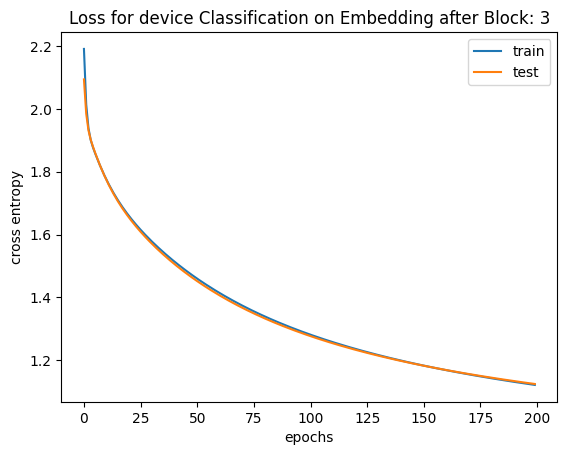

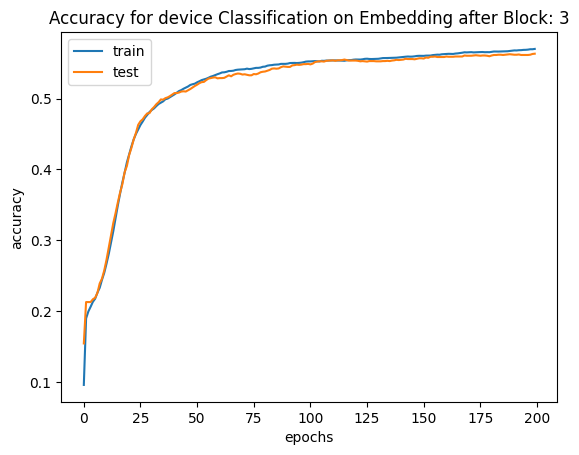

In [64]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)


best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [65]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [66]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [67]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [68]:
X_test=train_ready(test_data,col_name)

In [69]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

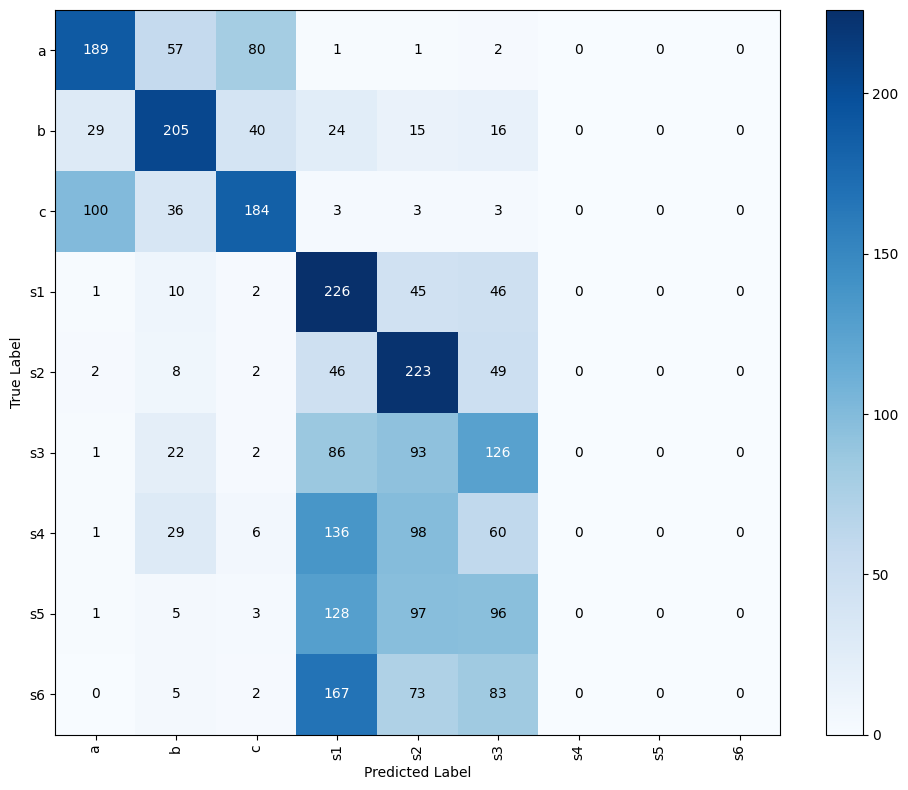

Accuracy: 0.3885


In [70]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-4

In [71]:
Block_number=4

In [72]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [73]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [74]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [75]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [76]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [77]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [78]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [79]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [80]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [81]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 371.71batch/s, acc=0.0352, loss=2.37]


Epoch 0 validation: Cross-entropy=2.33, Accuracy=4.9%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 532.64batch/s, acc=0.0312, loss=2.07]


Epoch 1 validation: Cross-entropy=2.06, Accuracy=4.8%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 268.04batch/s, acc=0.105, loss=1.93] 


Epoch 2 validation: Cross-entropy=1.93, Accuracy=10.0%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 603.24batch/s, acc=0.203, loss=1.87]


Epoch 3 validation: Cross-entropy=1.88, Accuracy=19.4%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 398.71batch/s, acc=0.242, loss=1.84]


Epoch 4 validation: Cross-entropy=1.86, Accuracy=23.0%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 611.48batch/s, acc=0.258, loss=1.82]


Epoch 5 validation: Cross-entropy=1.83, Accuracy=24.2%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 385.27batch/s, acc=0.273, loss=1.79]


Epoch 6 validation: Cross-entropy=1.81, Accuracy=25.5%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 611.19batch/s, acc=0.285, loss=1.77]


Epoch 7 validation: Cross-entropy=1.79, Accuracy=26.4%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 380.62batch/s, acc=0.293, loss=1.75]


Epoch 8 validation: Cross-entropy=1.77, Accuracy=27.4%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 420.88batch/s, acc=0.289, loss=1.73]


Epoch 9 validation: Cross-entropy=1.75, Accuracy=28.2%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 371.72batch/s, acc=0.289, loss=1.71]


Epoch 10 validation: Cross-entropy=1.73, Accuracy=29.2%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 559.84batch/s, acc=0.301, loss=1.69]


Epoch 11 validation: Cross-entropy=1.71, Accuracy=29.6%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 333.09batch/s, acc=0.297, loss=1.67]


Epoch 12 validation: Cross-entropy=1.70, Accuracy=30.1%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 448.89batch/s, acc=0.293, loss=1.65]


Epoch 13 validation: Cross-entropy=1.68, Accuracy=30.7%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 436.16batch/s, acc=0.297, loss=1.63]


Epoch 14 validation: Cross-entropy=1.66, Accuracy=31.5%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 443.28batch/s, acc=0.312, loss=1.62]


Epoch 15 validation: Cross-entropy=1.65, Accuracy=32.4%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 558.35batch/s, acc=0.32, loss=1.6]  


Epoch 16 validation: Cross-entropy=1.63, Accuracy=33.3%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 306.42batch/s, acc=0.309, loss=1.59]


Epoch 17 validation: Cross-entropy=1.62, Accuracy=34.3%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 579.65batch/s, acc=0.32, loss=1.57] 


Epoch 18 validation: Cross-entropy=1.60, Accuracy=35.3%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 426.91batch/s, acc=0.32, loss=1.56] 


Epoch 19 validation: Cross-entropy=1.59, Accuracy=36.3%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 587.16batch/s, acc=0.34, loss=1.54] 


Epoch 20 validation: Cross-entropy=1.58, Accuracy=37.8%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 428.72batch/s, acc=0.352, loss=1.53]


Epoch 21 validation: Cross-entropy=1.56, Accuracy=39.2%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 590.29batch/s, acc=0.363, loss=1.52]


Epoch 22 validation: Cross-entropy=1.55, Accuracy=40.5%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 433.45batch/s, acc=0.391, loss=1.5] 


Epoch 23 validation: Cross-entropy=1.54, Accuracy=41.8%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 449.83batch/s, acc=0.395, loss=1.49]


Epoch 24 validation: Cross-entropy=1.53, Accuracy=42.9%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 428.43batch/s, acc=0.402, loss=1.48]


Epoch 25 validation: Cross-entropy=1.52, Accuracy=43.9%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 576.53batch/s, acc=0.418, loss=1.47]


Epoch 26 validation: Cross-entropy=1.51, Accuracy=45.1%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 454.67batch/s, acc=0.441, loss=1.46]


Epoch 27 validation: Cross-entropy=1.50, Accuracy=46.1%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 561.61batch/s, acc=0.445, loss=1.45]


Epoch 28 validation: Cross-entropy=1.48, Accuracy=47.0%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 441.94batch/s, acc=0.453, loss=1.44]


Epoch 29 validation: Cross-entropy=1.47, Accuracy=47.9%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 542.40batch/s, acc=0.465, loss=1.43]


Epoch 30 validation: Cross-entropy=1.46, Accuracy=48.8%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 453.98batch/s, acc=0.484, loss=1.42]


Epoch 31 validation: Cross-entropy=1.45, Accuracy=49.5%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 550.69batch/s, acc=0.488, loss=1.41]


Epoch 32 validation: Cross-entropy=1.45, Accuracy=50.1%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 288.22batch/s, acc=0.496, loss=1.4] 


Epoch 33 validation: Cross-entropy=1.44, Accuracy=50.9%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 627.83batch/s, acc=0.504, loss=1.39]


Epoch 34 validation: Cross-entropy=1.43, Accuracy=51.6%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 404.13batch/s, acc=0.52, loss=1.38] 


Epoch 35 validation: Cross-entropy=1.42, Accuracy=52.2%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 613.07batch/s, acc=0.527, loss=1.37]


Epoch 36 validation: Cross-entropy=1.41, Accuracy=52.8%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 375.01batch/s, acc=0.523, loss=1.36]


Epoch 37 validation: Cross-entropy=1.40, Accuracy=53.1%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 626.02batch/s, acc=0.523, loss=1.35]


Epoch 38 validation: Cross-entropy=1.39, Accuracy=53.6%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 381.67batch/s, acc=0.531, loss=1.34]


Epoch 39 validation: Cross-entropy=1.38, Accuracy=54.1%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 437.94batch/s, acc=0.539, loss=1.34]


Epoch 40 validation: Cross-entropy=1.38, Accuracy=54.4%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 357.28batch/s, acc=0.551, loss=1.33]


Epoch 41 validation: Cross-entropy=1.37, Accuracy=54.7%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 632.44batch/s, acc=0.551, loss=1.32]


Epoch 42 validation: Cross-entropy=1.36, Accuracy=55.0%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 401.78batch/s, acc=0.547, loss=1.31]


Epoch 43 validation: Cross-entropy=1.35, Accuracy=55.5%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 631.29batch/s, acc=0.555, loss=1.31]


Epoch 44 validation: Cross-entropy=1.35, Accuracy=55.8%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 416.17batch/s, acc=0.566, loss=1.3] 


Epoch 45 validation: Cross-entropy=1.34, Accuracy=56.2%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 623.73batch/s, acc=0.57, loss=1.29] 


Epoch 46 validation: Cross-entropy=1.33, Accuracy=56.6%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 399.72batch/s, acc=0.578, loss=1.29]


Epoch 47 validation: Cross-entropy=1.33, Accuracy=56.9%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 451.88batch/s, acc=0.578, loss=1.28]


Epoch 48 validation: Cross-entropy=1.32, Accuracy=57.1%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 404.91batch/s, acc=0.578, loss=1.27]


Epoch 49 validation: Cross-entropy=1.31, Accuracy=57.4%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 612.17batch/s, acc=0.578, loss=1.27]


Epoch 50 validation: Cross-entropy=1.31, Accuracy=57.6%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 398.38batch/s, acc=0.578, loss=1.26]


Epoch 51 validation: Cross-entropy=1.30, Accuracy=57.9%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 628.98batch/s, acc=0.574, loss=1.25]


Epoch 52 validation: Cross-entropy=1.29, Accuracy=58.0%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 404.67batch/s, acc=0.574, loss=1.25]


Epoch 53 validation: Cross-entropy=1.29, Accuracy=58.0%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 612.92batch/s, acc=0.582, loss=1.24]


Epoch 54 validation: Cross-entropy=1.28, Accuracy=58.2%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 300.96batch/s, acc=0.582, loss=1.24]


Epoch 55 validation: Cross-entropy=1.28, Accuracy=58.5%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 617.21batch/s, acc=0.578, loss=1.23]


Epoch 56 validation: Cross-entropy=1.27, Accuracy=58.6%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 401.31batch/s, acc=0.582, loss=1.22]


Epoch 57 validation: Cross-entropy=1.27, Accuracy=58.6%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 620.58batch/s, acc=0.59, loss=1.22] 


Epoch 58 validation: Cross-entropy=1.26, Accuracy=58.8%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 401.94batch/s, acc=0.594, loss=1.21]


Epoch 59 validation: Cross-entropy=1.25, Accuracy=59.0%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 515.00batch/s, acc=0.59, loss=1.21] 


Epoch 60 validation: Cross-entropy=1.25, Accuracy=59.3%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 491.08batch/s, acc=0.594, loss=1.2] 


Epoch 61 validation: Cross-entropy=1.24, Accuracy=59.3%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 446.03batch/s, acc=0.598, loss=1.2] 


Epoch 62 validation: Cross-entropy=1.24, Accuracy=59.3%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 408.33batch/s, acc=0.602, loss=1.19]


Epoch 63 validation: Cross-entropy=1.23, Accuracy=59.3%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 430.11batch/s, acc=0.609, loss=1.19]


Epoch 64 validation: Cross-entropy=1.23, Accuracy=59.6%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 575.56batch/s, acc=0.605, loss=1.18]


Epoch 65 validation: Cross-entropy=1.22, Accuracy=59.6%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 408.59batch/s, acc=0.609, loss=1.18]


Epoch 66 validation: Cross-entropy=1.22, Accuracy=59.9%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 563.23batch/s, acc=0.613, loss=1.17]


Epoch 67 validation: Cross-entropy=1.22, Accuracy=60.0%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 427.87batch/s, acc=0.613, loss=1.17]


Epoch 68 validation: Cross-entropy=1.21, Accuracy=60.2%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 569.44batch/s, acc=0.617, loss=1.17]


Epoch 69 validation: Cross-entropy=1.21, Accuracy=60.3%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 289.74batch/s, acc=0.617, loss=1.16]


Epoch 70 validation: Cross-entropy=1.20, Accuracy=60.4%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 610.07batch/s, acc=0.625, loss=1.16]


Epoch 71 validation: Cross-entropy=1.20, Accuracy=60.4%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 394.18batch/s, acc=0.625, loss=1.15]


Epoch 72 validation: Cross-entropy=1.19, Accuracy=60.2%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 614.08batch/s, acc=0.625, loss=1.15]


Epoch 73 validation: Cross-entropy=1.19, Accuracy=60.3%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 475.53batch/s, acc=0.625, loss=1.14]


Epoch 74 validation: Cross-entropy=1.19, Accuracy=60.4%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 541.62batch/s, acc=0.625, loss=1.14]


Epoch 75 validation: Cross-entropy=1.18, Accuracy=60.4%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 483.67batch/s, acc=0.621, loss=1.14]


Epoch 76 validation: Cross-entropy=1.18, Accuracy=60.5%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 339.57batch/s, acc=0.625, loss=1.13]


Epoch 77 validation: Cross-entropy=1.17, Accuracy=60.5%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 434.79batch/s, acc=0.625, loss=1.13]


Epoch 78 validation: Cross-entropy=1.17, Accuracy=60.7%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 552.14batch/s, acc=0.625, loss=1.13]


Epoch 79 validation: Cross-entropy=1.17, Accuracy=60.8%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 442.13batch/s, acc=0.625, loss=1.12]


Epoch 80 validation: Cross-entropy=1.16, Accuracy=60.9%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 535.45batch/s, acc=0.625, loss=1.12]


Epoch 81 validation: Cross-entropy=1.16, Accuracy=60.9%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 417.27batch/s, acc=0.617, loss=1.11]


Epoch 82 validation: Cross-entropy=1.16, Accuracy=60.9%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 610.38batch/s, acc=0.617, loss=1.11]


Epoch 83 validation: Cross-entropy=1.15, Accuracy=60.9%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 478.63batch/s, acc=0.617, loss=1.11]


Epoch 84 validation: Cross-entropy=1.15, Accuracy=61.0%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 375.73batch/s, acc=0.617, loss=1.1] 


Epoch 85 validation: Cross-entropy=1.14, Accuracy=60.9%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 420.37batch/s, acc=0.621, loss=1.1] 


Epoch 86 validation: Cross-entropy=1.14, Accuracy=61.0%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 590.85batch/s, acc=0.621, loss=1.1] 


Epoch 87 validation: Cross-entropy=1.14, Accuracy=61.0%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 409.50batch/s, acc=0.621, loss=1.09]


Epoch 88 validation: Cross-entropy=1.13, Accuracy=61.0%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 564.68batch/s, acc=0.621, loss=1.09]


Epoch 89 validation: Cross-entropy=1.13, Accuracy=61.2%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 387.65batch/s, acc=0.621, loss=1.09]


Epoch 90 validation: Cross-entropy=1.13, Accuracy=61.2%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 617.34batch/s, acc=0.625, loss=1.08]


Epoch 91 validation: Cross-entropy=1.13, Accuracy=61.3%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 413.68batch/s, acc=0.625, loss=1.08]


Epoch 92 validation: Cross-entropy=1.12, Accuracy=61.4%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 626.21batch/s, acc=0.625, loss=1.08]


Epoch 93 validation: Cross-entropy=1.12, Accuracy=61.5%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 438.40batch/s, acc=0.625, loss=1.08]


Epoch 94 validation: Cross-entropy=1.12, Accuracy=61.5%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 404.26batch/s, acc=0.625, loss=1.07]


Epoch 95 validation: Cross-entropy=1.11, Accuracy=61.7%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 387.57batch/s, acc=0.621, loss=1.07]


Epoch 96 validation: Cross-entropy=1.11, Accuracy=61.7%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 632.70batch/s, acc=0.617, loss=1.07]


Epoch 97 validation: Cross-entropy=1.11, Accuracy=61.7%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 403.64batch/s, acc=0.617, loss=1.06]


Epoch 98 validation: Cross-entropy=1.10, Accuracy=61.7%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 633.30batch/s, acc=0.617, loss=1.06]


Epoch 99 validation: Cross-entropy=1.10, Accuracy=61.8%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 396.35batch/s, acc=0.617, loss=1.06]


Epoch 100 validation: Cross-entropy=1.10, Accuracy=61.7%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 638.50batch/s, acc=0.617, loss=1.06]


Epoch 101 validation: Cross-entropy=1.10, Accuracy=61.7%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 310.63batch/s, acc=0.617, loss=1.05]


Epoch 102 validation: Cross-entropy=1.09, Accuracy=61.8%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 251.29batch/s, acc=0.621, loss=1.05]


Epoch 103 validation: Cross-entropy=1.09, Accuracy=61.8%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 164.03batch/s, acc=0.617, loss=1.05]


Epoch 104 validation: Cross-entropy=1.09, Accuracy=61.9%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 531.80batch/s, acc=0.617, loss=1.04] 


Epoch 105 validation: Cross-entropy=1.09, Accuracy=62.0%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 323.02batch/s, acc=0.617, loss=1.04] 


Epoch 106 validation: Cross-entropy=1.08, Accuracy=62.0%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 609.92batch/s, acc=0.617, loss=1.04] 


Epoch 107 validation: Cross-entropy=1.08, Accuracy=62.2%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 339.23batch/s, acc=0.617, loss=1.04] 


Epoch 108 validation: Cross-entropy=1.08, Accuracy=62.0%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 595.66batch/s, acc=0.609, loss=1.03] 


Epoch 109 validation: Cross-entropy=1.08, Accuracy=61.9%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 404.09batch/s, acc=0.609, loss=1.03] 


Epoch 110 validation: Cross-entropy=1.07, Accuracy=61.9%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 294.65batch/s, acc=0.609, loss=1.03] 


Epoch 111 validation: Cross-entropy=1.07, Accuracy=61.9%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 519.66batch/s, acc=0.609, loss=1.03]


Epoch 112 validation: Cross-entropy=1.07, Accuracy=61.9%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 406.72batch/s, acc=0.609, loss=1.03] 


Epoch 113 validation: Cross-entropy=1.07, Accuracy=61.9%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 595.77batch/s, acc=0.609, loss=1.02] 


Epoch 114 validation: Cross-entropy=1.06, Accuracy=61.9%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 411.76batch/s, acc=0.605, loss=1.02] 


Epoch 115 validation: Cross-entropy=1.06, Accuracy=62.0%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 618.67batch/s, acc=0.609, loss=1.02] 


Epoch 116 validation: Cross-entropy=1.06, Accuracy=62.0%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 335.88batch/s, acc=0.609, loss=1.02] 


Epoch 117 validation: Cross-entropy=1.06, Accuracy=62.1%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 377.55batch/s, acc=0.609, loss=1.01] 


Epoch 118 validation: Cross-entropy=1.06, Accuracy=62.0%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 220.73batch/s, acc=0.613, loss=1.01] 


Epoch 119 validation: Cross-entropy=1.05, Accuracy=62.1%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 556.70batch/s, acc=0.613, loss=1.01] 


Epoch 120 validation: Cross-entropy=1.05, Accuracy=62.2%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 334.91batch/s, acc=0.613, loss=1.01] 


Epoch 121 validation: Cross-entropy=1.05, Accuracy=62.2%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 564.49batch/s, acc=0.609, loss=1.01] 


Epoch 122 validation: Cross-entropy=1.05, Accuracy=62.3%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 333.12batch/s, acc=0.609, loss=1]    


Epoch 123 validation: Cross-entropy=1.05, Accuracy=62.3%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 594.37batch/s, acc=0.609, loss=1]    


Epoch 124 validation: Cross-entropy=1.04, Accuracy=62.5%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 344.36batch/s, acc=0.609, loss=0.999]


Epoch 125 validation: Cross-entropy=1.04, Accuracy=62.7%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 392.94batch/s, acc=0.609, loss=0.997]


Epoch 126 validation: Cross-entropy=1.04, Accuracy=62.7%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 408.86batch/s, acc=0.609, loss=0.995]


Epoch 127 validation: Cross-entropy=1.04, Accuracy=62.6%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 404.40batch/s, acc=0.609, loss=0.993]


Epoch 128 validation: Cross-entropy=1.04, Accuracy=62.7%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 561.12batch/s, acc=0.613, loss=0.991]


Epoch 129 validation: Cross-entropy=1.03, Accuracy=62.6%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 385.52batch/s, acc=0.613, loss=0.989]


Epoch 130 validation: Cross-entropy=1.03, Accuracy=62.7%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 617.72batch/s, acc=0.617, loss=0.987]


Epoch 131 validation: Cross-entropy=1.03, Accuracy=62.7%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 427.78batch/s, acc=0.617, loss=0.986]


Epoch 132 validation: Cross-entropy=1.03, Accuracy=62.7%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 437.44batch/s, acc=0.617, loss=0.984]


Epoch 133 validation: Cross-entropy=1.03, Accuracy=62.7%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 462.54batch/s, acc=0.617, loss=0.982]


Epoch 134 validation: Cross-entropy=1.02, Accuracy=62.8%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 530.54batch/s, acc=0.617, loss=0.98] 


Epoch 135 validation: Cross-entropy=1.02, Accuracy=62.8%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 472.96batch/s, acc=0.613, loss=0.978]


Epoch 136 validation: Cross-entropy=1.02, Accuracy=62.7%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 540.39batch/s, acc=0.613, loss=0.976]


Epoch 137 validation: Cross-entropy=1.02, Accuracy=62.8%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 367.49batch/s, acc=0.613, loss=0.975]


Epoch 138 validation: Cross-entropy=1.02, Accuracy=62.8%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 563.79batch/s, acc=0.613, loss=0.973]

Epoch 139 validation: Cross-entropy=1.02, Accuracy=62.8%

Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 423.08batch/s, acc=0.617, loss=0.971]


Epoch 140 validation: Cross-entropy=1.01, Accuracy=62.8%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 403.12batch/s, acc=0.617, loss=0.969]


Epoch 141 validation: Cross-entropy=1.01, Accuracy=62.9%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 475.85batch/s, acc=0.617, loss=0.968]


Epoch 142 validation: Cross-entropy=1.01, Accuracy=62.9%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 516.80batch/s, acc=0.613, loss=0.966]


Epoch 143 validation: Cross-entropy=1.01, Accuracy=63.1%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 517.89batch/s, acc=0.617, loss=0.964]


Epoch 144 validation: Cross-entropy=1.01, Accuracy=63.1%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 457.21batch/s, acc=0.617, loss=0.963]


Epoch 145 validation: Cross-entropy=1.01, Accuracy=63.1%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 426.23batch/s, acc=0.617, loss=0.961]


Epoch 146 validation: Cross-entropy=1.00, Accuracy=63.1%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 544.04batch/s, acc=0.617, loss=0.959]


Epoch 147 validation: Cross-entropy=1.00, Accuracy=63.1%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 481.14batch/s, acc=0.621, loss=0.958]


Epoch 148 validation: Cross-entropy=1.00, Accuracy=63.1%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 493.35batch/s, acc=0.617, loss=0.956]


Epoch 149 validation: Cross-entropy=1.00, Accuracy=63.2%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 288.33batch/s, acc=0.617, loss=0.955]


Epoch 150 validation: Cross-entropy=1.00, Accuracy=63.2%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 557.43batch/s, acc=0.617, loss=0.953]


Epoch 151 validation: Cross-entropy=1.00, Accuracy=63.2%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 298.50batch/s, acc=0.617, loss=0.952]


Epoch 152 validation: Cross-entropy=0.99, Accuracy=63.2%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 537.29batch/s, acc=0.613, loss=0.95] 


Epoch 153 validation: Cross-entropy=0.99, Accuracy=63.2%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 303.49batch/s, acc=0.613, loss=0.949]


Epoch 154 validation: Cross-entropy=0.99, Accuracy=63.3%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 461.84batch/s, acc=0.613, loss=0.947]


Epoch 155 validation: Cross-entropy=0.99, Accuracy=63.3%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 464.23batch/s, acc=0.613, loss=0.946]


Epoch 156 validation: Cross-entropy=0.99, Accuracy=63.3%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 365.26batch/s, acc=0.613, loss=0.944]


Epoch 157 validation: Cross-entropy=0.99, Accuracy=63.4%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 235.53batch/s, acc=0.613, loss=0.943]


Epoch 158 validation: Cross-entropy=0.99, Accuracy=63.5%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 339.61batch/s, acc=0.613, loss=0.941]


Epoch 159 validation: Cross-entropy=0.98, Accuracy=63.5%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 561.35batch/s, acc=0.613, loss=0.94] 


Epoch 160 validation: Cross-entropy=0.98, Accuracy=63.5%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 363.39batch/s, acc=0.613, loss=0.938]


Epoch 161 validation: Cross-entropy=0.98, Accuracy=63.5%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 574.58batch/s, acc=0.613, loss=0.937]


Epoch 162 validation: Cross-entropy=0.98, Accuracy=63.5%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 352.18batch/s, acc=0.617, loss=0.935]


Epoch 163 validation: Cross-entropy=0.98, Accuracy=63.5%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 573.28batch/s, acc=0.617, loss=0.934]


Epoch 164 validation: Cross-entropy=0.98, Accuracy=63.5%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 339.29batch/s, acc=0.617, loss=0.933]


Epoch 165 validation: Cross-entropy=0.98, Accuracy=63.5%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 512.22batch/s, acc=0.617, loss=0.931]


Epoch 166 validation: Cross-entropy=0.97, Accuracy=63.6%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 423.08batch/s, acc=0.617, loss=0.93] 


Epoch 167 validation: Cross-entropy=0.97, Accuracy=63.6%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 575.50batch/s, acc=0.617, loss=0.929]


Epoch 168 validation: Cross-entropy=0.97, Accuracy=63.7%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 244.53batch/s, acc=0.617, loss=0.927]


Epoch 169 validation: Cross-entropy=0.97, Accuracy=63.7%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 568.43batch/s, acc=0.617, loss=0.926]


Epoch 170 validation: Cross-entropy=0.97, Accuracy=63.7%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 333.52batch/s, acc=0.617, loss=0.925]


Epoch 171 validation: Cross-entropy=0.97, Accuracy=63.8%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 555.24batch/s, acc=0.617, loss=0.923]


Epoch 172 validation: Cross-entropy=0.97, Accuracy=63.8%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 361.13batch/s, acc=0.617, loss=0.922]


Epoch 173 validation: Cross-entropy=0.97, Accuracy=63.9%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 609.72batch/s, acc=0.617, loss=0.921]


Epoch 174 validation: Cross-entropy=0.96, Accuracy=63.9%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 388.27batch/s, acc=0.617, loss=0.919]


Epoch 175 validation: Cross-entropy=0.96, Accuracy=64.0%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 517.24batch/s, acc=0.617, loss=0.918]


Epoch 176 validation: Cross-entropy=0.96, Accuracy=64.0%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 187.67batch/s, acc=0.617, loss=0.917]


Epoch 177 validation: Cross-entropy=0.96, Accuracy=64.1%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 407.46batch/s, acc=0.617, loss=0.916]


Epoch 178 validation: Cross-entropy=0.96, Accuracy=64.1%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 292.23batch/s, acc=0.617, loss=0.915]


Epoch 179 validation: Cross-entropy=0.96, Accuracy=64.2%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 255.61batch/s, acc=0.617, loss=0.913]


Epoch 180 validation: Cross-entropy=0.96, Accuracy=64.2%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 486.02batch/s, acc=0.617, loss=0.912]


Epoch 181 validation: Cross-entropy=0.96, Accuracy=64.2%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 313.12batch/s, acc=0.613, loss=0.911]


Epoch 182 validation: Cross-entropy=0.95, Accuracy=64.2%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 380.72batch/s, acc=0.613, loss=0.91] 


Epoch 183 validation: Cross-entropy=0.95, Accuracy=64.2%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 472.79batch/s, acc=0.617, loss=0.908]


Epoch 184 validation: Cross-entropy=0.95, Accuracy=64.3%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 524.79batch/s, acc=0.617, loss=0.907]


Epoch 185 validation: Cross-entropy=0.95, Accuracy=64.3%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 288.76batch/s, acc=0.617, loss=0.906]


Epoch 186 validation: Cross-entropy=0.95, Accuracy=64.4%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 514.51batch/s, acc=0.617, loss=0.905]


Epoch 187 validation: Cross-entropy=0.95, Accuracy=64.4%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 221.24batch/s, acc=0.617, loss=0.904]


Epoch 188 validation: Cross-entropy=0.95, Accuracy=64.4%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 457.31batch/s, acc=0.621, loss=0.903]


Epoch 189 validation: Cross-entropy=0.95, Accuracy=64.4%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 273.58batch/s, acc=0.621, loss=0.902]


Epoch 190 validation: Cross-entropy=0.95, Accuracy=64.5%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 490.54batch/s, acc=0.621, loss=0.9]  


Epoch 191 validation: Cross-entropy=0.94, Accuracy=64.6%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 300.32batch/s, acc=0.621, loss=0.899]


Epoch 192 validation: Cross-entropy=0.94, Accuracy=64.6%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 376.71batch/s, acc=0.621, loss=0.898]


Epoch 193 validation: Cross-entropy=0.94, Accuracy=64.7%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 514.54batch/s, acc=0.621, loss=0.897]


Epoch 194 validation: Cross-entropy=0.94, Accuracy=64.7%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 370.39batch/s, acc=0.617, loss=0.896]


Epoch 195 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 570.53batch/s, acc=0.621, loss=0.895]


Epoch 196 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 310.50batch/s, acc=0.621, loss=0.894]


Epoch 197 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 501.20batch/s, acc=0.621, loss=0.893]


Epoch 198 validation: Cross-entropy=0.94, Accuracy=64.8%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 350.45batch/s, acc=0.621, loss=0.892]


Epoch 199 validation: Cross-entropy=0.94, Accuracy=64.8%


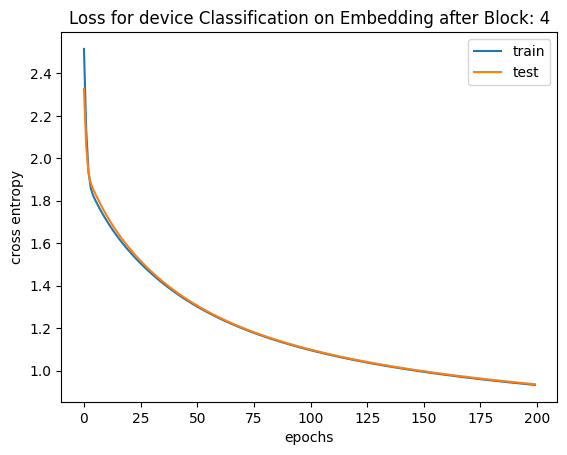

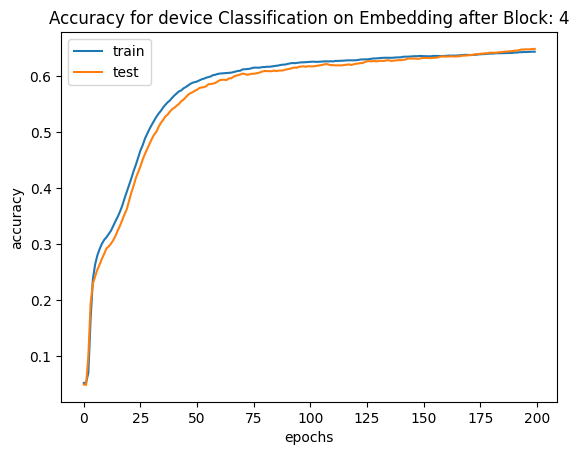

In [82]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [83]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [84]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [85]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [86]:
X_test=train_ready(test_data,col_name)

In [87]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

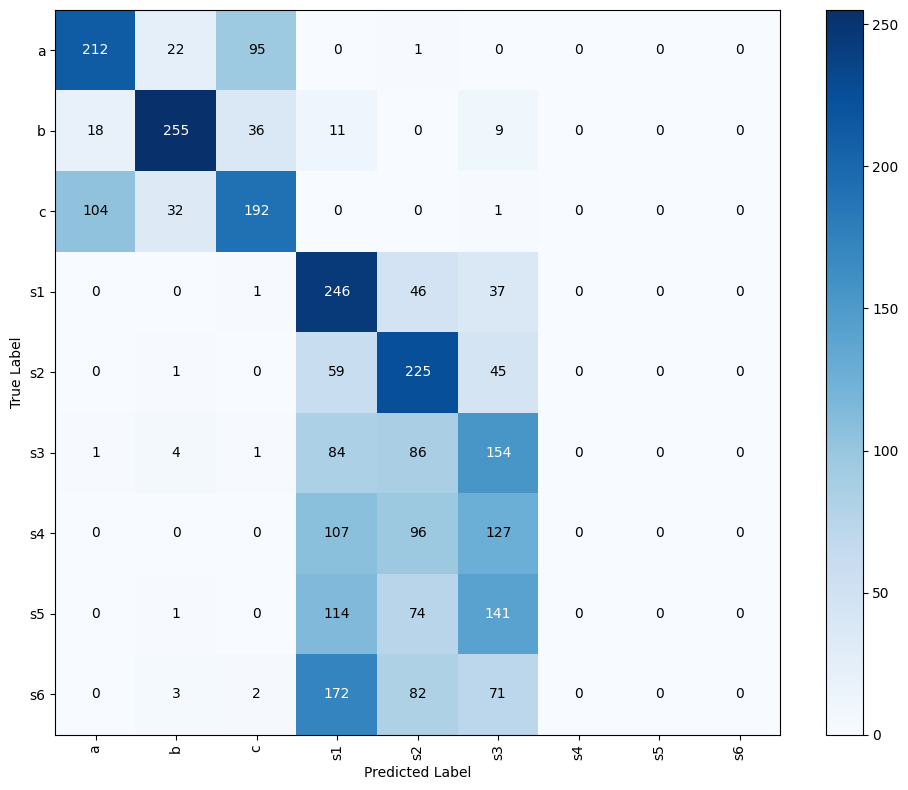

Accuracy: 0.4326


In [88]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-5

In [89]:
Block_number=5

In [90]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [91]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [92]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [93]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [94]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [95]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [96]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [97]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [98]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [99]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 520.86batch/s, acc=0.0391, loss=2.36]


Epoch 0 validation: Cross-entropy=2.37, Accuracy=4.9%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 347.58batch/s, acc=0.0703, loss=2.03]


Epoch 1 validation: Cross-entropy=2.06, Accuracy=6.4%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 488.70batch/s, acc=0.156, loss=1.86] 


Epoch 2 validation: Cross-entropy=1.91, Accuracy=15.8%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 523.06batch/s, acc=0.242, loss=1.8] 


Epoch 3 validation: Cross-entropy=1.85, Accuracy=23.1%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 524.76batch/s, acc=0.246, loss=1.78]


Epoch 4 validation: Cross-entropy=1.83, Accuracy=24.9%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 527.77batch/s, acc=0.254, loss=1.77]


Epoch 5 validation: Cross-entropy=1.81, Accuracy=25.8%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 233.73batch/s, acc=0.27, loss=1.76] 


Epoch 6 validation: Cross-entropy=1.79, Accuracy=26.5%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 496.44batch/s, acc=0.285, loss=1.75]


Epoch 7 validation: Cross-entropy=1.78, Accuracy=27.0%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 490.67batch/s, acc=0.285, loss=1.74]


Epoch 8 validation: Cross-entropy=1.76, Accuracy=27.0%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 496.90batch/s, acc=0.273, loss=1.73]


Epoch 9 validation: Cross-entropy=1.75, Accuracy=27.6%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 484.80batch/s, acc=0.266, loss=1.72]


Epoch 10 validation: Cross-entropy=1.73, Accuracy=27.3%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 527.08batch/s, acc=0.262, loss=1.71]


Epoch 11 validation: Cross-entropy=1.72, Accuracy=27.9%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 298.13batch/s, acc=0.258, loss=1.71]


Epoch 12 validation: Cross-entropy=1.71, Accuracy=28.5%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 548.41batch/s, acc=0.258, loss=1.7] 


Epoch 13 validation: Cross-entropy=1.69, Accuracy=28.6%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 502.48batch/s, acc=0.262, loss=1.69]


Epoch 14 validation: Cross-entropy=1.68, Accuracy=29.3%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 260.76batch/s, acc=0.27, loss=1.68] 


Epoch 15 validation: Cross-entropy=1.67, Accuracy=29.6%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 497.45batch/s, acc=0.266, loss=1.67]


Epoch 16 validation: Cross-entropy=1.66, Accuracy=29.8%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 317.55batch/s, acc=0.262, loss=1.67]


Epoch 17 validation: Cross-entropy=1.65, Accuracy=30.3%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 546.65batch/s, acc=0.262, loss=1.66]


Epoch 18 validation: Cross-entropy=1.64, Accuracy=31.1%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 514.93batch/s, acc=0.277, loss=1.65]


Epoch 19 validation: Cross-entropy=1.63, Accuracy=31.2%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 232.94batch/s, acc=0.277, loss=1.64]


Epoch 20 validation: Cross-entropy=1.62, Accuracy=31.6%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 593.65batch/s, acc=0.277, loss=1.64]


Epoch 21 validation: Cross-entropy=1.61, Accuracy=32.5%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 312.62batch/s, acc=0.285, loss=1.63]


Epoch 22 validation: Cross-entropy=1.60, Accuracy=32.5%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 553.55batch/s, acc=0.285, loss=1.62]


Epoch 23 validation: Cross-entropy=1.59, Accuracy=32.4%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 578.49batch/s, acc=0.305, loss=1.62]


Epoch 24 validation: Cross-entropy=1.59, Accuracy=32.9%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 308.89batch/s, acc=0.312, loss=1.61]


Epoch 25 validation: Cross-entropy=1.58, Accuracy=33.5%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 394.26batch/s, acc=0.316, loss=1.6] 


Epoch 26 validation: Cross-entropy=1.57, Accuracy=34.7%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 301.50batch/s, acc=0.332, loss=1.59]


Epoch 27 validation: Cross-entropy=1.56, Accuracy=35.5%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 332.74batch/s, acc=0.34, loss=1.59] 


Epoch 28 validation: Cross-entropy=1.55, Accuracy=36.1%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 474.61batch/s, acc=0.344, loss=1.58]


Epoch 29 validation: Cross-entropy=1.55, Accuracy=36.7%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 309.82batch/s, acc=0.348, loss=1.57]


Epoch 30 validation: Cross-entropy=1.54, Accuracy=37.3%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 435.88batch/s, acc=0.355, loss=1.57]


Epoch 31 validation: Cross-entropy=1.53, Accuracy=37.7%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 542.58batch/s, acc=0.355, loss=1.56]


Epoch 32 validation: Cross-entropy=1.52, Accuracy=38.2%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 263.73batch/s, acc=0.367, loss=1.55]


Epoch 33 validation: Cross-entropy=1.52, Accuracy=39.2%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 500.21batch/s, acc=0.379, loss=1.54]


Epoch 34 validation: Cross-entropy=1.51, Accuracy=39.6%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 573.27batch/s, acc=0.398, loss=1.54]


Epoch 35 validation: Cross-entropy=1.50, Accuracy=40.0%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 371.81batch/s, acc=0.41, loss=1.53] 


Epoch 36 validation: Cross-entropy=1.50, Accuracy=40.4%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 514.02batch/s, acc=0.41, loss=1.52] 


Epoch 37 validation: Cross-entropy=1.49, Accuracy=40.9%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 587.41batch/s, acc=0.41, loss=1.52] 


Epoch 38 validation: Cross-entropy=1.48, Accuracy=41.6%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 584.81batch/s, acc=0.426, loss=1.51]


Epoch 39 validation: Cross-entropy=1.48, Accuracy=42.0%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 575.32batch/s, acc=0.438, loss=1.5] 


Epoch 40 validation: Cross-entropy=1.47, Accuracy=42.6%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 339.28batch/s, acc=0.434, loss=1.5] 


Epoch 41 validation: Cross-entropy=1.46, Accuracy=43.3%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 360.73batch/s, acc=0.438, loss=1.49]


Epoch 42 validation: Cross-entropy=1.46, Accuracy=43.8%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 300.12batch/s, acc=0.441, loss=1.49]


Epoch 43 validation: Cross-entropy=1.45, Accuracy=44.3%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 500.58batch/s, acc=0.441, loss=1.48]


Epoch 44 validation: Cross-entropy=1.45, Accuracy=44.8%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 572.13batch/s, acc=0.445, loss=1.47]


Epoch 45 validation: Cross-entropy=1.44, Accuracy=45.1%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 318.85batch/s, acc=0.449, loss=1.47]


Epoch 46 validation: Cross-entropy=1.43, Accuracy=45.8%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 480.14batch/s, acc=0.457, loss=1.46]


Epoch 47 validation: Cross-entropy=1.43, Accuracy=46.1%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 518.48batch/s, acc=0.461, loss=1.46]


Epoch 48 validation: Cross-entropy=1.42, Accuracy=46.3%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 544.99batch/s, acc=0.469, loss=1.45]


Epoch 49 validation: Cross-entropy=1.42, Accuracy=46.8%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 330.74batch/s, acc=0.473, loss=1.45]


Epoch 50 validation: Cross-entropy=1.41, Accuracy=47.1%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 574.77batch/s, acc=0.48, loss=1.44] 


Epoch 51 validation: Cross-entropy=1.41, Accuracy=47.2%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 325.54batch/s, acc=0.484, loss=1.43]


Epoch 52 validation: Cross-entropy=1.40, Accuracy=47.5%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 294.40batch/s, acc=0.48, loss=1.43] 


Epoch 53 validation: Cross-entropy=1.40, Accuracy=47.9%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 558.94batch/s, acc=0.477, loss=1.42]


Epoch 54 validation: Cross-entropy=1.39, Accuracy=48.3%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 252.67batch/s, acc=0.473, loss=1.42]


Epoch 55 validation: Cross-entropy=1.39, Accuracy=48.7%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 525.57batch/s, acc=0.484, loss=1.41]


Epoch 56 validation: Cross-entropy=1.38, Accuracy=48.9%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 530.29batch/s, acc=0.488, loss=1.41]


Epoch 57 validation: Cross-entropy=1.38, Accuracy=49.2%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 275.64batch/s, acc=0.488, loss=1.4] 


Epoch 58 validation: Cross-entropy=1.37, Accuracy=49.4%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 463.73batch/s, acc=0.492, loss=1.4] 


Epoch 59 validation: Cross-entropy=1.37, Accuracy=49.8%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 574.66batch/s, acc=0.492, loss=1.39]


Epoch 60 validation: Cross-entropy=1.36, Accuracy=49.9%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 538.16batch/s, acc=0.5, loss=1.39]  


Epoch 61 validation: Cross-entropy=1.36, Accuracy=50.2%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 292.01batch/s, acc=0.504, loss=1.38]


Epoch 62 validation: Cross-entropy=1.35, Accuracy=50.5%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 467.36batch/s, acc=0.504, loss=1.38]


Epoch 63 validation: Cross-entropy=1.35, Accuracy=50.9%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 232.82batch/s, acc=0.504, loss=1.37]


Epoch 64 validation: Cross-entropy=1.34, Accuracy=51.1%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 509.92batch/s, acc=0.504, loss=1.37]


Epoch 65 validation: Cross-entropy=1.34, Accuracy=51.3%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 269.27batch/s, acc=0.508, loss=1.36]


Epoch 66 validation: Cross-entropy=1.33, Accuracy=51.7%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 467.50batch/s, acc=0.508, loss=1.36]


Epoch 67 validation: Cross-entropy=1.33, Accuracy=52.0%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 523.08batch/s, acc=0.508, loss=1.36]


Epoch 68 validation: Cross-entropy=1.32, Accuracy=52.2%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 313.21batch/s, acc=0.508, loss=1.35]


Epoch 69 validation: Cross-entropy=1.32, Accuracy=52.3%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 557.22batch/s, acc=0.508, loss=1.35]


Epoch 70 validation: Cross-entropy=1.32, Accuracy=52.5%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 323.66batch/s, acc=0.512, loss=1.34]


Epoch 71 validation: Cross-entropy=1.31, Accuracy=52.5%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 587.77batch/s, acc=0.512, loss=1.34]


Epoch 72 validation: Cross-entropy=1.31, Accuracy=52.8%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 547.25batch/s, acc=0.512, loss=1.33]


Epoch 73 validation: Cross-entropy=1.30, Accuracy=53.0%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 276.63batch/s, acc=0.512, loss=1.33]


Epoch 74 validation: Cross-entropy=1.30, Accuracy=53.2%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 375.43batch/s, acc=0.512, loss=1.33]


Epoch 75 validation: Cross-entropy=1.30, Accuracy=53.3%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 527.90batch/s, acc=0.512, loss=1.32]


Epoch 76 validation: Cross-entropy=1.29, Accuracy=53.3%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 567.14batch/s, acc=0.512, loss=1.32]


Epoch 77 validation: Cross-entropy=1.29, Accuracy=53.4%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 285.66batch/s, acc=0.516, loss=1.31]


Epoch 78 validation: Cross-entropy=1.28, Accuracy=53.5%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 550.18batch/s, acc=0.523, loss=1.31]


Epoch 79 validation: Cross-entropy=1.28, Accuracy=53.6%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 301.46batch/s, acc=0.527, loss=1.31]


Epoch 80 validation: Cross-entropy=1.28, Accuracy=53.8%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 544.12batch/s, acc=0.527, loss=1.3] 


Epoch 81 validation: Cross-entropy=1.27, Accuracy=54.0%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 349.21batch/s, acc=0.531, loss=1.3] 


Epoch 82 validation: Cross-entropy=1.27, Accuracy=54.1%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 385.24batch/s, acc=0.535, loss=1.29]


Epoch 83 validation: Cross-entropy=1.27, Accuracy=54.3%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 331.21batch/s, acc=0.535, loss=1.29]


Epoch 84 validation: Cross-entropy=1.26, Accuracy=54.3%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 508.91batch/s, acc=0.535, loss=1.29]


Epoch 85 validation: Cross-entropy=1.26, Accuracy=54.5%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 302.53batch/s, acc=0.535, loss=1.28]


Epoch 86 validation: Cross-entropy=1.26, Accuracy=54.6%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 553.34batch/s, acc=0.539, loss=1.28]


Epoch 87 validation: Cross-entropy=1.25, Accuracy=54.7%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 558.51batch/s, acc=0.539, loss=1.28]


Epoch 88 validation: Cross-entropy=1.25, Accuracy=54.8%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 308.75batch/s, acc=0.539, loss=1.27]


Epoch 89 validation: Cross-entropy=1.25, Accuracy=55.0%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 562.86batch/s, acc=0.539, loss=1.27]


Epoch 90 validation: Cross-entropy=1.24, Accuracy=55.0%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 591.55batch/s, acc=0.539, loss=1.27]


Epoch 91 validation: Cross-entropy=1.24, Accuracy=55.1%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 230.78batch/s, acc=0.539, loss=1.26]


Epoch 92 validation: Cross-entropy=1.24, Accuracy=55.3%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 568.95batch/s, acc=0.543, loss=1.26]


Epoch 93 validation: Cross-entropy=1.23, Accuracy=55.5%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 540.27batch/s, acc=0.543, loss=1.26]


Epoch 94 validation: Cross-entropy=1.23, Accuracy=55.5%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 580.22batch/s, acc=0.543, loss=1.25]


Epoch 95 validation: Cross-entropy=1.23, Accuracy=55.7%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 371.71batch/s, acc=0.547, loss=1.25]


Epoch 96 validation: Cross-entropy=1.22, Accuracy=55.8%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 472.01batch/s, acc=0.551, loss=1.25]


Epoch 97 validation: Cross-entropy=1.22, Accuracy=55.9%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 305.19batch/s, acc=0.555, loss=1.24]


Epoch 98 validation: Cross-entropy=1.22, Accuracy=56.1%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 560.10batch/s, acc=0.555, loss=1.24]


Epoch 99 validation: Cross-entropy=1.21, Accuracy=56.0%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 283.38batch/s, acc=0.555, loss=1.24]


Epoch 100 validation: Cross-entropy=1.21, Accuracy=56.2%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 470.10batch/s, acc=0.555, loss=1.23]


Epoch 101 validation: Cross-entropy=1.21, Accuracy=56.4%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 571.57batch/s, acc=0.555, loss=1.23]


Epoch 102 validation: Cross-entropy=1.21, Accuracy=56.5%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 305.19batch/s, acc=0.566, loss=1.23]


Epoch 103 validation: Cross-entropy=1.20, Accuracy=56.5%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 551.71batch/s, acc=0.566, loss=1.23]


Epoch 104 validation: Cross-entropy=1.20, Accuracy=56.7%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 324.04batch/s, acc=0.562, loss=1.22]


Epoch 105 validation: Cross-entropy=1.20, Accuracy=56.8%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 558.17batch/s, acc=0.566, loss=1.22]


Epoch 106 validation: Cross-entropy=1.20, Accuracy=57.0%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 354.78batch/s, acc=0.566, loss=1.22]


Epoch 107 validation: Cross-entropy=1.19, Accuracy=57.0%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 349.28batch/s, acc=0.566, loss=1.21]


Epoch 108 validation: Cross-entropy=1.19, Accuracy=57.2%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 470.60batch/s, acc=0.566, loss=1.21]


Epoch 109 validation: Cross-entropy=1.19, Accuracy=57.4%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 581.44batch/s, acc=0.566, loss=1.21]


Epoch 110 validation: Cross-entropy=1.18, Accuracy=57.5%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 326.32batch/s, acc=0.566, loss=1.21]


Epoch 111 validation: Cross-entropy=1.18, Accuracy=57.5%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 501.26batch/s, acc=0.566, loss=1.2] 


Epoch 112 validation: Cross-entropy=1.18, Accuracy=57.6%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 460.14batch/s, acc=0.566, loss=1.2] 


Epoch 113 validation: Cross-entropy=1.18, Accuracy=57.7%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 352.12batch/s, acc=0.566, loss=1.2] 


Epoch 114 validation: Cross-entropy=1.17, Accuracy=57.9%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 548.07batch/s, acc=0.566, loss=1.2] 


Epoch 115 validation: Cross-entropy=1.17, Accuracy=58.1%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 268.95batch/s, acc=0.566, loss=1.19]


Epoch 116 validation: Cross-entropy=1.17, Accuracy=58.1%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 446.84batch/s, acc=0.566, loss=1.19]


Epoch 117 validation: Cross-entropy=1.17, Accuracy=58.1%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 592.33batch/s, acc=0.566, loss=1.19]


Epoch 118 validation: Cross-entropy=1.17, Accuracy=58.3%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 283.61batch/s, acc=0.566, loss=1.18]


Epoch 119 validation: Cross-entropy=1.16, Accuracy=58.3%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 560.30batch/s, acc=0.566, loss=1.18]


Epoch 120 validation: Cross-entropy=1.16, Accuracy=58.3%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 551.45batch/s, acc=0.57, loss=1.18] 


Epoch 121 validation: Cross-entropy=1.16, Accuracy=58.3%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 342.22batch/s, acc=0.57, loss=1.18] 


Epoch 122 validation: Cross-entropy=1.16, Accuracy=58.4%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 576.48batch/s, acc=0.574, loss=1.18]


Epoch 123 validation: Cross-entropy=1.15, Accuracy=58.4%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 246.53batch/s, acc=0.574, loss=1.17]


Epoch 124 validation: Cross-entropy=1.15, Accuracy=58.5%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 530.39batch/s, acc=0.578, loss=1.17]


Epoch 125 validation: Cross-entropy=1.15, Accuracy=58.5%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 416.37batch/s, acc=0.578, loss=1.17]


Epoch 126 validation: Cross-entropy=1.15, Accuracy=58.6%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 401.17batch/s, acc=0.578, loss=1.17]


Epoch 127 validation: Cross-entropy=1.14, Accuracy=58.6%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 541.92batch/s, acc=0.578, loss=1.16]


Epoch 128 validation: Cross-entropy=1.14, Accuracy=58.7%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 581.49batch/s, acc=0.582, loss=1.16]


Epoch 129 validation: Cross-entropy=1.14, Accuracy=58.8%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 318.63batch/s, acc=0.582, loss=1.16]


Epoch 130 validation: Cross-entropy=1.14, Accuracy=58.8%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 345.88batch/s, acc=0.582, loss=1.16]


Epoch 131 validation: Cross-entropy=1.14, Accuracy=58.9%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 530.76batch/s, acc=0.586, loss=1.15]


Epoch 132 validation: Cross-entropy=1.13, Accuracy=59.0%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 290.88batch/s, acc=0.59, loss=1.15] 


Epoch 133 validation: Cross-entropy=1.13, Accuracy=59.0%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 556.03batch/s, acc=0.59, loss=1.15] 


Epoch 134 validation: Cross-entropy=1.13, Accuracy=59.1%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 585.03batch/s, acc=0.59, loss=1.15] 


Epoch 135 validation: Cross-entropy=1.13, Accuracy=59.1%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 373.90batch/s, acc=0.59, loss=1.15] 


Epoch 136 validation: Cross-entropy=1.13, Accuracy=59.1%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 414.56batch/s, acc=0.59, loss=1.14] 


Epoch 137 validation: Cross-entropy=1.12, Accuracy=59.1%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 359.13batch/s, acc=0.59, loss=1.14] 


Epoch 138 validation: Cross-entropy=1.12, Accuracy=59.2%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 563.53batch/s, acc=0.59, loss=1.14] 


Epoch 139 validation: Cross-entropy=1.12, Accuracy=59.2%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 518.66batch/s, acc=0.59, loss=1.14] 


Epoch 140 validation: Cross-entropy=1.12, Accuracy=59.3%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 310.31batch/s, acc=0.59, loss=1.14] 


Epoch 141 validation: Cross-entropy=1.12, Accuracy=59.3%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 537.96batch/s, acc=0.586, loss=1.13]


Epoch 142 validation: Cross-entropy=1.11, Accuracy=59.3%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 577.90batch/s, acc=0.59, loss=1.13] 


Epoch 143 validation: Cross-entropy=1.11, Accuracy=59.5%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 313.34batch/s, acc=0.59, loss=1.13] 


Epoch 144 validation: Cross-entropy=1.11, Accuracy=59.4%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 555.76batch/s, acc=0.59, loss=1.13] 


Epoch 145 validation: Cross-entropy=1.11, Accuracy=59.4%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 385.22batch/s, acc=0.59, loss=1.13] 


Epoch 146 validation: Cross-entropy=1.11, Accuracy=59.4%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 297.12batch/s, acc=0.59, loss=1.12] 


Epoch 147 validation: Cross-entropy=1.11, Accuracy=59.4%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 460.68batch/s, acc=0.59, loss=1.12] 


Epoch 148 validation: Cross-entropy=1.10, Accuracy=59.5%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 546.14batch/s, acc=0.594, loss=1.12]


Epoch 149 validation: Cross-entropy=1.10, Accuracy=59.5%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 319.24batch/s, acc=0.594, loss=1.12]


Epoch 150 validation: Cross-entropy=1.10, Accuracy=59.5%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 522.23batch/s, acc=0.598, loss=1.12]


Epoch 151 validation: Cross-entropy=1.10, Accuracy=59.6%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 581.62batch/s, acc=0.598, loss=1.11]


Epoch 152 validation: Cross-entropy=1.10, Accuracy=59.6%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 562.68batch/s, acc=0.598, loss=1.11]


Epoch 153 validation: Cross-entropy=1.09, Accuracy=59.7%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 242.88batch/s, acc=0.598, loss=1.11]


Epoch 154 validation: Cross-entropy=1.09, Accuracy=59.8%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 563.09batch/s, acc=0.598, loss=1.11]


Epoch 155 validation: Cross-entropy=1.09, Accuracy=59.8%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 538.63batch/s, acc=0.598, loss=1.11]


Epoch 156 validation: Cross-entropy=1.09, Accuracy=59.9%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 375.57batch/s, acc=0.598, loss=1.1] 


Epoch 157 validation: Cross-entropy=1.09, Accuracy=60.0%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 483.90batch/s, acc=0.598, loss=1.1] 


Epoch 158 validation: Cross-entropy=1.09, Accuracy=60.1%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 543.47batch/s, acc=0.594, loss=1.1]  


Epoch 159 validation: Cross-entropy=1.08, Accuracy=60.2%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 547.12batch/s, acc=0.594, loss=1.1]  


Epoch 160 validation: Cross-entropy=1.08, Accuracy=60.2%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 306.09batch/s, acc=0.602, loss=1.1]  


Epoch 161 validation: Cross-entropy=1.08, Accuracy=60.2%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 342.79batch/s, acc=0.602, loss=1.1]  


Epoch 162 validation: Cross-entropy=1.08, Accuracy=60.3%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 320.50batch/s, acc=0.602, loss=1.09] 


Epoch 163 validation: Cross-entropy=1.08, Accuracy=60.3%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 486.03batch/s, acc=0.602, loss=1.09] 


Epoch 164 validation: Cross-entropy=1.08, Accuracy=60.4%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 542.82batch/s, acc=0.602, loss=1.09] 


Epoch 165 validation: Cross-entropy=1.08, Accuracy=60.3%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 328.78batch/s, acc=0.602, loss=1.09] 


Epoch 166 validation: Cross-entropy=1.07, Accuracy=60.4%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 550.40batch/s, acc=0.602, loss=1.09] 


Epoch 167 validation: Cross-entropy=1.07, Accuracy=60.4%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 523.67batch/s, acc=0.602, loss=1.09] 


Epoch 168 validation: Cross-entropy=1.07, Accuracy=60.4%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 237.95batch/s, acc=0.602, loss=1.08] 


Epoch 169 validation: Cross-entropy=1.07, Accuracy=60.4%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 524.38batch/s, acc=0.602, loss=1.08] 


Epoch 170 validation: Cross-entropy=1.07, Accuracy=60.5%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 591.42batch/s, acc=0.602, loss=1.08] 


Epoch 171 validation: Cross-entropy=1.07, Accuracy=60.5%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 373.12batch/s, acc=0.602, loss=1.08] 


Epoch 172 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 425.66batch/s, acc=0.605, loss=1.08] 


Epoch 173 validation: Cross-entropy=1.06, Accuracy=60.5%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 500.86batch/s, acc=0.605, loss=1.08] 


Epoch 174 validation: Cross-entropy=1.06, Accuracy=60.7%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 400.70batch/s, acc=0.605, loss=1.07] 


Epoch 175 validation: Cross-entropy=1.06, Accuracy=60.7%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 416.95batch/s, acc=0.602, loss=1.07] 


Epoch 176 validation: Cross-entropy=1.06, Accuracy=60.8%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 369.77batch/s, acc=0.602, loss=1.07] 


Epoch 177 validation: Cross-entropy=1.06, Accuracy=60.8%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 514.26batch/s, acc=0.602, loss=1.07] 


Epoch 178 validation: Cross-entropy=1.06, Accuracy=60.8%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 299.93batch/s, acc=0.602, loss=1.07] 


Epoch 179 validation: Cross-entropy=1.05, Accuracy=60.8%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 541.90batch/s, acc=0.602, loss=1.07] 


Epoch 180 validation: Cross-entropy=1.05, Accuracy=60.8%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 572.29batch/s, acc=0.602, loss=1.07] 


Epoch 181 validation: Cross-entropy=1.05, Accuracy=60.8%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 557.60batch/s, acc=0.602, loss=1.06] 


Epoch 182 validation: Cross-entropy=1.05, Accuracy=60.8%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 320.28batch/s, acc=0.602, loss=1.06] 


Epoch 183 validation: Cross-entropy=1.05, Accuracy=60.9%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 528.62batch/s, acc=0.605, loss=1.06] 


Epoch 184 validation: Cross-entropy=1.05, Accuracy=61.0%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 539.72batch/s, acc=0.605, loss=1.06] 


Epoch 185 validation: Cross-entropy=1.05, Accuracy=61.0%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 545.82batch/s, acc=0.605, loss=1.06] 


Epoch 186 validation: Cross-entropy=1.05, Accuracy=61.0%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 232.93batch/s, acc=0.605, loss=1.06] 


Epoch 187 validation: Cross-entropy=1.04, Accuracy=61.1%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 582.47batch/s, acc=0.605, loss=1.06] 


Epoch 188 validation: Cross-entropy=1.04, Accuracy=61.1%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 316.49batch/s, acc=0.609, loss=1.05] 


Epoch 189 validation: Cross-entropy=1.04, Accuracy=61.1%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 524.15batch/s, acc=0.609, loss=1.05] 


Epoch 190 validation: Cross-entropy=1.04, Accuracy=61.0%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 588.96batch/s, acc=0.609, loss=1.05] 


Epoch 191 validation: Cross-entropy=1.04, Accuracy=61.2%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 540.84batch/s, acc=0.609, loss=1.05] 


Epoch 192 validation: Cross-entropy=1.04, Accuracy=61.3%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 297.31batch/s, acc=0.609, loss=1.05] 


Epoch 193 validation: Cross-entropy=1.04, Accuracy=61.3%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 353.27batch/s, acc=0.609, loss=1.05] 


Epoch 194 validation: Cross-entropy=1.03, Accuracy=61.3%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 295.14batch/s, acc=0.609, loss=1.05] 


Epoch 195 validation: Cross-entropy=1.03, Accuracy=61.3%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 499.81batch/s, acc=0.609, loss=1.04] 


Epoch 196 validation: Cross-entropy=1.03, Accuracy=61.3%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 306.49batch/s, acc=0.613, loss=1.04] 


Epoch 197 validation: Cross-entropy=1.03, Accuracy=61.3%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 546.52batch/s, acc=0.613, loss=1.04] 


Epoch 198 validation: Cross-entropy=1.03, Accuracy=61.3%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 566.98batch/s, acc=0.613, loss=1.04] 


Epoch 199 validation: Cross-entropy=1.03, Accuracy=61.3%


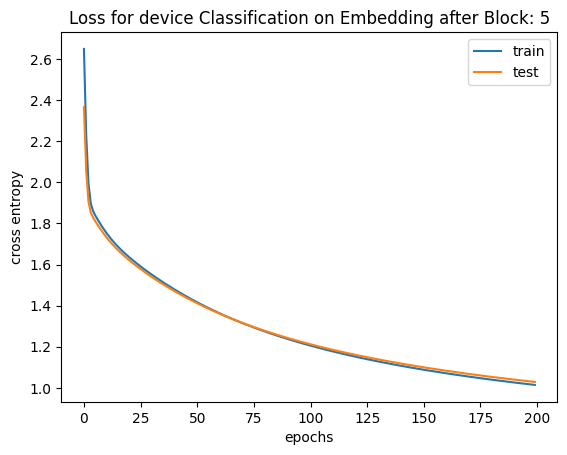

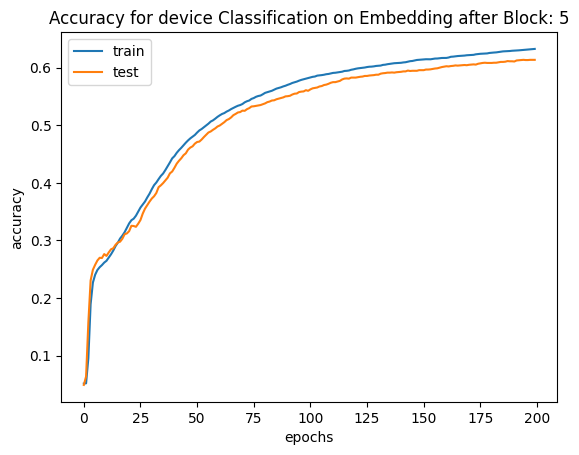

In [100]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [101]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [102]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [103]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [104]:
X_test=train_ready(test_data,col_name)

In [105]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

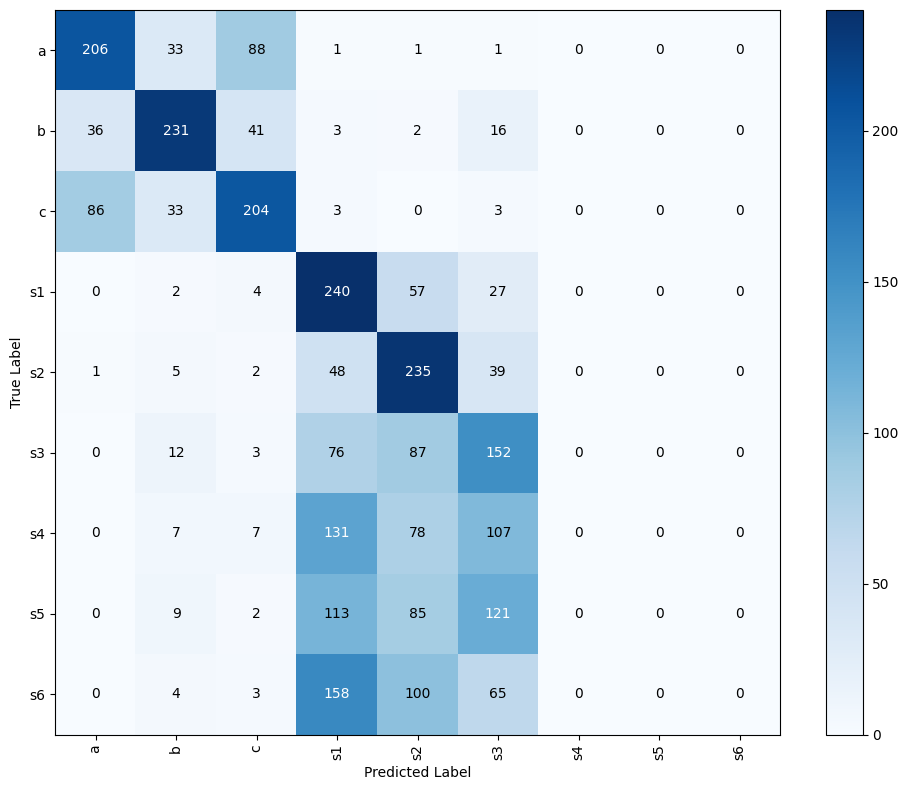

Accuracy: 0.4272


In [106]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-6

In [107]:
Block_number=6

In [108]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [109]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [110]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [111]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [112]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [113]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [114]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [115]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [116]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [117]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 564.05batch/s, acc=0.105, loss=2.23] 


Epoch 0 validation: Cross-entropy=2.47, Accuracy=9.3%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 351.79batch/s, acc=0.113, loss=2.05] 


Epoch 1 validation: Cross-entropy=2.23, Accuracy=9.3%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 490.12batch/s, acc=0.133, loss=1.93] 


Epoch 2 validation: Cross-entropy=2.05, Accuracy=11.4%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 603.49batch/s, acc=0.141, loss=1.86]


Epoch 3 validation: Cross-entropy=1.95, Accuracy=12.3%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 397.37batch/s, acc=0.125, loss=1.84]


Epoch 4 validation: Cross-entropy=1.91, Accuracy=12.9%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 559.41batch/s, acc=0.137, loss=1.82]


Epoch 5 validation: Cross-entropy=1.88, Accuracy=13.7%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 608.33batch/s, acc=0.148, loss=1.8] 


Epoch 6 validation: Cross-entropy=1.86, Accuracy=14.9%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 605.17batch/s, acc=0.172, loss=1.78]


Epoch 7 validation: Cross-entropy=1.84, Accuracy=16.5%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 611.59batch/s, acc=0.188, loss=1.77]


Epoch 8 validation: Cross-entropy=1.82, Accuracy=18.2%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 417.51batch/s, acc=0.215, loss=1.76]


Epoch 9 validation: Cross-entropy=1.80, Accuracy=20.1%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 406.57batch/s, acc=0.234, loss=1.74]


Epoch 10 validation: Cross-entropy=1.78, Accuracy=22.1%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 587.99batch/s, acc=0.266, loss=1.73]


Epoch 11 validation: Cross-entropy=1.77, Accuracy=24.3%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 616.51batch/s, acc=0.27, loss=1.72] 


Epoch 12 validation: Cross-entropy=1.75, Accuracy=27.1%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 620.02batch/s, acc=0.297, loss=1.71]


Epoch 13 validation: Cross-entropy=1.74, Accuracy=29.6%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 368.40batch/s, acc=0.336, loss=1.7] 


Epoch 14 validation: Cross-entropy=1.72, Accuracy=32.5%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 587.91batch/s, acc=0.367, loss=1.69]


Epoch 15 validation: Cross-entropy=1.71, Accuracy=34.6%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 384.61batch/s, acc=0.375, loss=1.67]


Epoch 16 validation: Cross-entropy=1.70, Accuracy=36.6%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 552.73batch/s, acc=0.406, loss=1.66]


Epoch 17 validation: Cross-entropy=1.69, Accuracy=39.1%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 576.24batch/s, acc=0.43, loss=1.65] 


Epoch 18 validation: Cross-entropy=1.68, Accuracy=41.1%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 435.84batch/s, acc=0.453, loss=1.64]


Epoch 19 validation: Cross-entropy=1.67, Accuracy=42.9%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 375.00batch/s, acc=0.469, loss=1.63]


Epoch 20 validation: Cross-entropy=1.65, Accuracy=44.7%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 421.94batch/s, acc=0.48, loss=1.62] 


Epoch 21 validation: Cross-entropy=1.64, Accuracy=46.0%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 609.98batch/s, acc=0.488, loss=1.61]


Epoch 22 validation: Cross-entropy=1.63, Accuracy=47.4%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 384.75batch/s, acc=0.508, loss=1.6] 


Epoch 23 validation: Cross-entropy=1.62, Accuracy=48.6%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 409.40batch/s, acc=0.508, loss=1.59]


Epoch 24 validation: Cross-entropy=1.61, Accuracy=49.7%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 349.03batch/s, acc=0.512, loss=1.58]


Epoch 25 validation: Cross-entropy=1.60, Accuracy=50.8%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 608.34batch/s, acc=0.523, loss=1.57]


Epoch 26 validation: Cross-entropy=1.60, Accuracy=51.4%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 372.51batch/s, acc=0.531, loss=1.56]


Epoch 27 validation: Cross-entropy=1.59, Accuracy=52.5%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 604.28batch/s, acc=0.543, loss=1.56]


Epoch 28 validation: Cross-entropy=1.58, Accuracy=53.3%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 365.34batch/s, acc=0.562, loss=1.55]


Epoch 29 validation: Cross-entropy=1.57, Accuracy=53.7%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 601.56batch/s, acc=0.582, loss=1.54]


Epoch 30 validation: Cross-entropy=1.56, Accuracy=54.2%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 386.69batch/s, acc=0.586, loss=1.53]


Epoch 31 validation: Cross-entropy=1.55, Accuracy=55.0%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 596.04batch/s, acc=0.59, loss=1.52] 


Epoch 32 validation: Cross-entropy=1.54, Accuracy=55.6%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 368.70batch/s, acc=0.598, loss=1.51]


Epoch 33 validation: Cross-entropy=1.53, Accuracy=56.2%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 613.30batch/s, acc=0.609, loss=1.5] 


Epoch 34 validation: Cross-entropy=1.53, Accuracy=56.9%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 380.08batch/s, acc=0.605, loss=1.49]


Epoch 35 validation: Cross-entropy=1.52, Accuracy=57.6%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 599.46batch/s, acc=0.609, loss=1.49]


Epoch 36 validation: Cross-entropy=1.51, Accuracy=58.1%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 386.87batch/s, acc=0.609, loss=1.48]


Epoch 37 validation: Cross-entropy=1.50, Accuracy=58.4%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 604.63batch/s, acc=0.617, loss=1.47]


Epoch 38 validation: Cross-entropy=1.50, Accuracy=58.6%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 365.57batch/s, acc=0.613, loss=1.46]


Epoch 39 validation: Cross-entropy=1.49, Accuracy=59.0%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 405.12batch/s, acc=0.625, loss=1.46]


Epoch 40 validation: Cross-entropy=1.48, Accuracy=59.3%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 367.86batch/s, acc=0.629, loss=1.45]


Epoch 41 validation: Cross-entropy=1.47, Accuracy=59.8%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 597.56batch/s, acc=0.629, loss=1.44]


Epoch 42 validation: Cross-entropy=1.47, Accuracy=59.9%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 376.07batch/s, acc=0.633, loss=1.43]


Epoch 43 validation: Cross-entropy=1.46, Accuracy=60.2%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 597.94batch/s, acc=0.633, loss=1.43]


Epoch 44 validation: Cross-entropy=1.45, Accuracy=60.3%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 435.87batch/s, acc=0.633, loss=1.42]


Epoch 45 validation: Cross-entropy=1.45, Accuracy=60.4%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 557.31batch/s, acc=0.633, loss=1.41]


Epoch 46 validation: Cross-entropy=1.44, Accuracy=60.9%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 463.48batch/s, acc=0.633, loss=1.41]


Epoch 47 validation: Cross-entropy=1.43, Accuracy=61.1%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 495.04batch/s, acc=0.629, loss=1.4] 


Epoch 48 validation: Cross-entropy=1.43, Accuracy=61.3%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 603.88batch/s, acc=0.629, loss=1.39]


Epoch 49 validation: Cross-entropy=1.42, Accuracy=61.5%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 366.39batch/s, acc=0.629, loss=1.39]


Epoch 50 validation: Cross-entropy=1.41, Accuracy=61.9%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 614.55batch/s, acc=0.629, loss=1.38]


Epoch 51 validation: Cross-entropy=1.41, Accuracy=62.0%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 377.20batch/s, acc=0.629, loss=1.37]


Epoch 52 validation: Cross-entropy=1.40, Accuracy=62.2%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 592.25batch/s, acc=0.633, loss=1.37]


Epoch 53 validation: Cross-entropy=1.40, Accuracy=62.3%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 365.90batch/s, acc=0.637, loss=1.36]


Epoch 54 validation: Cross-entropy=1.39, Accuracy=62.3%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 607.67batch/s, acc=0.637, loss=1.36]


Epoch 55 validation: Cross-entropy=1.39, Accuracy=62.5%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 387.47batch/s, acc=0.637, loss=1.35]


Epoch 56 validation: Cross-entropy=1.38, Accuracy=62.6%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 605.19batch/s, acc=0.637, loss=1.34]


Epoch 57 validation: Cross-entropy=1.37, Accuracy=62.7%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 388.23batch/s, acc=0.637, loss=1.34]


Epoch 58 validation: Cross-entropy=1.37, Accuracy=62.7%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 616.54batch/s, acc=0.637, loss=1.33]


Epoch 59 validation: Cross-entropy=1.36, Accuracy=62.6%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 384.08batch/s, acc=0.645, loss=1.33]


Epoch 60 validation: Cross-entropy=1.36, Accuracy=62.7%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 431.08batch/s, acc=0.645, loss=1.32]


Epoch 61 validation: Cross-entropy=1.35, Accuracy=62.7%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 379.76batch/s, acc=0.645, loss=1.32]


Epoch 62 validation: Cross-entropy=1.35, Accuracy=62.7%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 609.58batch/s, acc=0.648, loss=1.31]


Epoch 63 validation: Cross-entropy=1.34, Accuracy=62.8%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 404.88batch/s, acc=0.648, loss=1.31]


Epoch 64 validation: Cross-entropy=1.34, Accuracy=62.8%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 569.42batch/s, acc=0.648, loss=1.3] 


Epoch 65 validation: Cross-entropy=1.33, Accuracy=62.8%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 410.81batch/s, acc=0.645, loss=1.3] 


Epoch 66 validation: Cross-entropy=1.33, Accuracy=62.8%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 572.49batch/s, acc=0.641, loss=1.29]


Epoch 67 validation: Cross-entropy=1.32, Accuracy=62.9%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 346.80batch/s, acc=0.652, loss=1.29]


Epoch 68 validation: Cross-entropy=1.32, Accuracy=63.0%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 553.44batch/s, acc=0.652, loss=1.28]


Epoch 69 validation: Cross-entropy=1.31, Accuracy=63.1%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 607.59batch/s, acc=0.652, loss=1.28]


Epoch 70 validation: Cross-entropy=1.31, Accuracy=63.1%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 426.51batch/s, acc=0.648, loss=1.27]


Epoch 71 validation: Cross-entropy=1.30, Accuracy=63.2%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 602.05batch/s, acc=0.652, loss=1.27]


Epoch 72 validation: Cross-entropy=1.30, Accuracy=63.2%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 358.20batch/s, acc=0.652, loss=1.26]


Epoch 73 validation: Cross-entropy=1.30, Accuracy=63.3%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 617.12batch/s, acc=0.652, loss=1.26]


Epoch 74 validation: Cross-entropy=1.29, Accuracy=63.3%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 372.28batch/s, acc=0.652, loss=1.25]


Epoch 75 validation: Cross-entropy=1.29, Accuracy=63.4%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 584.41batch/s, acc=0.652, loss=1.25]


Epoch 76 validation: Cross-entropy=1.28, Accuracy=63.6%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 370.09batch/s, acc=0.656, loss=1.25]


Epoch 77 validation: Cross-entropy=1.28, Accuracy=63.6%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 613.38batch/s, acc=0.656, loss=1.24]


Epoch 78 validation: Cross-entropy=1.28, Accuracy=63.6%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 385.08batch/s, acc=0.66, loss=1.24] 


Epoch 79 validation: Cross-entropy=1.27, Accuracy=63.5%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 614.50batch/s, acc=0.656, loss=1.23]


Epoch 80 validation: Cross-entropy=1.27, Accuracy=63.4%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 271.11batch/s, acc=0.656, loss=1.23]


Epoch 81 validation: Cross-entropy=1.26, Accuracy=63.7%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 593.78batch/s, acc=0.656, loss=1.23]


Epoch 82 validation: Cross-entropy=1.26, Accuracy=63.9%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 376.65batch/s, acc=0.656, loss=1.22]


Epoch 83 validation: Cross-entropy=1.26, Accuracy=63.8%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 609.34batch/s, acc=0.648, loss=1.22]


Epoch 84 validation: Cross-entropy=1.25, Accuracy=63.8%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 389.87batch/s, acc=0.648, loss=1.21]


Epoch 85 validation: Cross-entropy=1.25, Accuracy=63.8%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 597.10batch/s, acc=0.648, loss=1.21]


Epoch 86 validation: Cross-entropy=1.24, Accuracy=63.9%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 397.70batch/s, acc=0.648, loss=1.21]


Epoch 87 validation: Cross-entropy=1.24, Accuracy=63.9%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 601.68batch/s, acc=0.648, loss=1.2] 


Epoch 88 validation: Cross-entropy=1.24, Accuracy=63.9%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 400.86batch/s, acc=0.648, loss=1.2] 


Epoch 89 validation: Cross-entropy=1.23, Accuracy=63.8%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 568.24batch/s, acc=0.648, loss=1.2] 


Epoch 90 validation: Cross-entropy=1.23, Accuracy=63.9%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 442.75batch/s, acc=0.648, loss=1.19]


Epoch 91 validation: Cross-entropy=1.23, Accuracy=63.8%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 548.74batch/s, acc=0.652, loss=1.19]


Epoch 92 validation: Cross-entropy=1.22, Accuracy=63.9%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 430.72batch/s, acc=0.652, loss=1.19]


Epoch 93 validation: Cross-entropy=1.22, Accuracy=63.9%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 515.65batch/s, acc=0.652, loss=1.18]


Epoch 94 validation: Cross-entropy=1.22, Accuracy=63.8%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 491.15batch/s, acc=0.652, loss=1.18]


Epoch 95 validation: Cross-entropy=1.21, Accuracy=63.8%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 463.71batch/s, acc=0.652, loss=1.18]


Epoch 96 validation: Cross-entropy=1.21, Accuracy=63.8%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 407.96batch/s, acc=0.652, loss=1.17]


Epoch 97 validation: Cross-entropy=1.21, Accuracy=63.9%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 546.05batch/s, acc=0.652, loss=1.17]


Epoch 98 validation: Cross-entropy=1.20, Accuracy=63.9%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 463.39batch/s, acc=0.652, loss=1.17]


Epoch 99 validation: Cross-entropy=1.20, Accuracy=64.0%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 479.07batch/s, acc=0.656, loss=1.16]


Epoch 100 validation: Cross-entropy=1.20, Accuracy=64.1%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 377.90batch/s, acc=0.656, loss=1.16]


Epoch 101 validation: Cross-entropy=1.19, Accuracy=64.1%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 435.61batch/s, acc=0.656, loss=1.16]


Epoch 102 validation: Cross-entropy=1.19, Accuracy=64.1%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 525.45batch/s, acc=0.656, loss=1.15]


Epoch 103 validation: Cross-entropy=1.19, Accuracy=64.1%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 443.96batch/s, acc=0.652, loss=1.15]


Epoch 104 validation: Cross-entropy=1.18, Accuracy=64.1%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 627.91batch/s, acc=0.656, loss=1.15]


Epoch 105 validation: Cross-entropy=1.18, Accuracy=64.0%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 385.27batch/s, acc=0.656, loss=1.14]


Epoch 106 validation: Cross-entropy=1.18, Accuracy=64.1%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 608.87batch/s, acc=0.656, loss=1.14]


Epoch 107 validation: Cross-entropy=1.18, Accuracy=64.2%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 383.18batch/s, acc=0.656, loss=1.14]


Epoch 108 validation: Cross-entropy=1.17, Accuracy=64.2%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 595.19batch/s, acc=0.656, loss=1.14]


Epoch 109 validation: Cross-entropy=1.17, Accuracy=64.1%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 367.36batch/s, acc=0.656, loss=1.13]


Epoch 110 validation: Cross-entropy=1.17, Accuracy=64.0%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 611.81batch/s, acc=0.656, loss=1.13]


Epoch 111 validation: Cross-entropy=1.16, Accuracy=64.1%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 375.07batch/s, acc=0.656, loss=1.13]


Epoch 112 validation: Cross-entropy=1.16, Accuracy=64.1%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 594.41batch/s, acc=0.656, loss=1.12]


Epoch 113 validation: Cross-entropy=1.16, Accuracy=64.2%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 367.46batch/s, acc=0.656, loss=1.12]


Epoch 114 validation: Cross-entropy=1.16, Accuracy=64.2%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 619.03batch/s, acc=0.664, loss=1.12]


Epoch 115 validation: Cross-entropy=1.15, Accuracy=64.3%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 402.07batch/s, acc=0.664, loss=1.12]


Epoch 116 validation: Cross-entropy=1.15, Accuracy=64.3%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 610.19batch/s, acc=0.668, loss=1.11]


Epoch 117 validation: Cross-entropy=1.15, Accuracy=64.3%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 478.49batch/s, acc=0.664, loss=1.11]


Epoch 118 validation: Cross-entropy=1.14, Accuracy=64.3%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 482.51batch/s, acc=0.664, loss=1.11]


Epoch 119 validation: Cross-entropy=1.14, Accuracy=64.4%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 444.63batch/s, acc=0.664, loss=1.11]


Epoch 120 validation: Cross-entropy=1.14, Accuracy=64.4%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 434.01batch/s, acc=0.664, loss=1.1] 


Epoch 121 validation: Cross-entropy=1.14, Accuracy=64.5%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 623.17batch/s, acc=0.66, loss=1.1]  


Epoch 122 validation: Cross-entropy=1.13, Accuracy=64.6%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 389.54batch/s, acc=0.66, loss=1.1]  


Epoch 123 validation: Cross-entropy=1.13, Accuracy=64.5%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 583.51batch/s, acc=0.66, loss=1.1]  


Epoch 124 validation: Cross-entropy=1.13, Accuracy=64.5%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 374.66batch/s, acc=0.66, loss=1.09] 


Epoch 125 validation: Cross-entropy=1.13, Accuracy=64.6%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 603.29batch/s, acc=0.66, loss=1.09] 


Epoch 126 validation: Cross-entropy=1.12, Accuracy=64.6%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 356.07batch/s, acc=0.66, loss=1.09] 


Epoch 127 validation: Cross-entropy=1.12, Accuracy=64.6%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 622.73batch/s, acc=0.66, loss=1.09] 


Epoch 128 validation: Cross-entropy=1.12, Accuracy=64.7%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 390.79batch/s, acc=0.66, loss=1.08] 


Epoch 129 validation: Cross-entropy=1.12, Accuracy=64.7%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 628.56batch/s, acc=0.66, loss=1.08] 


Epoch 130 validation: Cross-entropy=1.12, Accuracy=64.7%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 392.12batch/s, acc=0.66, loss=1.08] 


Epoch 131 validation: Cross-entropy=1.11, Accuracy=64.6%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 595.83batch/s, acc=0.66, loss=1.08] 


Epoch 132 validation: Cross-entropy=1.11, Accuracy=64.7%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 365.10batch/s, acc=0.664, loss=1.08]


Epoch 133 validation: Cross-entropy=1.11, Accuracy=64.7%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 607.23batch/s, acc=0.664, loss=1.07]


Epoch 134 validation: Cross-entropy=1.11, Accuracy=64.7%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 383.91batch/s, acc=0.664, loss=1.07]


Epoch 135 validation: Cross-entropy=1.10, Accuracy=64.7%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 609.44batch/s, acc=0.664, loss=1.07]


Epoch 136 validation: Cross-entropy=1.10, Accuracy=64.8%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 394.59batch/s, acc=0.664, loss=1.07]


Epoch 137 validation: Cross-entropy=1.10, Accuracy=64.7%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 602.11batch/s, acc=0.664, loss=1.06]


Epoch 138 validation: Cross-entropy=1.10, Accuracy=64.7%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 390.30batch/s, acc=0.664, loss=1.06]


Epoch 139 validation: Cross-entropy=1.10, Accuracy=64.6%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 401.34batch/s, acc=0.664, loss=1.06]


Epoch 140 validation: Cross-entropy=1.09, Accuracy=64.7%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 381.82batch/s, acc=0.668, loss=1.06]


Epoch 141 validation: Cross-entropy=1.09, Accuracy=64.6%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 603.38batch/s, acc=0.668, loss=1.06]


Epoch 142 validation: Cross-entropy=1.09, Accuracy=64.6%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 441.48batch/s, acc=0.668, loss=1.05]


Epoch 143 validation: Cross-entropy=1.09, Accuracy=64.6%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 556.05batch/s, acc=0.668, loss=1.05]


Epoch 144 validation: Cross-entropy=1.08, Accuracy=64.8%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 607.84batch/s, acc=0.668, loss=1.05]


Epoch 145 validation: Cross-entropy=1.08, Accuracy=64.9%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 391.02batch/s, acc=0.668, loss=1.05]


Epoch 146 validation: Cross-entropy=1.08, Accuracy=64.9%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 610.05batch/s, acc=0.668, loss=1.05]


Epoch 147 validation: Cross-entropy=1.08, Accuracy=64.9%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 391.53batch/s, acc=0.668, loss=1.04]


Epoch 148 validation: Cross-entropy=1.08, Accuracy=64.9%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 622.80batch/s, acc=0.668, loss=1.04]


Epoch 149 validation: Cross-entropy=1.07, Accuracy=64.9%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 394.79batch/s, acc=0.668, loss=1.04]


Epoch 150 validation: Cross-entropy=1.07, Accuracy=65.1%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 614.61batch/s, acc=0.668, loss=1.04]


Epoch 151 validation: Cross-entropy=1.07, Accuracy=65.1%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 381.56batch/s, acc=0.672, loss=1.04] 


Epoch 152 validation: Cross-entropy=1.07, Accuracy=65.1%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 622.75batch/s, acc=0.672, loss=1.04] 


Epoch 153 validation: Cross-entropy=1.07, Accuracy=65.2%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 398.98batch/s, acc=0.672, loss=1.03] 


Epoch 154 validation: Cross-entropy=1.07, Accuracy=65.3%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 611.19batch/s, acc=0.672, loss=1.03] 


Epoch 155 validation: Cross-entropy=1.06, Accuracy=65.4%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 410.99batch/s, acc=0.672, loss=1.03]


Epoch 156 validation: Cross-entropy=1.06, Accuracy=65.4%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 588.51batch/s, acc=0.672, loss=1.03] 


Epoch 157 validation: Cross-entropy=1.06, Accuracy=65.4%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 393.05batch/s, acc=0.672, loss=1.03] 


Epoch 158 validation: Cross-entropy=1.06, Accuracy=65.5%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 566.66batch/s, acc=0.672, loss=1.02] 


Epoch 159 validation: Cross-entropy=1.06, Accuracy=65.5%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 391.57batch/s, acc=0.672, loss=1.02] 


Epoch 160 validation: Cross-entropy=1.05, Accuracy=65.5%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 397.41batch/s, acc=0.672, loss=1.02] 


Epoch 161 validation: Cross-entropy=1.05, Accuracy=65.6%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 522.80batch/s, acc=0.672, loss=1.02] 


Epoch 162 validation: Cross-entropy=1.05, Accuracy=65.6%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 417.71batch/s, acc=0.672, loss=1.02] 


Epoch 163 validation: Cross-entropy=1.05, Accuracy=65.7%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 552.65batch/s, acc=0.672, loss=1.02] 


Epoch 164 validation: Cross-entropy=1.05, Accuracy=65.7%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 445.38batch/s, acc=0.672, loss=1.01] 


Epoch 165 validation: Cross-entropy=1.05, Accuracy=65.7%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 628.43batch/s, acc=0.672, loss=1.01] 


Epoch 166 validation: Cross-entropy=1.04, Accuracy=65.6%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 408.05batch/s, acc=0.672, loss=1.01] 


Epoch 167 validation: Cross-entropy=1.04, Accuracy=65.7%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 494.24batch/s, acc=0.668, loss=1.01] 


Epoch 168 validation: Cross-entropy=1.04, Accuracy=65.7%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 465.20batch/s, acc=0.668, loss=1.01] 


Epoch 169 validation: Cross-entropy=1.04, Accuracy=65.7%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 612.19batch/s, acc=0.668, loss=1.01] 


Epoch 170 validation: Cross-entropy=1.04, Accuracy=65.7%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 383.32batch/s, acc=0.672, loss=1]    


Epoch 171 validation: Cross-entropy=1.04, Accuracy=65.9%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 614.40batch/s, acc=0.672, loss=1]    


Epoch 172 validation: Cross-entropy=1.03, Accuracy=66.0%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 380.27batch/s, acc=0.672, loss=1]    


Epoch 173 validation: Cross-entropy=1.03, Accuracy=66.0%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 597.72batch/s, acc=0.68, loss=1]     


Epoch 174 validation: Cross-entropy=1.03, Accuracy=66.1%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 370.00batch/s, acc=0.68, loss=0.999] 


Epoch 175 validation: Cross-entropy=1.03, Accuracy=66.1%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 608.50batch/s, acc=0.68, loss=0.997] 


Epoch 176 validation: Cross-entropy=1.03, Accuracy=66.1%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 378.21batch/s, acc=0.688, loss=0.996]


Epoch 177 validation: Cross-entropy=1.03, Accuracy=66.1%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 597.91batch/s, acc=0.688, loss=0.994]


Epoch 178 validation: Cross-entropy=1.02, Accuracy=66.1%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 388.09batch/s, acc=0.688, loss=0.993]


Epoch 179 validation: Cross-entropy=1.02, Accuracy=66.1%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 612.83batch/s, acc=0.688, loss=0.991]


Epoch 180 validation: Cross-entropy=1.02, Accuracy=66.1%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 299.54batch/s, acc=0.688, loss=0.99] 


Epoch 181 validation: Cross-entropy=1.02, Accuracy=66.1%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 593.18batch/s, acc=0.688, loss=0.988]


Epoch 182 validation: Cross-entropy=1.02, Accuracy=66.2%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 383.61batch/s, acc=0.688, loss=0.987]


Epoch 183 validation: Cross-entropy=1.02, Accuracy=66.2%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 607.47batch/s, acc=0.688, loss=0.985]


Epoch 184 validation: Cross-entropy=1.02, Accuracy=66.2%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 392.07batch/s, acc=0.688, loss=0.984]


Epoch 185 validation: Cross-entropy=1.01, Accuracy=66.1%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 575.27batch/s, acc=0.688, loss=0.983]


Epoch 186 validation: Cross-entropy=1.01, Accuracy=66.2%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 398.63batch/s, acc=0.688, loss=0.981]


Epoch 187 validation: Cross-entropy=1.01, Accuracy=66.2%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 538.06batch/s, acc=0.688, loss=0.98] 


Epoch 188 validation: Cross-entropy=1.01, Accuracy=66.2%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 411.57batch/s, acc=0.688, loss=0.978]


Epoch 189 validation: Cross-entropy=1.01, Accuracy=66.2%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 587.19batch/s, acc=0.688, loss=0.977]


Epoch 190 validation: Cross-entropy=1.01, Accuracy=66.2%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 415.88batch/s, acc=0.688, loss=0.976]


Epoch 191 validation: Cross-entropy=1.01, Accuracy=66.2%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 559.84batch/s, acc=0.688, loss=0.974]


Epoch 192 validation: Cross-entropy=1.00, Accuracy=66.2%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 405.27batch/s, acc=0.691, loss=0.973]


Epoch 193 validation: Cross-entropy=1.00, Accuracy=66.2%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 573.73batch/s, acc=0.691, loss=0.972]


Epoch 194 validation: Cross-entropy=1.00, Accuracy=66.1%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 443.46batch/s, acc=0.691, loss=0.97] 


Epoch 195 validation: Cross-entropy=1.00, Accuracy=66.1%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 557.07batch/s, acc=0.691, loss=0.969]


Epoch 196 validation: Cross-entropy=1.00, Accuracy=66.1%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 470.09batch/s, acc=0.691, loss=0.968]


Epoch 197 validation: Cross-entropy=1.00, Accuracy=66.1%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 464.32batch/s, acc=0.691, loss=0.966]


Epoch 198 validation: Cross-entropy=1.00, Accuracy=66.2%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 488.10batch/s, acc=0.691, loss=0.965]


Epoch 199 validation: Cross-entropy=0.99, Accuracy=66.2%


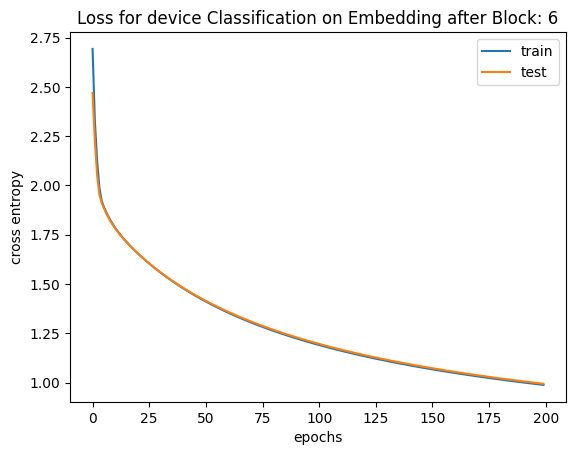

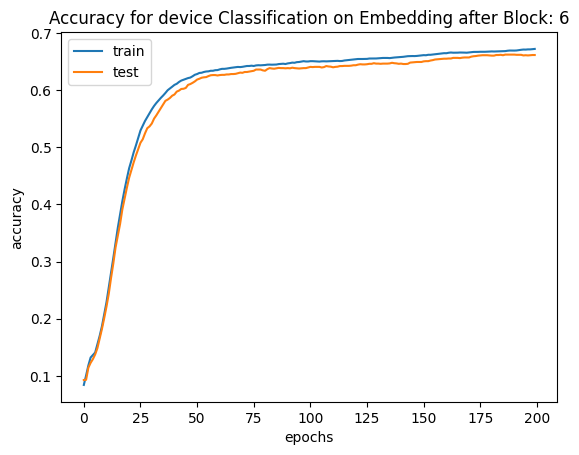

In [118]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [119]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [120]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [121]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [122]:
X_test=train_ready(test_data,col_name)

In [123]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


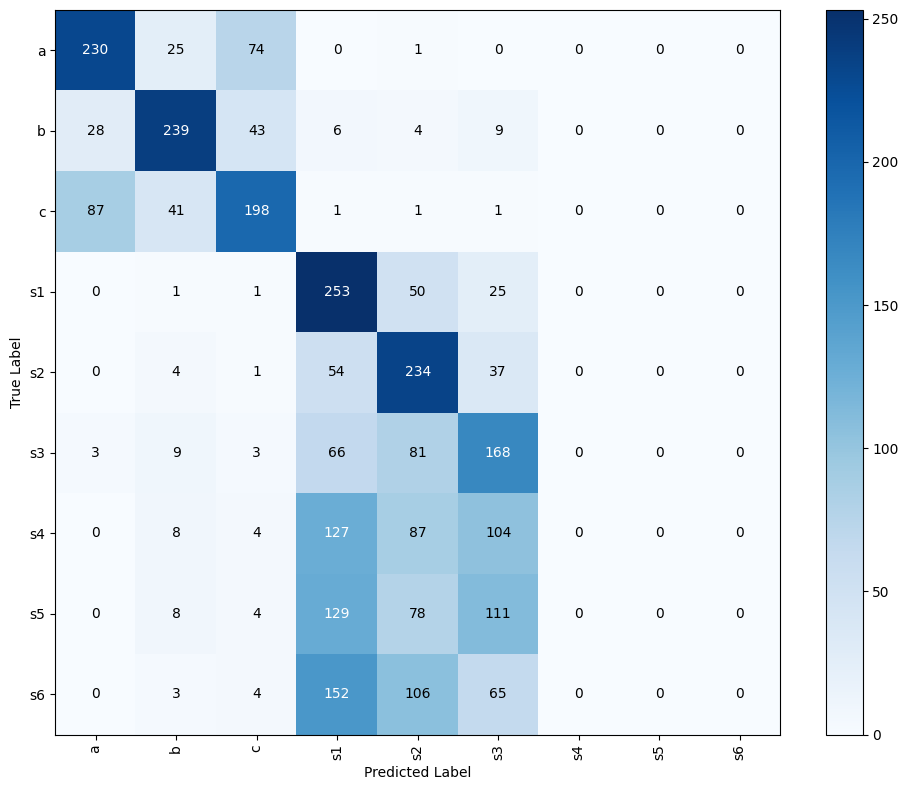

Accuracy: 0.4454


In [124]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-7

In [125]:
Block_number=7

In [126]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [127]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [128]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [129]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [130]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [131]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [132]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [133]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [134]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [135]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [136]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 554.24batch/s, acc=0.152, loss=2.07] 


Epoch 0 validation: Cross-entropy=2.12, Accuracy=14.5%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 337.10batch/s, acc=0.113, loss=1.95] 


Epoch 1 validation: Cross-entropy=1.96, Accuracy=12.3%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 557.37batch/s, acc=0.0977, loss=1.92]


Epoch 2 validation: Cross-entropy=1.90, Accuracy=12.1%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 580.56batch/s, acc=0.109, loss=1.88] 


Epoch 3 validation: Cross-entropy=1.86, Accuracy=13.4%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 352.24batch/s, acc=0.121, loss=1.84]


Epoch 4 validation: Cross-entropy=1.83, Accuracy=14.8%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 594.27batch/s, acc=0.152, loss=1.82]


Epoch 5 validation: Cross-entropy=1.80, Accuracy=16.3%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 605.85batch/s, acc=0.164, loss=1.79]


Epoch 6 validation: Cross-entropy=1.78, Accuracy=18.4%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 602.61batch/s, acc=0.184, loss=1.77]


Epoch 7 validation: Cross-entropy=1.76, Accuracy=21.2%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 604.33batch/s, acc=0.195, loss=1.75]


Epoch 8 validation: Cross-entropy=1.74, Accuracy=24.5%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 380.96batch/s, acc=0.242, loss=1.73]


Epoch 9 validation: Cross-entropy=1.72, Accuracy=26.2%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 601.43batch/s, acc=0.273, loss=1.72]


Epoch 10 validation: Cross-entropy=1.71, Accuracy=28.4%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 608.48batch/s, acc=0.297, loss=1.7] 


Epoch 11 validation: Cross-entropy=1.69, Accuracy=30.9%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 620.03batch/s, acc=0.312, loss=1.68]


Epoch 12 validation: Cross-entropy=1.68, Accuracy=33.6%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 598.99batch/s, acc=0.328, loss=1.67]


Epoch 13 validation: Cross-entropy=1.67, Accuracy=35.7%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 380.22batch/s, acc=0.348, loss=1.66]


Epoch 14 validation: Cross-entropy=1.66, Accuracy=37.6%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 619.85batch/s, acc=0.371, loss=1.64]


Epoch 15 validation: Cross-entropy=1.64, Accuracy=38.6%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 582.59batch/s, acc=0.391, loss=1.63]


Epoch 16 validation: Cross-entropy=1.63, Accuracy=40.4%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 312.95batch/s, acc=0.398, loss=1.62]


Epoch 17 validation: Cross-entropy=1.62, Accuracy=41.8%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 617.14batch/s, acc=0.414, loss=1.61]


Epoch 18 validation: Cross-entropy=1.61, Accuracy=42.6%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 386.16batch/s, acc=0.426, loss=1.59]


Epoch 19 validation: Cross-entropy=1.60, Accuracy=43.7%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 612.04batch/s, acc=0.449, loss=1.58]


Epoch 20 validation: Cross-entropy=1.59, Accuracy=44.8%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 355.02batch/s, acc=0.453, loss=1.57]


Epoch 21 validation: Cross-entropy=1.58, Accuracy=46.1%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 598.49batch/s, acc=0.445, loss=1.56]


Epoch 22 validation: Cross-entropy=1.57, Accuracy=47.4%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 367.87batch/s, acc=0.461, loss=1.55]


Epoch 23 validation: Cross-entropy=1.56, Accuracy=48.0%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 613.01batch/s, acc=0.473, loss=1.54]


Epoch 24 validation: Cross-entropy=1.55, Accuracy=49.1%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 368.59batch/s, acc=0.477, loss=1.53]


Epoch 25 validation: Cross-entropy=1.54, Accuracy=49.6%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 614.96batch/s, acc=0.488, loss=1.52]


Epoch 26 validation: Cross-entropy=1.53, Accuracy=50.2%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 278.53batch/s, acc=0.516, loss=1.51]


Epoch 27 validation: Cross-entropy=1.52, Accuracy=50.9%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 591.57batch/s, acc=0.516, loss=1.5] 


Epoch 28 validation: Cross-entropy=1.51, Accuracy=51.8%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 411.47batch/s, acc=0.52, loss=1.49] 


Epoch 29 validation: Cross-entropy=1.51, Accuracy=52.3%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 607.84batch/s, acc=0.531, loss=1.48]


Epoch 30 validation: Cross-entropy=1.50, Accuracy=53.2%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 389.75batch/s, acc=0.535, loss=1.47]


Epoch 31 validation: Cross-entropy=1.49, Accuracy=54.0%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 604.40batch/s, acc=0.543, loss=1.46]


Epoch 32 validation: Cross-entropy=1.48, Accuracy=54.5%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 368.09batch/s, acc=0.551, loss=1.45]


Epoch 33 validation: Cross-entropy=1.47, Accuracy=54.9%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 611.02batch/s, acc=0.562, loss=1.44]


Epoch 34 validation: Cross-entropy=1.47, Accuracy=55.2%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 384.92batch/s, acc=0.57, loss=1.43] 


Epoch 35 validation: Cross-entropy=1.46, Accuracy=55.8%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 591.64batch/s, acc=0.578, loss=1.43]


Epoch 36 validation: Cross-entropy=1.45, Accuracy=56.1%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 382.89batch/s, acc=0.586, loss=1.42]


Epoch 37 validation: Cross-entropy=1.44, Accuracy=56.6%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 600.21batch/s, acc=0.586, loss=1.41]


Epoch 38 validation: Cross-entropy=1.44, Accuracy=57.0%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 384.56batch/s, acc=0.582, loss=1.4] 


Epoch 39 validation: Cross-entropy=1.43, Accuracy=57.4%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 615.67batch/s, acc=0.59, loss=1.39] 


Epoch 40 validation: Cross-entropy=1.42, Accuracy=57.9%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 377.13batch/s, acc=0.598, loss=1.39]


Epoch 41 validation: Cross-entropy=1.42, Accuracy=58.4%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 592.50batch/s, acc=0.598, loss=1.38]


Epoch 42 validation: Cross-entropy=1.41, Accuracy=58.7%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 411.29batch/s, acc=0.602, loss=1.37]


Epoch 43 validation: Cross-entropy=1.40, Accuracy=59.0%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 582.66batch/s, acc=0.605, loss=1.36]


Epoch 44 validation: Cross-entropy=1.40, Accuracy=59.2%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 386.98batch/s, acc=0.613, loss=1.36]


Epoch 45 validation: Cross-entropy=1.39, Accuracy=59.7%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 388.29batch/s, acc=0.613, loss=1.35]


Epoch 46 validation: Cross-entropy=1.38, Accuracy=59.9%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 377.32batch/s, acc=0.613, loss=1.34]


Epoch 47 validation: Cross-entropy=1.38, Accuracy=60.2%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 576.03batch/s, acc=0.617, loss=1.34]


Epoch 48 validation: Cross-entropy=1.37, Accuracy=60.3%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 368.02batch/s, acc=0.617, loss=1.33]


Epoch 49 validation: Cross-entropy=1.36, Accuracy=60.8%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 617.75batch/s, acc=0.617, loss=1.32]


Epoch 50 validation: Cross-entropy=1.36, Accuracy=61.0%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 424.21batch/s, acc=0.617, loss=1.32]


Epoch 51 validation: Cross-entropy=1.35, Accuracy=61.3%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 556.41batch/s, acc=0.617, loss=1.31]


Epoch 52 validation: Cross-entropy=1.35, Accuracy=61.5%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 509.26batch/s, acc=0.621, loss=1.3] 


Epoch 53 validation: Cross-entropy=1.34, Accuracy=61.7%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 469.99batch/s, acc=0.621, loss=1.3] 


Epoch 54 validation: Cross-entropy=1.34, Accuracy=61.9%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 602.92batch/s, acc=0.629, loss=1.29]


Epoch 55 validation: Cross-entropy=1.33, Accuracy=62.0%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 406.63batch/s, acc=0.629, loss=1.29]


Epoch 56 validation: Cross-entropy=1.33, Accuracy=62.1%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 616.27batch/s, acc=0.629, loss=1.28]


Epoch 57 validation: Cross-entropy=1.32, Accuracy=62.1%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 380.88batch/s, acc=0.629, loss=1.28]


Epoch 58 validation: Cross-entropy=1.32, Accuracy=62.4%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 612.66batch/s, acc=0.633, loss=1.27]


Epoch 59 validation: Cross-entropy=1.31, Accuracy=62.5%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 366.24batch/s, acc=0.637, loss=1.26]


Epoch 60 validation: Cross-entropy=1.31, Accuracy=62.9%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 608.75batch/s, acc=0.641, loss=1.26]


Epoch 61 validation: Cross-entropy=1.30, Accuracy=63.0%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 368.15batch/s, acc=0.645, loss=1.25]


Epoch 62 validation: Cross-entropy=1.30, Accuracy=63.1%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 587.37batch/s, acc=0.645, loss=1.25]


Epoch 63 validation: Cross-entropy=1.29, Accuracy=63.2%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 368.75batch/s, acc=0.648, loss=1.24]


Epoch 64 validation: Cross-entropy=1.29, Accuracy=63.4%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 457.79batch/s, acc=0.648, loss=1.24]


Epoch 65 validation: Cross-entropy=1.28, Accuracy=63.5%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 311.69batch/s, acc=0.645, loss=1.23]


Epoch 66 validation: Cross-entropy=1.28, Accuracy=63.6%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 621.98batch/s, acc=0.645, loss=1.23]


Epoch 67 validation: Cross-entropy=1.27, Accuracy=63.7%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 387.55batch/s, acc=0.648, loss=1.22]


Epoch 68 validation: Cross-entropy=1.27, Accuracy=63.8%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 617.59batch/s, acc=0.652, loss=1.22]


Epoch 69 validation: Cross-entropy=1.27, Accuracy=63.9%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 400.23batch/s, acc=0.652, loss=1.21]


Epoch 70 validation: Cross-entropy=1.26, Accuracy=64.2%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 608.19batch/s, acc=0.656, loss=1.21]


Epoch 71 validation: Cross-entropy=1.26, Accuracy=64.4%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 410.38batch/s, acc=0.656, loss=1.21]


Epoch 72 validation: Cross-entropy=1.25, Accuracy=64.5%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 535.25batch/s, acc=0.656, loss=1.2] 


Epoch 73 validation: Cross-entropy=1.25, Accuracy=64.7%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 603.11batch/s, acc=0.66, loss=1.2]  


Epoch 74 validation: Cross-entropy=1.25, Accuracy=64.8%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 446.51batch/s, acc=0.664, loss=1.19]


Epoch 75 validation: Cross-entropy=1.24, Accuracy=64.8%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 612.70batch/s, acc=0.664, loss=1.19]


Epoch 76 validation: Cross-entropy=1.24, Accuracy=64.9%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 388.53batch/s, acc=0.66, loss=1.18] 


Epoch 77 validation: Cross-entropy=1.23, Accuracy=65.1%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 606.88batch/s, acc=0.66, loss=1.18] 


Epoch 78 validation: Cross-entropy=1.23, Accuracy=65.1%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 390.44batch/s, acc=0.66, loss=1.18] 


Epoch 79 validation: Cross-entropy=1.23, Accuracy=65.2%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 610.94batch/s, acc=0.66, loss=1.17] 


Epoch 80 validation: Cross-entropy=1.22, Accuracy=65.3%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 383.19batch/s, acc=0.664, loss=1.17]


Epoch 81 validation: Cross-entropy=1.22, Accuracy=65.4%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 605.42batch/s, acc=0.664, loss=1.16]


Epoch 82 validation: Cross-entropy=1.22, Accuracy=65.7%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 401.98batch/s, acc=0.664, loss=1.16]


Epoch 83 validation: Cross-entropy=1.21, Accuracy=65.8%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 601.39batch/s, acc=0.664, loss=1.16]


Epoch 84 validation: Cross-entropy=1.21, Accuracy=65.7%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 421.33batch/s, acc=0.664, loss=1.15]


Epoch 85 validation: Cross-entropy=1.20, Accuracy=65.8%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 380.36batch/s, acc=0.66, loss=1.15] 


Epoch 86 validation: Cross-entropy=1.20, Accuracy=66.0%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 387.44batch/s, acc=0.66, loss=1.15] 


Epoch 87 validation: Cross-entropy=1.20, Accuracy=66.1%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 607.44batch/s, acc=0.66, loss=1.14] 


Epoch 88 validation: Cross-entropy=1.19, Accuracy=66.1%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 388.14batch/s, acc=0.664, loss=1.14]


Epoch 89 validation: Cross-entropy=1.19, Accuracy=66.1%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 608.75batch/s, acc=0.664, loss=1.13]


Epoch 90 validation: Cross-entropy=1.19, Accuracy=66.2%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 358.52batch/s, acc=0.668, loss=1.13]


Epoch 91 validation: Cross-entropy=1.18, Accuracy=66.2%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 600.56batch/s, acc=0.668, loss=1.13]


Epoch 92 validation: Cross-entropy=1.18, Accuracy=66.3%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 410.74batch/s, acc=0.668, loss=1.12]


Epoch 93 validation: Cross-entropy=1.18, Accuracy=66.3%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 589.02batch/s, acc=0.668, loss=1.12]


Epoch 94 validation: Cross-entropy=1.18, Accuracy=66.5%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 373.35batch/s, acc=0.668, loss=1.12]


Epoch 95 validation: Cross-entropy=1.17, Accuracy=66.4%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 600.21batch/s, acc=0.668, loss=1.11]


Epoch 96 validation: Cross-entropy=1.17, Accuracy=66.6%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 379.81batch/s, acc=0.668, loss=1.11]


Epoch 97 validation: Cross-entropy=1.17, Accuracy=66.6%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 601.22batch/s, acc=0.668, loss=1.11]


Epoch 98 validation: Cross-entropy=1.16, Accuracy=66.6%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 407.61batch/s, acc=0.668, loss=1.1] 


Epoch 99 validation: Cross-entropy=1.16, Accuracy=66.6%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 579.02batch/s, acc=0.668, loss=1.1] 


Epoch 100 validation: Cross-entropy=1.16, Accuracy=66.7%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 409.19batch/s, acc=0.668, loss=1.1] 


Epoch 101 validation: Cross-entropy=1.15, Accuracy=66.8%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 562.01batch/s, acc=0.668, loss=1.1] 


Epoch 102 validation: Cross-entropy=1.15, Accuracy=67.0%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 397.78batch/s, acc=0.668, loss=1.09]


Epoch 103 validation: Cross-entropy=1.15, Accuracy=67.1%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 565.85batch/s, acc=0.672, loss=1.09]


Epoch 104 validation: Cross-entropy=1.15, Accuracy=67.2%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 295.45batch/s, acc=0.672, loss=1.09]


Epoch 105 validation: Cross-entropy=1.14, Accuracy=67.4%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 597.76batch/s, acc=0.672, loss=1.08]


Epoch 106 validation: Cross-entropy=1.14, Accuracy=67.5%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 359.77batch/s, acc=0.672, loss=1.08]


Epoch 107 validation: Cross-entropy=1.14, Accuracy=67.5%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 576.53batch/s, acc=0.672, loss=1.08]


Epoch 108 validation: Cross-entropy=1.14, Accuracy=67.5%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 371.89batch/s, acc=0.672, loss=1.08]


Epoch 109 validation: Cross-entropy=1.13, Accuracy=67.6%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 596.19batch/s, acc=0.672, loss=1.07]


Epoch 110 validation: Cross-entropy=1.13, Accuracy=67.6%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 385.38batch/s, acc=0.672, loss=1.07]


Epoch 111 validation: Cross-entropy=1.13, Accuracy=67.5%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 596.99batch/s, acc=0.668, loss=1.07]


Epoch 112 validation: Cross-entropy=1.13, Accuracy=67.5%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 427.79batch/s, acc=0.672, loss=1.06]


Epoch 113 validation: Cross-entropy=1.12, Accuracy=67.7%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 546.82batch/s, acc=0.68, loss=1.06] 


Epoch 114 validation: Cross-entropy=1.12, Accuracy=67.7%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 532.94batch/s, acc=0.672, loss=1.06]


Epoch 115 validation: Cross-entropy=1.12, Accuracy=67.7%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 466.74batch/s, acc=0.672, loss=1.06]


Epoch 116 validation: Cross-entropy=1.12, Accuracy=67.8%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 615.85batch/s, acc=0.676, loss=1.05]


Epoch 117 validation: Cross-entropy=1.11, Accuracy=67.9%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 392.04batch/s, acc=0.676, loss=1.05]


Epoch 118 validation: Cross-entropy=1.11, Accuracy=68.0%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 611.54batch/s, acc=0.672, loss=1.05]


Epoch 119 validation: Cross-entropy=1.11, Accuracy=68.0%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 391.62batch/s, acc=0.672, loss=1.05]


Epoch 120 validation: Cross-entropy=1.11, Accuracy=68.1%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 615.70batch/s, acc=0.672, loss=1.04]


Epoch 121 validation: Cross-entropy=1.10, Accuracy=68.1%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 367.63batch/s, acc=0.676, loss=1.04]


Epoch 122 validation: Cross-entropy=1.10, Accuracy=68.1%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 572.22batch/s, acc=0.676, loss=1.04]


Epoch 123 validation: Cross-entropy=1.10, Accuracy=68.2%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 376.74batch/s, acc=0.68, loss=1.04] 


Epoch 124 validation: Cross-entropy=1.10, Accuracy=68.2%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 614.50batch/s, acc=0.676, loss=1.03]


Epoch 125 validation: Cross-entropy=1.09, Accuracy=68.3%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 330.16batch/s, acc=0.68, loss=1.03] 


Epoch 126 validation: Cross-entropy=1.09, Accuracy=68.4%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 615.79batch/s, acc=0.68, loss=1.03] 


Epoch 127 validation: Cross-entropy=1.09, Accuracy=68.5%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 382.97batch/s, acc=0.68, loss=1.03] 


Epoch 128 validation: Cross-entropy=1.09, Accuracy=68.5%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 607.52batch/s, acc=0.68, loss=1.03]  


Epoch 129 validation: Cross-entropy=1.09, Accuracy=68.6%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 385.35batch/s, acc=0.68, loss=1.02]  


Epoch 130 validation: Cross-entropy=1.08, Accuracy=68.6%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 604.61batch/s, acc=0.68, loss=1.02]  


Epoch 131 validation: Cross-entropy=1.08, Accuracy=68.7%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 420.26batch/s, acc=0.68, loss=1.02]  


Epoch 132 validation: Cross-entropy=1.08, Accuracy=68.8%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 542.84batch/s, acc=0.68, loss=1.02] 


Epoch 133 validation: Cross-entropy=1.08, Accuracy=68.7%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 418.63batch/s, acc=0.68, loss=1.01]  


Epoch 134 validation: Cross-entropy=1.07, Accuracy=68.7%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 555.50batch/s, acc=0.68, loss=1.01]  


Epoch 135 validation: Cross-entropy=1.07, Accuracy=68.8%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 628.11batch/s, acc=0.68, loss=1.01]  


Epoch 136 validation: Cross-entropy=1.07, Accuracy=68.8%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 386.58batch/s, acc=0.684, loss=1.01] 


Epoch 137 validation: Cross-entropy=1.07, Accuracy=68.8%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 615.09batch/s, acc=0.688, loss=1.01] 


Epoch 138 validation: Cross-entropy=1.07, Accuracy=68.8%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 396.14batch/s, acc=0.688, loss=1]    


Epoch 139 validation: Cross-entropy=1.06, Accuracy=68.9%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 608.44batch/s, acc=0.688, loss=1]    


Epoch 140 validation: Cross-entropy=1.06, Accuracy=68.9%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 369.11batch/s, acc=0.691, loss=1]    


Epoch 141 validation: Cross-entropy=1.06, Accuracy=68.9%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 615.03batch/s, acc=0.691, loss=0.998]


Epoch 142 validation: Cross-entropy=1.06, Accuracy=68.9%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 369.94batch/s, acc=0.691, loss=0.996]


Epoch 143 validation: Cross-entropy=1.06, Accuracy=68.9%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 611.83batch/s, acc=0.691, loss=0.994]


Epoch 144 validation: Cross-entropy=1.05, Accuracy=68.9%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 293.20batch/s, acc=0.695, loss=0.992]


Epoch 145 validation: Cross-entropy=1.05, Accuracy=68.9%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 595.30batch/s, acc=0.695, loss=0.99] 


Epoch 146 validation: Cross-entropy=1.05, Accuracy=68.9%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 395.51batch/s, acc=0.695, loss=0.988]


Epoch 147 validation: Cross-entropy=1.05, Accuracy=69.0%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 621.00batch/s, acc=0.695, loss=0.987]


Epoch 148 validation: Cross-entropy=1.05, Accuracy=69.0%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 384.71batch/s, acc=0.695, loss=0.985]


Epoch 149 validation: Cross-entropy=1.05, Accuracy=69.0%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 612.50batch/s, acc=0.695, loss=0.983]


Epoch 150 validation: Cross-entropy=1.04, Accuracy=69.0%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 416.57batch/s, acc=0.695, loss=0.981]


Epoch 151 validation: Cross-entropy=1.04, Accuracy=69.0%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 590.52batch/s, acc=0.695, loss=0.979]


Epoch 152 validation: Cross-entropy=1.04, Accuracy=69.0%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 428.17batch/s, acc=0.695, loss=0.977]


Epoch 153 validation: Cross-entropy=1.04, Accuracy=69.0%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 555.50batch/s, acc=0.695, loss=0.976]


Epoch 154 validation: Cross-entropy=1.04, Accuracy=69.0%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 472.30batch/s, acc=0.695, loss=0.974]


Epoch 155 validation: Cross-entropy=1.04, Accuracy=69.1%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 493.16batch/s, acc=0.695, loss=0.972]


Epoch 156 validation: Cross-entropy=1.03, Accuracy=69.1%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 464.24batch/s, acc=0.695, loss=0.97] 


Epoch 157 validation: Cross-entropy=1.03, Accuracy=69.1%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 490.42batch/s, acc=0.695, loss=0.968]


Epoch 158 validation: Cross-entropy=1.03, Accuracy=69.1%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 520.98batch/s, acc=0.691, loss=0.967]


Epoch 159 validation: Cross-entropy=1.03, Accuracy=69.1%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 462.05batch/s, acc=0.691, loss=0.965]


Epoch 160 validation: Cross-entropy=1.03, Accuracy=69.1%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 602.22batch/s, acc=0.691, loss=0.963]


Epoch 161 validation: Cross-entropy=1.02, Accuracy=69.1%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 395.22batch/s, acc=0.691, loss=0.962]


Epoch 162 validation: Cross-entropy=1.02, Accuracy=69.1%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 624.83batch/s, acc=0.695, loss=0.96] 


Epoch 163 validation: Cross-entropy=1.02, Accuracy=69.1%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 368.07batch/s, acc=0.695, loss=0.958]


Epoch 164 validation: Cross-entropy=1.02, Accuracy=69.1%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 411.21batch/s, acc=0.695, loss=0.957]


Epoch 165 validation: Cross-entropy=1.02, Accuracy=69.1%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 384.56batch/s, acc=0.699, loss=0.955]


Epoch 166 validation: Cross-entropy=1.02, Accuracy=69.1%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 585.61batch/s, acc=0.699, loss=0.953]


Epoch 167 validation: Cross-entropy=1.02, Accuracy=69.1%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 373.69batch/s, acc=0.699, loss=0.952]


Epoch 168 validation: Cross-entropy=1.01, Accuracy=69.1%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 603.93batch/s, acc=0.699, loss=0.95] 


Epoch 169 validation: Cross-entropy=1.01, Accuracy=69.2%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 378.04batch/s, acc=0.699, loss=0.948]


Epoch 170 validation: Cross-entropy=1.01, Accuracy=69.3%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 603.38batch/s, acc=0.699, loss=0.947]


Epoch 171 validation: Cross-entropy=1.01, Accuracy=69.3%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 382.16batch/s, acc=0.699, loss=0.945]


Epoch 172 validation: Cross-entropy=1.01, Accuracy=69.3%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 609.82batch/s, acc=0.699, loss=0.944]


Epoch 173 validation: Cross-entropy=1.01, Accuracy=69.4%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 468.87batch/s, acc=0.699, loss=0.942]


Epoch 174 validation: Cross-entropy=1.00, Accuracy=69.3%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 510.90batch/s, acc=0.703, loss=0.941]


Epoch 175 validation: Cross-entropy=1.00, Accuracy=69.4%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 450.55batch/s, acc=0.703, loss=0.939]


Epoch 176 validation: Cross-entropy=1.00, Accuracy=69.4%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 512.73batch/s, acc=0.703, loss=0.938]


Epoch 177 validation: Cross-entropy=1.00, Accuracy=69.4%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 554.07batch/s, acc=0.703, loss=0.936]


Epoch 178 validation: Cross-entropy=1.00, Accuracy=69.3%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 379.67batch/s, acc=0.703, loss=0.935]


Epoch 179 validation: Cross-entropy=1.00, Accuracy=69.4%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 611.20batch/s, acc=0.703, loss=0.933]


Epoch 180 validation: Cross-entropy=1.00, Accuracy=69.4%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 374.58batch/s, acc=0.703, loss=0.932]


Epoch 181 validation: Cross-entropy=0.99, Accuracy=69.5%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 502.39batch/s, acc=0.703, loss=0.93] 


Epoch 182 validation: Cross-entropy=0.99, Accuracy=69.6%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 463.57batch/s, acc=0.703, loss=0.929]


Epoch 183 validation: Cross-entropy=0.99, Accuracy=69.6%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 503.54batch/s, acc=0.703, loss=0.927]


Epoch 184 validation: Cross-entropy=0.99, Accuracy=69.7%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 414.09batch/s, acc=0.703, loss=0.926]


Epoch 185 validation: Cross-entropy=0.99, Accuracy=69.8%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 548.69batch/s, acc=0.707, loss=0.924]


Epoch 186 validation: Cross-entropy=0.99, Accuracy=69.9%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 365.11batch/s, acc=0.707, loss=0.923]


Epoch 187 validation: Cross-entropy=0.99, Accuracy=69.9%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 601.44batch/s, acc=0.707, loss=0.922]


Epoch 188 validation: Cross-entropy=0.98, Accuracy=69.8%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 373.51batch/s, acc=0.707, loss=0.92] 


Epoch 189 validation: Cross-entropy=0.98, Accuracy=69.8%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 603.68batch/s, acc=0.707, loss=0.919]


Epoch 190 validation: Cross-entropy=0.98, Accuracy=69.8%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 375.05batch/s, acc=0.707, loss=0.917]


Epoch 191 validation: Cross-entropy=0.98, Accuracy=69.8%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 617.49batch/s, acc=0.707, loss=0.916]


Epoch 192 validation: Cross-entropy=0.98, Accuracy=69.9%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 393.78batch/s, acc=0.707, loss=0.915]


Epoch 193 validation: Cross-entropy=0.98, Accuracy=69.9%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 601.65batch/s, acc=0.707, loss=0.913]


Epoch 194 validation: Cross-entropy=0.98, Accuracy=69.8%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 399.02batch/s, acc=0.707, loss=0.912]


Epoch 195 validation: Cross-entropy=0.97, Accuracy=69.8%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 618.58batch/s, acc=0.707, loss=0.911]


Epoch 196 validation: Cross-entropy=0.97, Accuracy=69.8%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 384.48batch/s, acc=0.707, loss=0.909]


Epoch 197 validation: Cross-entropy=0.97, Accuracy=69.9%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 578.83batch/s, acc=0.707, loss=0.908]


Epoch 198 validation: Cross-entropy=0.97, Accuracy=70.0%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 375.73batch/s, acc=0.707, loss=0.907]


Epoch 199 validation: Cross-entropy=0.97, Accuracy=70.1%


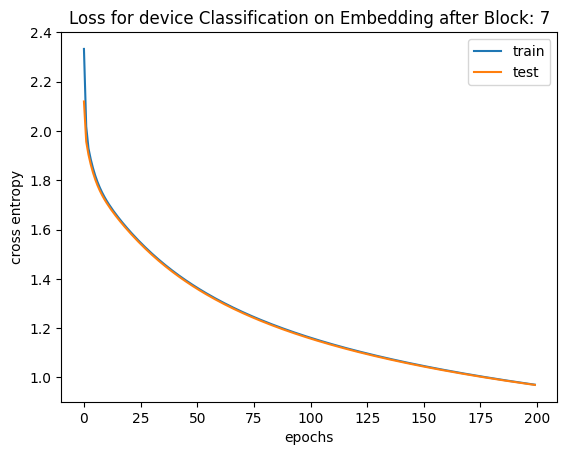

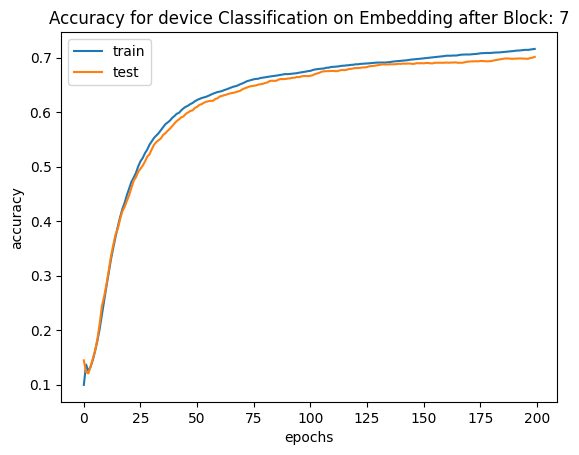

In [137]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [138]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [139]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [140]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [141]:
X_test=train_ready(test_data,col_name)

In [142]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


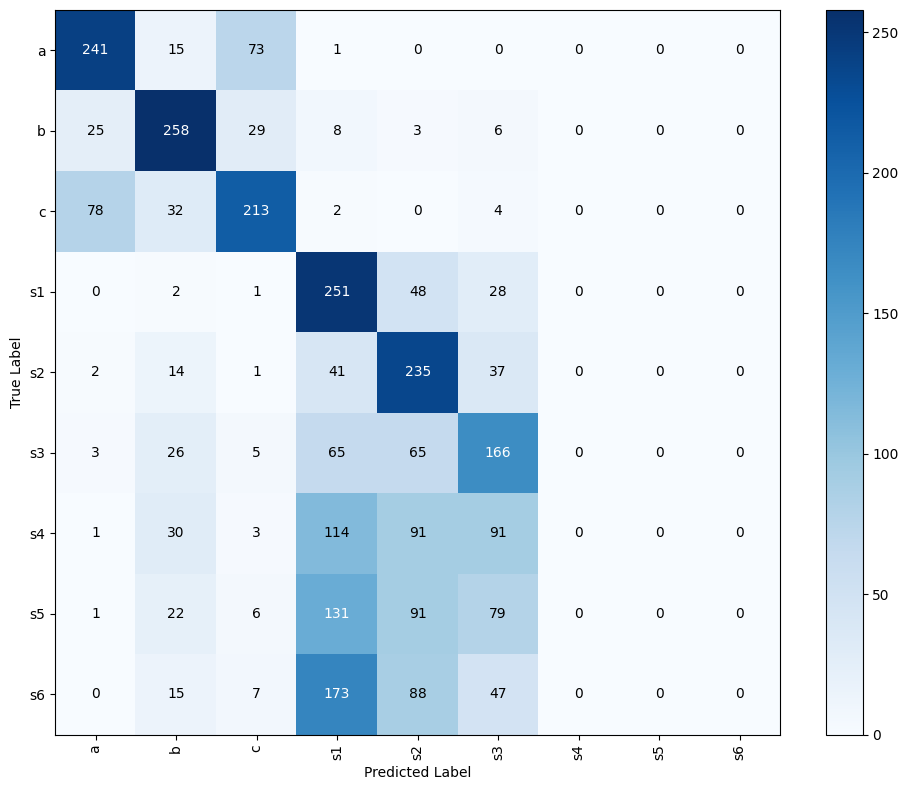

Accuracy: 0.4596


In [143]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-8

In [144]:
Block_number=8

In [145]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [146]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [147]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [148]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [149]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [150]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [151]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [152]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [153]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [154]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [155]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 313.21batch/s, acc=0.148, loss=2.11] 


Epoch 0 validation: Cross-entropy=2.13, Accuracy=13.4%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 499.55batch/s, acc=0.0781, loss=1.99]


Epoch 1 validation: Cross-entropy=1.99, Accuracy=11.8%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 349.40batch/s, acc=0.0898, loss=1.93]


Epoch 2 validation: Cross-entropy=1.93, Accuracy=11.1%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 540.11batch/s, acc=0.102, loss=1.89] 


Epoch 3 validation: Cross-entropy=1.89, Accuracy=11.7%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 298.85batch/s, acc=0.105, loss=1.86] 


Epoch 4 validation: Cross-entropy=1.85, Accuracy=13.5%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 513.27batch/s, acc=0.129, loss=1.83]


Epoch 5 validation: Cross-entropy=1.82, Accuracy=15.9%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 483.86batch/s, acc=0.156, loss=1.8] 


Epoch 6 validation: Cross-entropy=1.80, Accuracy=17.9%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 479.85batch/s, acc=0.172, loss=1.78]


Epoch 7 validation: Cross-entropy=1.78, Accuracy=20.4%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 425.48batch/s, acc=0.203, loss=1.76]


Epoch 8 validation: Cross-entropy=1.76, Accuracy=23.1%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 363.92batch/s, acc=0.207, loss=1.75]


Epoch 9 validation: Cross-entropy=1.75, Accuracy=24.7%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 494.07batch/s, acc=0.23, loss=1.73] 


Epoch 10 validation: Cross-entropy=1.73, Accuracy=27.6%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 528.25batch/s, acc=0.254, loss=1.72]


Epoch 11 validation: Cross-entropy=1.72, Accuracy=29.6%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 496.82batch/s, acc=0.297, loss=1.7] 


Epoch 12 validation: Cross-entropy=1.71, Accuracy=32.4%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 307.38batch/s, acc=0.312, loss=1.69]


Epoch 13 validation: Cross-entropy=1.70, Accuracy=34.8%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 491.36batch/s, acc=0.34, loss=1.68] 


Epoch 14 validation: Cross-entropy=1.68, Accuracy=37.2%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 286.59batch/s, acc=0.348, loss=1.67]


Epoch 15 validation: Cross-entropy=1.67, Accuracy=39.7%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 383.08batch/s, acc=0.367, loss=1.65]


Epoch 16 validation: Cross-entropy=1.66, Accuracy=42.0%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 316.56batch/s, acc=0.395, loss=1.64]


Epoch 17 validation: Cross-entropy=1.65, Accuracy=43.7%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 549.82batch/s, acc=0.402, loss=1.63]


Epoch 18 validation: Cross-entropy=1.64, Accuracy=45.3%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 278.49batch/s, acc=0.426, loss=1.62]


Epoch 19 validation: Cross-entropy=1.63, Accuracy=47.2%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 465.77batch/s, acc=0.434, loss=1.61]


Epoch 20 validation: Cross-entropy=1.62, Accuracy=48.9%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 270.00batch/s, acc=0.457, loss=1.6] 


Epoch 21 validation: Cross-entropy=1.61, Accuracy=51.0%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 321.77batch/s, acc=0.473, loss=1.59]


Epoch 22 validation: Cross-entropy=1.61, Accuracy=52.4%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 467.86batch/s, acc=0.492, loss=1.58]


Epoch 23 validation: Cross-entropy=1.60, Accuracy=53.5%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 339.00batch/s, acc=0.523, loss=1.57]


Epoch 24 validation: Cross-entropy=1.59, Accuracy=54.1%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 482.44batch/s, acc=0.531, loss=1.56]


Epoch 25 validation: Cross-entropy=1.58, Accuracy=55.3%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 289.39batch/s, acc=0.539, loss=1.55]


Epoch 26 validation: Cross-entropy=1.57, Accuracy=56.3%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 476.91batch/s, acc=0.547, loss=1.54]


Epoch 27 validation: Cross-entropy=1.56, Accuracy=56.7%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 521.45batch/s, acc=0.559, loss=1.53]


Epoch 28 validation: Cross-entropy=1.56, Accuracy=57.6%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 206.70batch/s, acc=0.562, loss=1.52]


Epoch 29 validation: Cross-entropy=1.55, Accuracy=58.4%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 385.68batch/s, acc=0.57, loss=1.52] 


Epoch 30 validation: Cross-entropy=1.54, Accuracy=59.0%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 187.75batch/s, acc=0.574, loss=1.51]


Epoch 31 validation: Cross-entropy=1.53, Accuracy=60.0%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 381.08batch/s, acc=0.602, loss=1.5] 


Epoch 32 validation: Cross-entropy=1.53, Accuracy=60.7%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 394.82batch/s, acc=0.605, loss=1.49]


Epoch 33 validation: Cross-entropy=1.52, Accuracy=61.0%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 277.69batch/s, acc=0.605, loss=1.48]


Epoch 34 validation: Cross-entropy=1.51, Accuracy=61.7%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 495.04batch/s, acc=0.605, loss=1.47]


Epoch 35 validation: Cross-entropy=1.51, Accuracy=62.1%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 400.70batch/s, acc=0.605, loss=1.47]


Epoch 36 validation: Cross-entropy=1.50, Accuracy=62.6%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 425.73batch/s, acc=0.613, loss=1.46]


Epoch 37 validation: Cross-entropy=1.49, Accuracy=62.6%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 559.18batch/s, acc=0.621, loss=1.45]


Epoch 38 validation: Cross-entropy=1.49, Accuracy=62.8%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 313.14batch/s, acc=0.621, loss=1.44]


Epoch 39 validation: Cross-entropy=1.48, Accuracy=63.2%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 515.51batch/s, acc=0.625, loss=1.44]


Epoch 40 validation: Cross-entropy=1.47, Accuracy=63.3%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 318.96batch/s, acc=0.629, loss=1.43]


Epoch 41 validation: Cross-entropy=1.47, Accuracy=63.7%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 424.98batch/s, acc=0.625, loss=1.42]


Epoch 42 validation: Cross-entropy=1.46, Accuracy=64.1%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 381.12batch/s, acc=0.621, loss=1.41]


Epoch 43 validation: Cross-entropy=1.46, Accuracy=64.6%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 307.93batch/s, acc=0.621, loss=1.41]


Epoch 44 validation: Cross-entropy=1.45, Accuracy=64.9%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 317.26batch/s, acc=0.621, loss=1.4] 


Epoch 45 validation: Cross-entropy=1.44, Accuracy=65.2%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 361.30batch/s, acc=0.625, loss=1.39]


Epoch 46 validation: Cross-entropy=1.44, Accuracy=65.4%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 533.35batch/s, acc=0.621, loss=1.39]


Epoch 47 validation: Cross-entropy=1.43, Accuracy=65.7%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 421.85batch/s, acc=0.625, loss=1.38]


Epoch 48 validation: Cross-entropy=1.43, Accuracy=65.8%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 531.49batch/s, acc=0.629, loss=1.38]


Epoch 49 validation: Cross-entropy=1.42, Accuracy=65.8%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 448.76batch/s, acc=0.637, loss=1.37]


Epoch 50 validation: Cross-entropy=1.42, Accuracy=65.9%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 410.61batch/s, acc=0.637, loss=1.36]


Epoch 51 validation: Cross-entropy=1.41, Accuracy=66.3%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 387.02batch/s, acc=0.637, loss=1.36]


Epoch 52 validation: Cross-entropy=1.41, Accuracy=66.4%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 458.37batch/s, acc=0.637, loss=1.35]


Epoch 53 validation: Cross-entropy=1.40, Accuracy=66.4%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 297.77batch/s, acc=0.637, loss=1.35]


Epoch 54 validation: Cross-entropy=1.40, Accuracy=66.5%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 526.75batch/s, acc=0.637, loss=1.34]


Epoch 55 validation: Cross-entropy=1.39, Accuracy=66.6%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 329.63batch/s, acc=0.645, loss=1.33]


Epoch 56 validation: Cross-entropy=1.39, Accuracy=66.7%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 524.92batch/s, acc=0.652, loss=1.33]


Epoch 57 validation: Cross-entropy=1.38, Accuracy=66.7%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 340.54batch/s, acc=0.66, loss=1.32] 


Epoch 58 validation: Cross-entropy=1.38, Accuracy=66.9%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 563.37batch/s, acc=0.66, loss=1.32] 


Epoch 59 validation: Cross-entropy=1.37, Accuracy=67.1%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 371.67batch/s, acc=0.66, loss=1.31] 


Epoch 60 validation: Cross-entropy=1.37, Accuracy=67.1%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 588.16batch/s, acc=0.66, loss=1.31] 


Epoch 61 validation: Cross-entropy=1.36, Accuracy=67.2%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 324.34batch/s, acc=0.66, loss=1.3]  


Epoch 62 validation: Cross-entropy=1.36, Accuracy=67.2%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 518.87batch/s, acc=0.66, loss=1.3]  


Epoch 63 validation: Cross-entropy=1.35, Accuracy=67.4%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 299.55batch/s, acc=0.668, loss=1.29]


Epoch 64 validation: Cross-entropy=1.35, Accuracy=67.5%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 345.24batch/s, acc=0.668, loss=1.29]


Epoch 65 validation: Cross-entropy=1.35, Accuracy=67.5%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 297.78batch/s, acc=0.668, loss=1.28]


Epoch 66 validation: Cross-entropy=1.34, Accuracy=67.6%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 427.68batch/s, acc=0.668, loss=1.28]


Epoch 67 validation: Cross-entropy=1.34, Accuracy=67.6%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 383.38batch/s, acc=0.668, loss=1.27]


Epoch 68 validation: Cross-entropy=1.33, Accuracy=67.6%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 429.35batch/s, acc=0.668, loss=1.27]


Epoch 69 validation: Cross-entropy=1.33, Accuracy=67.6%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 426.51batch/s, acc=0.668, loss=1.26]


Epoch 70 validation: Cross-entropy=1.33, Accuracy=67.6%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 376.29batch/s, acc=0.676, loss=1.26]


Epoch 71 validation: Cross-entropy=1.32, Accuracy=67.4%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 443.75batch/s, acc=0.676, loss=1.25]


Epoch 72 validation: Cross-entropy=1.32, Accuracy=67.5%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 409.29batch/s, acc=0.676, loss=1.25]


Epoch 73 validation: Cross-entropy=1.31, Accuracy=67.6%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 420.95batch/s, acc=0.676, loss=1.24]


Epoch 74 validation: Cross-entropy=1.31, Accuracy=67.6%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 420.86batch/s, acc=0.672, loss=1.24]


Epoch 75 validation: Cross-entropy=1.31, Accuracy=67.7%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 416.78batch/s, acc=0.672, loss=1.24]


Epoch 76 validation: Cross-entropy=1.30, Accuracy=67.7%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 363.78batch/s, acc=0.676, loss=1.23]


Epoch 77 validation: Cross-entropy=1.30, Accuracy=67.7%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 527.72batch/s, acc=0.68, loss=1.23] 


Epoch 78 validation: Cross-entropy=1.30, Accuracy=67.8%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 457.12batch/s, acc=0.68, loss=1.22] 


Epoch 79 validation: Cross-entropy=1.29, Accuracy=67.8%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 484.42batch/s, acc=0.68, loss=1.22] 


Epoch 80 validation: Cross-entropy=1.29, Accuracy=68.0%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 572.52batch/s, acc=0.684, loss=1.21]


Epoch 81 validation: Cross-entropy=1.28, Accuracy=68.1%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 312.64batch/s, acc=0.684, loss=1.21]


Epoch 82 validation: Cross-entropy=1.28, Accuracy=68.2%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 540.11batch/s, acc=0.688, loss=1.21]


Epoch 83 validation: Cross-entropy=1.28, Accuracy=68.3%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 320.23batch/s, acc=0.684, loss=1.2] 


Epoch 84 validation: Cross-entropy=1.27, Accuracy=68.3%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 330.99batch/s, acc=0.684, loss=1.2] 


Epoch 85 validation: Cross-entropy=1.27, Accuracy=68.3%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 377.92batch/s, acc=0.691, loss=1.19]


Epoch 86 validation: Cross-entropy=1.27, Accuracy=68.3%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 333.03batch/s, acc=0.691, loss=1.19]


Epoch 87 validation: Cross-entropy=1.26, Accuracy=68.5%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 512.95batch/s, acc=0.688, loss=1.19]


Epoch 88 validation: Cross-entropy=1.26, Accuracy=68.4%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 325.31batch/s, acc=0.684, loss=1.18]


Epoch 89 validation: Cross-entropy=1.26, Accuracy=68.6%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 531.99batch/s, acc=0.684, loss=1.18]


Epoch 90 validation: Cross-entropy=1.26, Accuracy=68.4%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 312.47batch/s, acc=0.684, loss=1.18]


Epoch 91 validation: Cross-entropy=1.25, Accuracy=68.4%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 506.99batch/s, acc=0.68, loss=1.17] 


Epoch 92 validation: Cross-entropy=1.25, Accuracy=68.5%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 297.69batch/s, acc=0.68, loss=1.17] 


Epoch 93 validation: Cross-entropy=1.25, Accuracy=68.5%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 490.56batch/s, acc=0.676, loss=1.17]


Epoch 94 validation: Cross-entropy=1.24, Accuracy=68.5%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 322.39batch/s, acc=0.68, loss=1.16] 


Epoch 95 validation: Cross-entropy=1.24, Accuracy=68.6%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 518.20batch/s, acc=0.676, loss=1.16]


Epoch 96 validation: Cross-entropy=1.24, Accuracy=68.7%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 354.63batch/s, acc=0.672, loss=1.16]


Epoch 97 validation: Cross-entropy=1.23, Accuracy=68.8%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 530.86batch/s, acc=0.672, loss=1.15]


Epoch 98 validation: Cross-entropy=1.23, Accuracy=68.8%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 370.83batch/s, acc=0.672, loss=1.15]


Epoch 99 validation: Cross-entropy=1.23, Accuracy=68.7%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 590.81batch/s, acc=0.676, loss=1.15]


Epoch 100 validation: Cross-entropy=1.23, Accuracy=68.6%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 380.86batch/s, acc=0.676, loss=1.14]


Epoch 101 validation: Cross-entropy=1.22, Accuracy=68.6%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 598.28batch/s, acc=0.68, loss=1.14] 


Epoch 102 validation: Cross-entropy=1.22, Accuracy=68.6%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 317.91batch/s, acc=0.68, loss=1.14] 


Epoch 103 validation: Cross-entropy=1.22, Accuracy=68.7%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 584.60batch/s, acc=0.684, loss=1.13]


Epoch 104 validation: Cross-entropy=1.22, Accuracy=68.7%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 569.05batch/s, acc=0.684, loss=1.13]


Epoch 105 validation: Cross-entropy=1.21, Accuracy=68.8%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 218.69batch/s, acc=0.684, loss=1.13]


Epoch 106 validation: Cross-entropy=1.21, Accuracy=68.8%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 518.68batch/s, acc=0.684, loss=1.12]


Epoch 107 validation: Cross-entropy=1.21, Accuracy=68.9%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 294.58batch/s, acc=0.688, loss=1.12]


Epoch 108 validation: Cross-entropy=1.20, Accuracy=69.0%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 477.96batch/s, acc=0.691, loss=1.12]


Epoch 109 validation: Cross-entropy=1.20, Accuracy=69.0%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 301.10batch/s, acc=0.691, loss=1.11]


Epoch 110 validation: Cross-entropy=1.20, Accuracy=69.0%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 533.08batch/s, acc=0.695, loss=1.11]


Epoch 111 validation: Cross-entropy=1.20, Accuracy=69.0%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 336.85batch/s, acc=0.695, loss=1.11]


Epoch 112 validation: Cross-entropy=1.19, Accuracy=69.0%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 491.71batch/s, acc=0.695, loss=1.11]


Epoch 113 validation: Cross-entropy=1.19, Accuracy=69.0%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 313.62batch/s, acc=0.695, loss=1.1] 


Epoch 114 validation: Cross-entropy=1.19, Accuracy=69.0%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 527.71batch/s, acc=0.695, loss=1.1] 


Epoch 115 validation: Cross-entropy=1.19, Accuracy=69.1%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 316.36batch/s, acc=0.695, loss=1.1] 


Epoch 116 validation: Cross-entropy=1.18, Accuracy=69.1%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 527.73batch/s, acc=0.691, loss=1.1] 


Epoch 117 validation: Cross-entropy=1.18, Accuracy=69.1%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 306.02batch/s, acc=0.691, loss=1.09]


Epoch 118 validation: Cross-entropy=1.18, Accuracy=69.1%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 394.41batch/s, acc=0.691, loss=1.09]


Epoch 119 validation: Cross-entropy=1.18, Accuracy=69.1%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 422.99batch/s, acc=0.691, loss=1.09]


Epoch 120 validation: Cross-entropy=1.18, Accuracy=69.2%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 286.67batch/s, acc=0.691, loss=1.08]


Epoch 121 validation: Cross-entropy=1.17, Accuracy=69.2%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 524.32batch/s, acc=0.695, loss=1.08]


Epoch 122 validation: Cross-entropy=1.17, Accuracy=69.3%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 397.56batch/s, acc=0.695, loss=1.08]


Epoch 123 validation: Cross-entropy=1.17, Accuracy=69.3%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 508.16batch/s, acc=0.695, loss=1.08]


Epoch 124 validation: Cross-entropy=1.17, Accuracy=69.3%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 501.21batch/s, acc=0.691, loss=1.07]


Epoch 125 validation: Cross-entropy=1.16, Accuracy=69.4%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 298.36batch/s, acc=0.691, loss=1.07]


Epoch 126 validation: Cross-entropy=1.16, Accuracy=69.3%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 277.81batch/s, acc=0.691, loss=1.07]


Epoch 127 validation: Cross-entropy=1.16, Accuracy=69.4%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 472.18batch/s, acc=0.691, loss=1.07]


Epoch 128 validation: Cross-entropy=1.16, Accuracy=69.3%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 320.60batch/s, acc=0.691, loss=1.06]


Epoch 129 validation: Cross-entropy=1.16, Accuracy=69.3%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 455.03batch/s, acc=0.691, loss=1.06]


Epoch 130 validation: Cross-entropy=1.15, Accuracy=69.4%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 531.25batch/s, acc=0.691, loss=1.06]


Epoch 131 validation: Cross-entropy=1.15, Accuracy=69.4%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 516.04batch/s, acc=0.691, loss=1.06]


Epoch 132 validation: Cross-entropy=1.15, Accuracy=69.5%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 183.12batch/s, acc=0.691, loss=1.06]


Epoch 133 validation: Cross-entropy=1.15, Accuracy=69.4%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 375.47batch/s, acc=0.691, loss=1.05]


Epoch 134 validation: Cross-entropy=1.15, Accuracy=69.4%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 190.09batch/s, acc=0.691, loss=1.05]


Epoch 135 validation: Cross-entropy=1.14, Accuracy=69.4%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 432.73batch/s, acc=0.695, loss=1.05]


Epoch 136 validation: Cross-entropy=1.14, Accuracy=69.4%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 488.06batch/s, acc=0.699, loss=1.05]


Epoch 137 validation: Cross-entropy=1.14, Accuracy=69.4%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 284.37batch/s, acc=0.699, loss=1.04]


Epoch 138 validation: Cross-entropy=1.14, Accuracy=69.4%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 526.76batch/s, acc=0.699, loss=1.04]


Epoch 139 validation: Cross-entropy=1.14, Accuracy=69.4%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 534.62batch/s, acc=0.703, loss=1.04]


Epoch 140 validation: Cross-entropy=1.13, Accuracy=69.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 514.01batch/s, acc=0.703, loss=1.04]


Epoch 141 validation: Cross-entropy=1.13, Accuracy=69.5%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 341.99batch/s, acc=0.703, loss=1.03]


Epoch 142 validation: Cross-entropy=1.13, Accuracy=69.4%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 519.27batch/s, acc=0.703, loss=1.03]


Epoch 143 validation: Cross-entropy=1.13, Accuracy=69.5%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 326.88batch/s, acc=0.703, loss=1.03]


Epoch 144 validation: Cross-entropy=1.13, Accuracy=69.5%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 531.28batch/s, acc=0.703, loss=1.03]


Epoch 145 validation: Cross-entropy=1.12, Accuracy=69.5%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 345.82batch/s, acc=0.703, loss=1.03]


Epoch 146 validation: Cross-entropy=1.12, Accuracy=69.5%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 496.53batch/s, acc=0.703, loss=1.02]


Epoch 147 validation: Cross-entropy=1.12, Accuracy=69.5%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 327.66batch/s, acc=0.703, loss=1.02]


Epoch 148 validation: Cross-entropy=1.12, Accuracy=69.5%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 359.36batch/s, acc=0.699, loss=1.02]


Epoch 149 validation: Cross-entropy=1.12, Accuracy=69.5%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 344.47batch/s, acc=0.699, loss=1.02]


Epoch 150 validation: Cross-entropy=1.11, Accuracy=69.6%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 553.72batch/s, acc=0.699, loss=1.02]


Epoch 151 validation: Cross-entropy=1.11, Accuracy=69.5%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 349.74batch/s, acc=0.699, loss=1.01]


Epoch 152 validation: Cross-entropy=1.11, Accuracy=69.6%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 569.14batch/s, acc=0.699, loss=1.01]


Epoch 153 validation: Cross-entropy=1.11, Accuracy=69.6%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 386.82batch/s, acc=0.695, loss=1.01]


Epoch 154 validation: Cross-entropy=1.11, Accuracy=69.6%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 538.43batch/s, acc=0.695, loss=1.01]


Epoch 155 validation: Cross-entropy=1.11, Accuracy=69.6%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 378.10batch/s, acc=0.695, loss=1.01]


Epoch 156 validation: Cross-entropy=1.10, Accuracy=69.6%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 465.86batch/s, acc=0.695, loss=1]   


Epoch 157 validation: Cross-entropy=1.10, Accuracy=69.6%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 327.59batch/s, acc=0.699, loss=1]   


Epoch 158 validation: Cross-entropy=1.10, Accuracy=69.6%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 486.49batch/s, acc=0.695, loss=1]   


Epoch 159 validation: Cross-entropy=1.10, Accuracy=69.6%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 374.17batch/s, acc=0.695, loss=0.999]


Epoch 160 validation: Cross-entropy=1.10, Accuracy=69.6%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 443.58batch/s, acc=0.699, loss=0.997]


Epoch 161 validation: Cross-entropy=1.10, Accuracy=69.7%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 336.26batch/s, acc=0.699, loss=0.995]


Epoch 162 validation: Cross-entropy=1.09, Accuracy=69.6%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 509.88batch/s, acc=0.699, loss=0.993]


Epoch 163 validation: Cross-entropy=1.09, Accuracy=69.6%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 322.22batch/s, acc=0.699, loss=0.991]


Epoch 164 validation: Cross-entropy=1.09, Accuracy=69.6%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 512.26batch/s, acc=0.699, loss=0.989]


Epoch 165 validation: Cross-entropy=1.09, Accuracy=69.7%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 301.47batch/s, acc=0.699, loss=0.988]


Epoch 166 validation: Cross-entropy=1.09, Accuracy=69.7%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 521.47batch/s, acc=0.699, loss=0.986]


Epoch 167 validation: Cross-entropy=1.09, Accuracy=69.8%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 316.28batch/s, acc=0.703, loss=0.984]


Epoch 168 validation: Cross-entropy=1.08, Accuracy=69.9%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 532.02batch/s, acc=0.707, loss=0.982]


Epoch 169 validation: Cross-entropy=1.08, Accuracy=69.9%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 253.64batch/s, acc=0.707, loss=0.981]


Epoch 170 validation: Cross-entropy=1.08, Accuracy=69.9%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 412.28batch/s, acc=0.707, loss=0.979]


Epoch 171 validation: Cross-entropy=1.08, Accuracy=70.0%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 432.25batch/s, acc=0.707, loss=0.977]


Epoch 172 validation: Cross-entropy=1.08, Accuracy=70.0%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 300.15batch/s, acc=0.707, loss=0.975]


Epoch 173 validation: Cross-entropy=1.08, Accuracy=70.1%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 504.18batch/s, acc=0.707, loss=0.974]


Epoch 174 validation: Cross-entropy=1.08, Accuracy=70.1%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 300.67batch/s, acc=0.707, loss=0.972]


Epoch 175 validation: Cross-entropy=1.07, Accuracy=70.1%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 489.67batch/s, acc=0.707, loss=0.97] 


Epoch 176 validation: Cross-entropy=1.07, Accuracy=70.2%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 298.52batch/s, acc=0.711, loss=0.969]


Epoch 177 validation: Cross-entropy=1.07, Accuracy=70.2%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 539.46batch/s, acc=0.711, loss=0.967]


Epoch 178 validation: Cross-entropy=1.07, Accuracy=70.2%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 330.52batch/s, acc=0.711, loss=0.965]


Epoch 179 validation: Cross-entropy=1.07, Accuracy=70.2%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 575.52batch/s, acc=0.715, loss=0.964]


Epoch 180 validation: Cross-entropy=1.07, Accuracy=70.2%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 389.74batch/s, acc=0.715, loss=0.962]


Epoch 181 validation: Cross-entropy=1.07, Accuracy=70.2%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 569.63batch/s, acc=0.715, loss=0.961]


Epoch 182 validation: Cross-entropy=1.06, Accuracy=70.2%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 361.54batch/s, acc=0.715, loss=0.959]


Epoch 183 validation: Cross-entropy=1.06, Accuracy=70.2%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 551.25batch/s, acc=0.715, loss=0.957]


Epoch 184 validation: Cross-entropy=1.06, Accuracy=70.2%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 301.39batch/s, acc=0.715, loss=0.956]


Epoch 185 validation: Cross-entropy=1.06, Accuracy=70.3%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 334.73batch/s, acc=0.719, loss=0.954]


Epoch 186 validation: Cross-entropy=1.06, Accuracy=70.3%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 453.30batch/s, acc=0.719, loss=0.953]


Epoch 187 validation: Cross-entropy=1.06, Accuracy=70.3%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 298.08batch/s, acc=0.723, loss=0.951]


Epoch 188 validation: Cross-entropy=1.06, Accuracy=70.4%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 392.88batch/s, acc=0.723, loss=0.95] 


Epoch 189 validation: Cross-entropy=1.05, Accuracy=70.4%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 296.94batch/s, acc=0.723, loss=0.948]


Epoch 190 validation: Cross-entropy=1.05, Accuracy=70.4%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 539.79batch/s, acc=0.727, loss=0.947]


Epoch 191 validation: Cross-entropy=1.05, Accuracy=70.4%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 345.05batch/s, acc=0.727, loss=0.945]


Epoch 192 validation: Cross-entropy=1.05, Accuracy=70.3%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 590.95batch/s, acc=0.727, loss=0.944]


Epoch 193 validation: Cross-entropy=1.05, Accuracy=70.3%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 371.51batch/s, acc=0.727, loss=0.942]


Epoch 194 validation: Cross-entropy=1.05, Accuracy=70.3%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 584.37batch/s, acc=0.723, loss=0.941]


Epoch 195 validation: Cross-entropy=1.05, Accuracy=70.4%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 364.97batch/s, acc=0.723, loss=0.939]


Epoch 196 validation: Cross-entropy=1.04, Accuracy=70.4%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 595.89batch/s, acc=0.719, loss=0.938]


Epoch 197 validation: Cross-entropy=1.04, Accuracy=70.4%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 362.55batch/s, acc=0.719, loss=0.936]


Epoch 198 validation: Cross-entropy=1.04, Accuracy=70.3%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 564.92batch/s, acc=0.719, loss=0.935]


Epoch 199 validation: Cross-entropy=1.04, Accuracy=70.3%


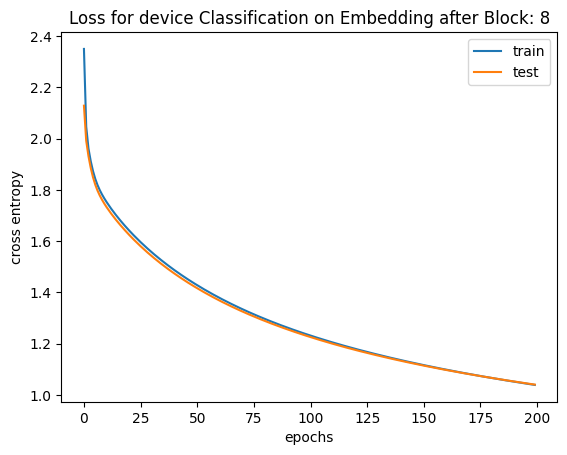

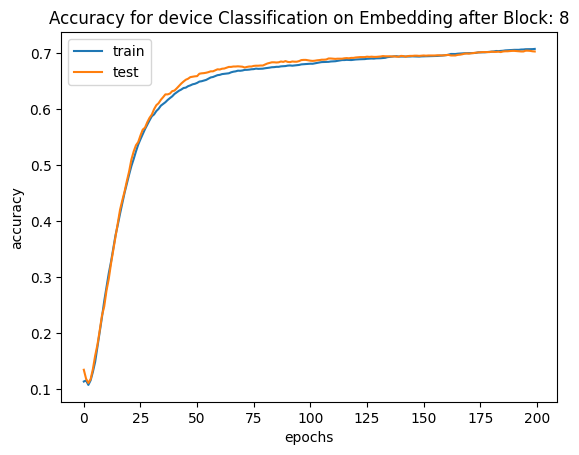

In [156]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [157]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [158]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [159]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [160]:
X_test=train_ready(test_data,col_name)

In [161]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


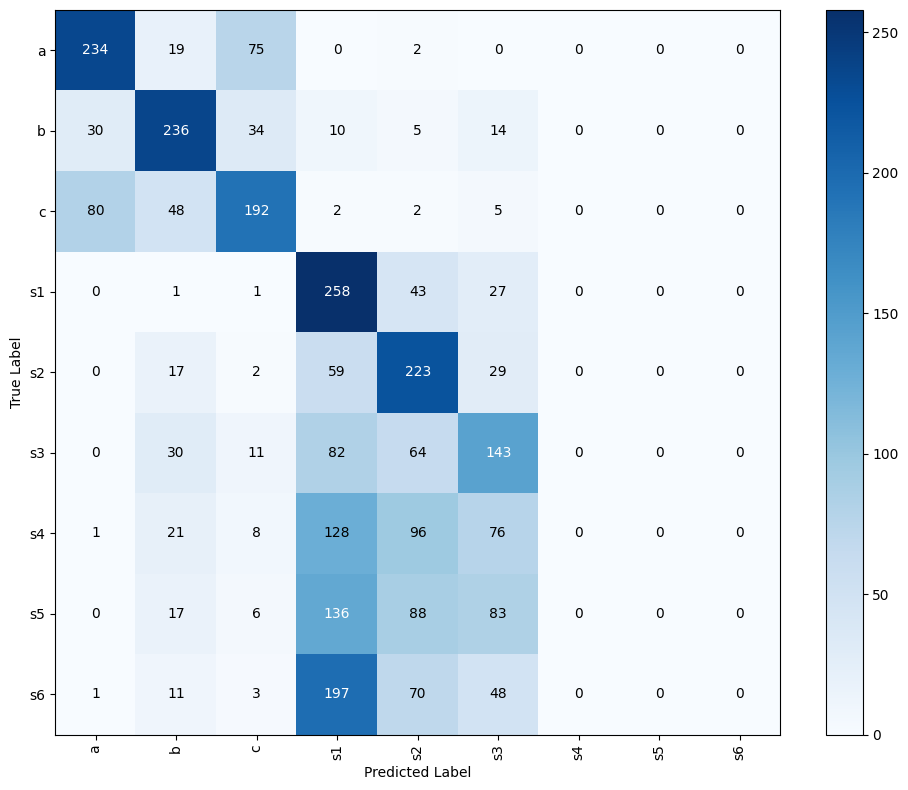

Accuracy: 0.4333


In [162]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-9

In [163]:
Block_number=9

In [164]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [165]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [166]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [167]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [168]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [169]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [170]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [171]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [172]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [173]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [174]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 445.28batch/s, acc=0.246, loss=2.12]


Epoch 0 validation: Cross-entropy=2.12, Accuracy=21.3%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 548.53batch/s, acc=0.258, loss=2.02]


Epoch 1 validation: Cross-entropy=2.03, Accuracy=22.3%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 286.76batch/s, acc=0.262, loss=1.93]


Epoch 2 validation: Cross-entropy=1.95, Accuracy=22.9%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 369.63batch/s, acc=0.27, loss=1.86] 


Epoch 3 validation: Cross-entropy=1.89, Accuracy=25.2%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 378.32batch/s, acc=0.293, loss=1.8] 


Epoch 4 validation: Cross-entropy=1.84, Accuracy=27.6%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 508.21batch/s, acc=0.324, loss=1.75]


Epoch 5 validation: Cross-entropy=1.80, Accuracy=30.3%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 434.43batch/s, acc=0.359, loss=1.71]


Epoch 6 validation: Cross-entropy=1.76, Accuracy=33.9%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 543.29batch/s, acc=0.387, loss=1.68]


Epoch 7 validation: Cross-entropy=1.73, Accuracy=37.5%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 360.56batch/s, acc=0.418, loss=1.65]


Epoch 8 validation: Cross-entropy=1.71, Accuracy=41.3%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 379.02batch/s, acc=0.457, loss=1.62]


Epoch 9 validation: Cross-entropy=1.69, Accuracy=44.4%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 505.35batch/s, acc=0.484, loss=1.6] 


Epoch 10 validation: Cross-entropy=1.67, Accuracy=47.3%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 361.24batch/s, acc=0.52, loss=1.58] 


Epoch 11 validation: Cross-entropy=1.65, Accuracy=49.8%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 439.32batch/s, acc=0.539, loss=1.56]


Epoch 12 validation: Cross-entropy=1.63, Accuracy=51.7%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 227.57batch/s, acc=0.559, loss=1.54]


Epoch 13 validation: Cross-entropy=1.62, Accuracy=53.6%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 566.54batch/s, acc=0.578, loss=1.52]


Epoch 14 validation: Cross-entropy=1.60, Accuracy=55.2%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 328.45batch/s, acc=0.598, loss=1.51]


Epoch 15 validation: Cross-entropy=1.59, Accuracy=57.1%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 564.73batch/s, acc=0.621, loss=1.49]


Epoch 16 validation: Cross-entropy=1.57, Accuracy=58.5%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 346.98batch/s, acc=0.645, loss=1.48]


Epoch 17 validation: Cross-entropy=1.56, Accuracy=59.7%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 529.92batch/s, acc=0.668, loss=1.46]


Epoch 18 validation: Cross-entropy=1.55, Accuracy=60.6%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 450.38batch/s, acc=0.668, loss=1.45]


Epoch 19 validation: Cross-entropy=1.53, Accuracy=61.4%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 414.28batch/s, acc=0.656, loss=1.44]


Epoch 20 validation: Cross-entropy=1.52, Accuracy=62.1%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 417.52batch/s, acc=0.664, loss=1.42]


Epoch 21 validation: Cross-entropy=1.51, Accuracy=63.0%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 627.59batch/s, acc=0.672, loss=1.41]


Epoch 22 validation: Cross-entropy=1.50, Accuracy=63.9%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 350.43batch/s, acc=0.668, loss=1.4] 


Epoch 23 validation: Cross-entropy=1.48, Accuracy=64.6%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 572.71batch/s, acc=0.664, loss=1.39]


Epoch 24 validation: Cross-entropy=1.47, Accuracy=65.2%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 354.63batch/s, acc=0.668, loss=1.38]


Epoch 25 validation: Cross-entropy=1.46, Accuracy=65.7%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 265.11batch/s, acc=0.68, loss=1.37] 


Epoch 26 validation: Cross-entropy=1.45, Accuracy=66.1%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 223.89batch/s, acc=0.676, loss=1.36]


Epoch 27 validation: Cross-entropy=1.44, Accuracy=66.5%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 553.75batch/s, acc=0.672, loss=1.35]


Epoch 28 validation: Cross-entropy=1.43, Accuracy=66.8%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 304.21batch/s, acc=0.672, loss=1.34]


Epoch 29 validation: Cross-entropy=1.42, Accuracy=67.2%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 604.77batch/s, acc=0.676, loss=1.33]


Epoch 30 validation: Cross-entropy=1.41, Accuracy=67.3%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 388.74batch/s, acc=0.684, loss=1.32]


Epoch 31 validation: Cross-entropy=1.40, Accuracy=67.6%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 629.99batch/s, acc=0.684, loss=1.31]


Epoch 32 validation: Cross-entropy=1.39, Accuracy=68.0%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 396.08batch/s, acc=0.691, loss=1.3] 


Epoch 33 validation: Cross-entropy=1.38, Accuracy=68.2%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 433.56batch/s, acc=0.695, loss=1.29]


Epoch 34 validation: Cross-entropy=1.37, Accuracy=68.7%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 328.80batch/s, acc=0.691, loss=1.28]


Epoch 35 validation: Cross-entropy=1.37, Accuracy=69.0%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 576.95batch/s, acc=0.691, loss=1.27]


Epoch 36 validation: Cross-entropy=1.36, Accuracy=69.1%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 377.82batch/s, acc=0.691, loss=1.26]


Epoch 37 validation: Cross-entropy=1.35, Accuracy=69.1%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 595.83batch/s, acc=0.691, loss=1.26]


Epoch 38 validation: Cross-entropy=1.34, Accuracy=69.1%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 367.84batch/s, acc=0.695, loss=1.25]


Epoch 39 validation: Cross-entropy=1.33, Accuracy=69.3%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 590.93batch/s, acc=0.695, loss=1.24]


Epoch 40 validation: Cross-entropy=1.32, Accuracy=69.6%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 285.51batch/s, acc=0.695, loss=1.23]


Epoch 41 validation: Cross-entropy=1.32, Accuracy=69.8%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 483.16batch/s, acc=0.691, loss=1.22]


Epoch 42 validation: Cross-entropy=1.31, Accuracy=69.9%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 340.54batch/s, acc=0.688, loss=1.22]


Epoch 43 validation: Cross-entropy=1.30, Accuracy=69.7%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 462.56batch/s, acc=0.688, loss=1.21]


Epoch 44 validation: Cross-entropy=1.30, Accuracy=69.6%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 222.63batch/s, acc=0.684, loss=1.2] 


Epoch 45 validation: Cross-entropy=1.29, Accuracy=69.6%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 505.63batch/s, acc=0.684, loss=1.2] 


Epoch 46 validation: Cross-entropy=1.28, Accuracy=70.0%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 280.34batch/s, acc=0.68, loss=1.19] 


Epoch 47 validation: Cross-entropy=1.27, Accuracy=70.0%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 520.54batch/s, acc=0.68, loss=1.18] 


Epoch 48 validation: Cross-entropy=1.27, Accuracy=70.0%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 316.20batch/s, acc=0.684, loss=1.18]


Epoch 49 validation: Cross-entropy=1.26, Accuracy=70.2%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 398.63batch/s, acc=0.684, loss=1.17]


Epoch 50 validation: Cross-entropy=1.26, Accuracy=70.3%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 456.57batch/s, acc=0.688, loss=1.17]


Epoch 51 validation: Cross-entropy=1.25, Accuracy=70.2%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 326.60batch/s, acc=0.695, loss=1.16]


Epoch 52 validation: Cross-entropy=1.24, Accuracy=70.2%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 520.92batch/s, acc=0.695, loss=1.15]


Epoch 53 validation: Cross-entropy=1.24, Accuracy=70.0%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 242.18batch/s, acc=0.695, loss=1.15]


Epoch 54 validation: Cross-entropy=1.23, Accuracy=70.1%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 546.89batch/s, acc=0.695, loss=1.14]


Epoch 55 validation: Cross-entropy=1.23, Accuracy=70.2%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 186.65batch/s, acc=0.691, loss=1.14]


Epoch 56 validation: Cross-entropy=1.22, Accuracy=70.3%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 493.05batch/s, acc=0.691, loss=1.13]


Epoch 57 validation: Cross-entropy=1.21, Accuracy=70.5%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 209.81batch/s, acc=0.695, loss=1.13]


Epoch 58 validation: Cross-entropy=1.21, Accuracy=70.4%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 192.29batch/s, acc=0.695, loss=1.12]


Epoch 59 validation: Cross-entropy=1.20, Accuracy=70.4%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 351.87batch/s, acc=0.699, loss=1.12]


Epoch 60 validation: Cross-entropy=1.20, Accuracy=70.5%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 233.26batch/s, acc=0.699, loss=1.11]


Epoch 61 validation: Cross-entropy=1.19, Accuracy=70.4%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 586.76batch/s, acc=0.699, loss=1.11]


Epoch 62 validation: Cross-entropy=1.19, Accuracy=70.3%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 267.46batch/s, acc=0.699, loss=1.1] 


Epoch 63 validation: Cross-entropy=1.18, Accuracy=70.5%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 557.59batch/s, acc=0.703, loss=1.1] 


Epoch 64 validation: Cross-entropy=1.18, Accuracy=70.3%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 277.80batch/s, acc=0.703, loss=1.09]


Epoch 65 validation: Cross-entropy=1.17, Accuracy=70.2%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 512.81batch/s, acc=0.707, loss=1.09]


Epoch 66 validation: Cross-entropy=1.17, Accuracy=70.2%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 370.09batch/s, acc=0.707, loss=1.08]


Epoch 67 validation: Cross-entropy=1.16, Accuracy=70.2%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 617.29batch/s, acc=0.707, loss=1.08]


Epoch 68 validation: Cross-entropy=1.16, Accuracy=70.4%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 387.70batch/s, acc=0.707, loss=1.07]


Epoch 69 validation: Cross-entropy=1.15, Accuracy=70.5%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 429.49batch/s, acc=0.707, loss=1.07]


Epoch 70 validation: Cross-entropy=1.15, Accuracy=70.6%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 373.37batch/s, acc=0.707, loss=1.06]


Epoch 71 validation: Cross-entropy=1.15, Accuracy=70.6%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 540.27batch/s, acc=0.707, loss=1.06]


Epoch 72 validation: Cross-entropy=1.14, Accuracy=70.5%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 379.89batch/s, acc=0.703, loss=1.06]


Epoch 73 validation: Cross-entropy=1.14, Accuracy=70.7%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 616.20batch/s, acc=0.703, loss=1.05]


Epoch 74 validation: Cross-entropy=1.13, Accuracy=70.7%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 397.11batch/s, acc=0.703, loss=1.05]


Epoch 75 validation: Cross-entropy=1.13, Accuracy=70.6%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 621.81batch/s, acc=0.703, loss=1.04]


Epoch 76 validation: Cross-entropy=1.12, Accuracy=70.7%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 299.83batch/s, acc=0.703, loss=1.04]


Epoch 77 validation: Cross-entropy=1.12, Accuracy=70.7%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 570.64batch/s, acc=0.699, loss=1.04]


Epoch 78 validation: Cross-entropy=1.12, Accuracy=70.6%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 392.95batch/s, acc=0.699, loss=1.03]


Epoch 79 validation: Cross-entropy=1.11, Accuracy=70.6%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 627.87batch/s, acc=0.699, loss=1.03]


Epoch 80 validation: Cross-entropy=1.11, Accuracy=70.7%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 388.39batch/s, acc=0.699, loss=1.03]


Epoch 81 validation: Cross-entropy=1.11, Accuracy=70.8%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 606.53batch/s, acc=0.707, loss=1.02]


Epoch 82 validation: Cross-entropy=1.10, Accuracy=70.7%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 388.17batch/s, acc=0.707, loss=1.02]


Epoch 83 validation: Cross-entropy=1.10, Accuracy=70.7%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 616.69batch/s, acc=0.707, loss=1.02]


Epoch 84 validation: Cross-entropy=1.09, Accuracy=70.4%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 397.16batch/s, acc=0.711, loss=1.01]


Epoch 85 validation: Cross-entropy=1.09, Accuracy=70.4%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 612.00batch/s, acc=0.715, loss=1.01]


Epoch 86 validation: Cross-entropy=1.09, Accuracy=70.5%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 385.86batch/s, acc=0.719, loss=1.01]


Epoch 87 validation: Cross-entropy=1.08, Accuracy=70.6%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 406.33batch/s, acc=0.719, loss=1]   


Epoch 88 validation: Cross-entropy=1.08, Accuracy=70.6%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 376.81batch/s, acc=0.719, loss=0.999]


Epoch 89 validation: Cross-entropy=1.08, Accuracy=70.7%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 629.02batch/s, acc=0.723, loss=0.995]


Epoch 90 validation: Cross-entropy=1.07, Accuracy=70.5%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 424.04batch/s, acc=0.723, loss=0.992]


Epoch 91 validation: Cross-entropy=1.07, Accuracy=70.5%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 560.17batch/s, acc=0.723, loss=0.989]


Epoch 92 validation: Cross-entropy=1.07, Accuracy=70.6%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 410.47batch/s, acc=0.723, loss=0.986]


Epoch 93 validation: Cross-entropy=1.06, Accuracy=70.6%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 577.97batch/s, acc=0.723, loss=0.983]


Epoch 94 validation: Cross-entropy=1.06, Accuracy=70.6%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 481.88batch/s, acc=0.723, loss=0.98] 


Epoch 95 validation: Cross-entropy=1.06, Accuracy=70.7%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 510.60batch/s, acc=0.723, loss=0.977]


Epoch 96 validation: Cross-entropy=1.06, Accuracy=70.6%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 227.51batch/s, acc=0.723, loss=0.974]


Epoch 97 validation: Cross-entropy=1.05, Accuracy=70.7%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 602.54batch/s, acc=0.723, loss=0.971]


Epoch 98 validation: Cross-entropy=1.05, Accuracy=70.5%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 410.02batch/s, acc=0.727, loss=0.969]


Epoch 99 validation: Cross-entropy=1.05, Accuracy=70.4%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 558.06batch/s, acc=0.73, loss=0.966] 


Epoch 100 validation: Cross-entropy=1.04, Accuracy=70.3%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 378.31batch/s, acc=0.73, loss=0.963] 


Epoch 101 validation: Cross-entropy=1.04, Accuracy=70.5%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 462.44batch/s, acc=0.734, loss=0.96] 


Epoch 102 validation: Cross-entropy=1.04, Accuracy=70.5%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 344.26batch/s, acc=0.734, loss=0.958]


Epoch 103 validation: Cross-entropy=1.04, Accuracy=70.5%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 591.92batch/s, acc=0.73, loss=0.955] 


Epoch 104 validation: Cross-entropy=1.03, Accuracy=70.7%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 284.90batch/s, acc=0.73, loss=0.952] 


Epoch 105 validation: Cross-entropy=1.03, Accuracy=70.6%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 627.05batch/s, acc=0.727, loss=0.95] 


Epoch 106 validation: Cross-entropy=1.03, Accuracy=70.6%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 409.60batch/s, acc=0.727, loss=0.947]


Epoch 107 validation: Cross-entropy=1.02, Accuracy=70.7%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 581.49batch/s, acc=0.727, loss=0.945]


Epoch 108 validation: Cross-entropy=1.02, Accuracy=70.8%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 360.55batch/s, acc=0.723, loss=0.942]


Epoch 109 validation: Cross-entropy=1.02, Accuracy=70.7%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 604.58batch/s, acc=0.723, loss=0.94] 


Epoch 110 validation: Cross-entropy=1.02, Accuracy=70.7%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 404.40batch/s, acc=0.723, loss=0.937]


Epoch 111 validation: Cross-entropy=1.01, Accuracy=70.7%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 377.57batch/s, acc=0.723, loss=0.935]


Epoch 112 validation: Cross-entropy=1.01, Accuracy=70.7%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 403.24batch/s, acc=0.727, loss=0.932]


Epoch 113 validation: Cross-entropy=1.01, Accuracy=70.7%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 556.94batch/s, acc=0.727, loss=0.93] 


Epoch 114 validation: Cross-entropy=1.01, Accuracy=70.7%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 385.68batch/s, acc=0.727, loss=0.928]


Epoch 115 validation: Cross-entropy=1.00, Accuracy=70.7%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 526.23batch/s, acc=0.727, loss=0.925]


Epoch 116 validation: Cross-entropy=1.00, Accuracy=70.8%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 431.86batch/s, acc=0.727, loss=0.923]


Epoch 117 validation: Cross-entropy=1.00, Accuracy=70.9%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 557.82batch/s, acc=0.727, loss=0.921]


Epoch 118 validation: Cross-entropy=1.00, Accuracy=70.9%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 283.52batch/s, acc=0.73, loss=0.918] 


Epoch 119 validation: Cross-entropy=0.99, Accuracy=70.8%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 584.39batch/s, acc=0.73, loss=0.916] 


Epoch 120 validation: Cross-entropy=0.99, Accuracy=70.6%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 391.12batch/s, acc=0.73, loss=0.914] 


Epoch 121 validation: Cross-entropy=0.99, Accuracy=70.6%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 560.77batch/s, acc=0.73, loss=0.912] 


Epoch 122 validation: Cross-entropy=0.99, Accuracy=70.6%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 383.61batch/s, acc=0.73, loss=0.91]  


Epoch 123 validation: Cross-entropy=0.99, Accuracy=70.6%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 622.26batch/s, acc=0.734, loss=0.908]


Epoch 124 validation: Cross-entropy=0.98, Accuracy=70.6%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 413.85batch/s, acc=0.734, loss=0.905]


Epoch 125 validation: Cross-entropy=0.98, Accuracy=70.6%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 498.73batch/s, acc=0.734, loss=0.903]


Epoch 126 validation: Cross-entropy=0.98, Accuracy=70.6%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 361.03batch/s, acc=0.734, loss=0.901]


Epoch 127 validation: Cross-entropy=0.98, Accuracy=70.6%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 557.63batch/s, acc=0.734, loss=0.899]


Epoch 128 validation: Cross-entropy=0.98, Accuracy=70.5%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 467.64batch/s, acc=0.734, loss=0.897]


Epoch 129 validation: Cross-entropy=0.97, Accuracy=70.6%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 509.00batch/s, acc=0.734, loss=0.895]


Epoch 130 validation: Cross-entropy=0.97, Accuracy=70.5%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 427.07batch/s, acc=0.734, loss=0.893]


Epoch 131 validation: Cross-entropy=0.97, Accuracy=70.5%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 553.79batch/s, acc=0.738, loss=0.891]


Epoch 132 validation: Cross-entropy=0.97, Accuracy=70.6%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 400.08batch/s, acc=0.742, loss=0.889]


Epoch 133 validation: Cross-entropy=0.96, Accuracy=70.6%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 407.33batch/s, acc=0.742, loss=0.887]


Epoch 134 validation: Cross-entropy=0.96, Accuracy=70.5%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 410.02batch/s, acc=0.742, loss=0.886]


Epoch 135 validation: Cross-entropy=0.96, Accuracy=70.5%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 597.90batch/s, acc=0.742, loss=0.884]


Epoch 136 validation: Cross-entropy=0.96, Accuracy=70.5%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 418.76batch/s, acc=0.738, loss=0.882]


Epoch 137 validation: Cross-entropy=0.96, Accuracy=70.5%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 545.05batch/s, acc=0.738, loss=0.88] 


Epoch 138 validation: Cross-entropy=0.96, Accuracy=70.4%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 392.16batch/s, acc=0.738, loss=0.878]


Epoch 139 validation: Cross-entropy=0.95, Accuracy=70.5%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 564.09batch/s, acc=0.742, loss=0.876]


Epoch 140 validation: Cross-entropy=0.95, Accuracy=70.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 482.59batch/s, acc=0.742, loss=0.874]


Epoch 141 validation: Cross-entropy=0.95, Accuracy=70.4%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 345.56batch/s, acc=0.742, loss=0.873]


Epoch 142 validation: Cross-entropy=0.95, Accuracy=70.5%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 482.85batch/s, acc=0.742, loss=0.871]


Epoch 143 validation: Cross-entropy=0.95, Accuracy=70.5%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 495.42batch/s, acc=0.742, loss=0.869]


Epoch 144 validation: Cross-entropy=0.94, Accuracy=70.5%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 489.91batch/s, acc=0.738, loss=0.867]


Epoch 145 validation: Cross-entropy=0.94, Accuracy=70.5%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 478.56batch/s, acc=0.738, loss=0.866]


Epoch 146 validation: Cross-entropy=0.94, Accuracy=70.6%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 447.69batch/s, acc=0.738, loss=0.864]


Epoch 147 validation: Cross-entropy=0.94, Accuracy=70.6%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 521.34batch/s, acc=0.738, loss=0.862]


Epoch 148 validation: Cross-entropy=0.94, Accuracy=70.7%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 566.50batch/s, acc=0.738, loss=0.861]


Epoch 149 validation: Cross-entropy=0.94, Accuracy=70.7%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 437.96batch/s, acc=0.738, loss=0.859]


Epoch 150 validation: Cross-entropy=0.93, Accuracy=70.7%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 503.90batch/s, acc=0.738, loss=0.857]


Epoch 151 validation: Cross-entropy=0.93, Accuracy=70.7%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 358.40batch/s, acc=0.738, loss=0.856]


Epoch 152 validation: Cross-entropy=0.93, Accuracy=70.7%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 472.91batch/s, acc=0.738, loss=0.854]


Epoch 153 validation: Cross-entropy=0.93, Accuracy=70.7%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 493.78batch/s, acc=0.738, loss=0.853]


Epoch 154 validation: Cross-entropy=0.93, Accuracy=70.6%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 618.25batch/s, acc=0.738, loss=0.851]


Epoch 155 validation: Cross-entropy=0.93, Accuracy=70.5%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 420.42batch/s, acc=0.738, loss=0.849]


Epoch 156 validation: Cross-entropy=0.92, Accuracy=70.5%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 494.07batch/s, acc=0.738, loss=0.848]


Epoch 157 validation: Cross-entropy=0.92, Accuracy=70.6%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 460.81batch/s, acc=0.742, loss=0.846]


Epoch 158 validation: Cross-entropy=0.92, Accuracy=70.6%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 428.68batch/s, acc=0.742, loss=0.845]


Epoch 159 validation: Cross-entropy=0.92, Accuracy=70.6%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 551.67batch/s, acc=0.742, loss=0.843]


Epoch 160 validation: Cross-entropy=0.92, Accuracy=70.6%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 328.52batch/s, acc=0.742, loss=0.842]


Epoch 161 validation: Cross-entropy=0.92, Accuracy=70.7%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 525.51batch/s, acc=0.742, loss=0.84] 


Epoch 162 validation: Cross-entropy=0.91, Accuracy=70.7%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 487.88batch/s, acc=0.742, loss=0.839]


Epoch 163 validation: Cross-entropy=0.91, Accuracy=70.7%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 504.11batch/s, acc=0.742, loss=0.837]


Epoch 164 validation: Cross-entropy=0.91, Accuracy=70.7%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 479.52batch/s, acc=0.742, loss=0.836]


Epoch 165 validation: Cross-entropy=0.91, Accuracy=70.7%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 496.16batch/s, acc=0.746, loss=0.834]


Epoch 166 validation: Cross-entropy=0.91, Accuracy=70.8%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 477.92batch/s, acc=0.746, loss=0.833]


Epoch 167 validation: Cross-entropy=0.91, Accuracy=70.8%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 353.39batch/s, acc=0.746, loss=0.832]


Epoch 168 validation: Cross-entropy=0.91, Accuracy=70.9%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 409.50batch/s, acc=0.75, loss=0.83]  


Epoch 169 validation: Cross-entropy=0.90, Accuracy=70.9%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 591.69batch/s, acc=0.75, loss=0.829] 


Epoch 170 validation: Cross-entropy=0.90, Accuracy=70.9%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 429.46batch/s, acc=0.75, loss=0.827] 


Epoch 171 validation: Cross-entropy=0.90, Accuracy=70.9%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 537.50batch/s, acc=0.754, loss=0.826]


Epoch 172 validation: Cross-entropy=0.90, Accuracy=70.9%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 505.06batch/s, acc=0.75, loss=0.825] 


Epoch 173 validation: Cross-entropy=0.90, Accuracy=70.9%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 482.76batch/s, acc=0.75, loss=0.823] 


Epoch 174 validation: Cross-entropy=0.90, Accuracy=70.9%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 321.13batch/s, acc=0.75, loss=0.822] 


Epoch 175 validation: Cross-entropy=0.90, Accuracy=70.9%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 489.97batch/s, acc=0.75, loss=0.821] 


Epoch 176 validation: Cross-entropy=0.89, Accuracy=70.9%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 487.73batch/s, acc=0.75, loss=0.819] 


Epoch 177 validation: Cross-entropy=0.89, Accuracy=70.9%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 456.89batch/s, acc=0.75, loss=0.818] 


Epoch 178 validation: Cross-entropy=0.89, Accuracy=70.8%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 420.45batch/s, acc=0.75, loss=0.817] 


Epoch 179 validation: Cross-entropy=0.89, Accuracy=70.8%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 553.92batch/s, acc=0.75, loss=0.815] 


Epoch 180 validation: Cross-entropy=0.89, Accuracy=70.8%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 440.32batch/s, acc=0.75, loss=0.814] 


Epoch 181 validation: Cross-entropy=0.89, Accuracy=70.9%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 539.37batch/s, acc=0.75, loss=0.813] 


Epoch 182 validation: Cross-entropy=0.89, Accuracy=70.9%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 362.69batch/s, acc=0.75, loss=0.811] 


Epoch 183 validation: Cross-entropy=0.89, Accuracy=70.9%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 497.25batch/s, acc=0.75, loss=0.81]  


Epoch 184 validation: Cross-entropy=0.88, Accuracy=70.9%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 583.97batch/s, acc=0.75, loss=0.809] 


Epoch 185 validation: Cross-entropy=0.88, Accuracy=70.9%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 420.13batch/s, acc=0.75, loss=0.808] 


Epoch 186 validation: Cross-entropy=0.88, Accuracy=70.9%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 618.22batch/s, acc=0.75, loss=0.806] 


Epoch 187 validation: Cross-entropy=0.88, Accuracy=70.9%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 404.79batch/s, acc=0.75, loss=0.805] 


Epoch 188 validation: Cross-entropy=0.88, Accuracy=70.9%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 622.96batch/s, acc=0.75, loss=0.804] 


Epoch 189 validation: Cross-entropy=0.88, Accuracy=70.9%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 291.48batch/s, acc=0.746, loss=0.803]


Epoch 190 validation: Cross-entropy=0.88, Accuracy=70.9%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 602.21batch/s, acc=0.746, loss=0.802]


Epoch 191 validation: Cross-entropy=0.88, Accuracy=70.9%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 396.57batch/s, acc=0.746, loss=0.8]  


Epoch 192 validation: Cross-entropy=0.87, Accuracy=71.0%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 605.86batch/s, acc=0.746, loss=0.799]


Epoch 193 validation: Cross-entropy=0.87, Accuracy=71.0%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 364.42batch/s, acc=0.742, loss=0.798]


Epoch 194 validation: Cross-entropy=0.87, Accuracy=71.0%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 586.45batch/s, acc=0.742, loss=0.797]


Epoch 195 validation: Cross-entropy=0.87, Accuracy=71.0%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 404.33batch/s, acc=0.742, loss=0.796]


Epoch 196 validation: Cross-entropy=0.87, Accuracy=71.0%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 614.85batch/s, acc=0.742, loss=0.795]


Epoch 197 validation: Cross-entropy=0.87, Accuracy=71.0%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 398.50batch/s, acc=0.742, loss=0.794]


Epoch 198 validation: Cross-entropy=0.87, Accuracy=71.0%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 623.30batch/s, acc=0.742, loss=0.792]


Epoch 199 validation: Cross-entropy=0.87, Accuracy=71.0%


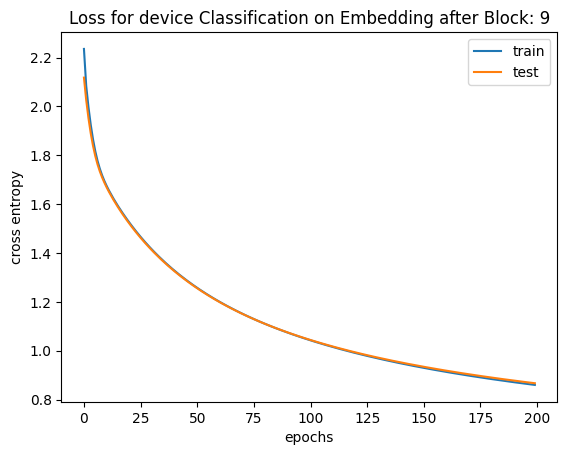

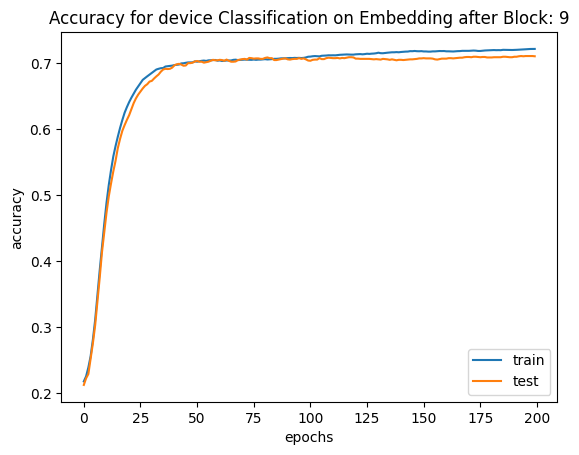

In [175]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [176]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [177]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [178]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [179]:
X_test=train_ready(test_data,col_name)

In [180]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


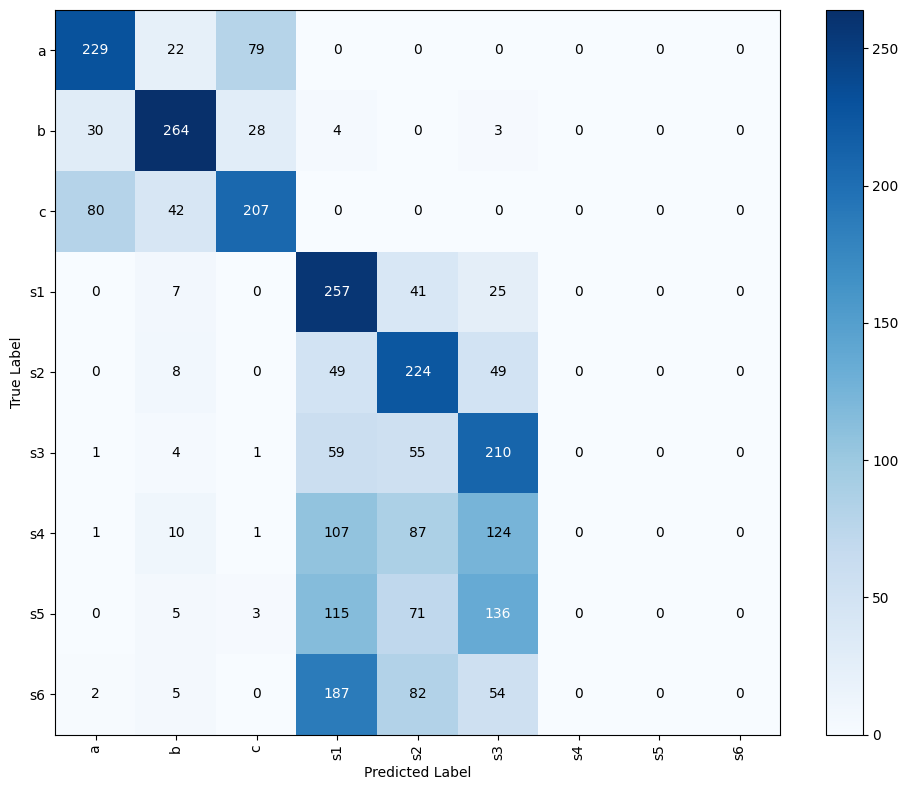

Accuracy: 0.4687


In [181]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-10

In [182]:
Block_number=10

In [183]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [184]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [185]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [186]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [187]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [188]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [189]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [190]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [191]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [192]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 357.14batch/s, acc=0.52, loss=2.22] 


Epoch 0 validation: Cross-entropy=2.39, Accuracy=44.6%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 583.29batch/s, acc=0.371, loss=1.91]


Epoch 1 validation: Cross-entropy=2.05, Accuracy=33.2%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 352.38batch/s, acc=0.273, loss=1.85]


Epoch 2 validation: Cross-entropy=1.95, Accuracy=25.9%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 609.87batch/s, acc=0.273, loss=1.81]


Epoch 3 validation: Cross-entropy=1.89, Accuracy=25.4%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 411.51batch/s, acc=0.301, loss=1.78]


Epoch 4 validation: Cross-entropy=1.84, Accuracy=26.3%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 600.89batch/s, acc=0.305, loss=1.75]


Epoch 5 validation: Cross-entropy=1.81, Accuracy=27.3%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 290.70batch/s, acc=0.316, loss=1.73]


Epoch 6 validation: Cross-entropy=1.78, Accuracy=27.5%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 596.48batch/s, acc=0.344, loss=1.71]


Epoch 7 validation: Cross-entropy=1.75, Accuracy=29.0%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 425.44batch/s, acc=0.34, loss=1.7]  


Epoch 8 validation: Cross-entropy=1.73, Accuracy=30.0%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 556.57batch/s, acc=0.352, loss=1.68]


Epoch 9 validation: Cross-entropy=1.71, Accuracy=30.7%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 420.65batch/s, acc=0.355, loss=1.67]


Epoch 10 validation: Cross-entropy=1.70, Accuracy=32.0%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 560.32batch/s, acc=0.363, loss=1.65]


Epoch 11 validation: Cross-entropy=1.68, Accuracy=32.9%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 392.04batch/s, acc=0.367, loss=1.64]


Epoch 12 validation: Cross-entropy=1.67, Accuracy=33.8%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 573.42batch/s, acc=0.383, loss=1.62]


Epoch 13 validation: Cross-entropy=1.65, Accuracy=34.7%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 364.04batch/s, acc=0.383, loss=1.61]

Epoch 14 validation: Cross-entropy=1.64, Accuracy=35.7%

Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 506.68batch/s, acc=0.383, loss=1.6] 


Epoch 15 validation: Cross-entropy=1.62, Accuracy=36.6%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 330.33batch/s, acc=0.398, loss=1.58]


Epoch 16 validation: Cross-entropy=1.61, Accuracy=37.5%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 580.47batch/s, acc=0.414, loss=1.57]


Epoch 17 validation: Cross-entropy=1.60, Accuracy=38.4%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 244.25batch/s, acc=0.414, loss=1.56]


Epoch 18 validation: Cross-entropy=1.58, Accuracy=39.0%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 464.67batch/s, acc=0.422, loss=1.54]


Epoch 19 validation: Cross-entropy=1.57, Accuracy=39.8%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 340.70batch/s, acc=0.422, loss=1.53]


Epoch 20 validation: Cross-entropy=1.56, Accuracy=40.7%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 401.24batch/s, acc=0.449, loss=1.52]


Epoch 21 validation: Cross-entropy=1.54, Accuracy=41.7%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 339.58batch/s, acc=0.461, loss=1.5] 


Epoch 22 validation: Cross-entropy=1.53, Accuracy=42.3%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 533.18batch/s, acc=0.449, loss=1.49]


Epoch 23 validation: Cross-entropy=1.52, Accuracy=42.9%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 303.52batch/s, acc=0.469, loss=1.48]


Epoch 24 validation: Cross-entropy=1.51, Accuracy=43.5%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 381.77batch/s, acc=0.469, loss=1.47]


Epoch 25 validation: Cross-entropy=1.50, Accuracy=44.3%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 348.94batch/s, acc=0.473, loss=1.46]


Epoch 26 validation: Cross-entropy=1.49, Accuracy=45.0%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 568.69batch/s, acc=0.477, loss=1.44]


Epoch 27 validation: Cross-entropy=1.48, Accuracy=45.5%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 278.46batch/s, acc=0.488, loss=1.43]


Epoch 28 validation: Cross-entropy=1.47, Accuracy=46.3%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 546.88batch/s, acc=0.5, loss=1.42]  


Epoch 29 validation: Cross-entropy=1.46, Accuracy=46.8%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 362.38batch/s, acc=0.504, loss=1.41]


Epoch 30 validation: Cross-entropy=1.45, Accuracy=47.3%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 607.52batch/s, acc=0.508, loss=1.4] 


Epoch 31 validation: Cross-entropy=1.44, Accuracy=47.8%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 211.96batch/s, acc=0.512, loss=1.39]


Epoch 32 validation: Cross-entropy=1.43, Accuracy=48.7%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 372.70batch/s, acc=0.516, loss=1.38]


Epoch 33 validation: Cross-entropy=1.42, Accuracy=49.2%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 231.46batch/s, acc=0.527, loss=1.37]


Epoch 34 validation: Cross-entropy=1.41, Accuracy=49.9%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 452.96batch/s, acc=0.527, loss=1.36]


Epoch 35 validation: Cross-entropy=1.40, Accuracy=50.2%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 274.63batch/s, acc=0.531, loss=1.35]


Epoch 36 validation: Cross-entropy=1.39, Accuracy=50.6%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 527.35batch/s, acc=0.527, loss=1.34]


Epoch 37 validation: Cross-entropy=1.38, Accuracy=50.8%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 204.08batch/s, acc=0.535, loss=1.33]


Epoch 38 validation: Cross-entropy=1.37, Accuracy=51.2%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 254.22batch/s, acc=0.539, loss=1.32]


Epoch 39 validation: Cross-entropy=1.36, Accuracy=51.5%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 452.62batch/s, acc=0.539, loss=1.31]


Epoch 40 validation: Cross-entropy=1.36, Accuracy=52.0%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 293.86batch/s, acc=0.555, loss=1.3] 


Epoch 41 validation: Cross-entropy=1.35, Accuracy=52.4%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 407.59batch/s, acc=0.559, loss=1.29]


Epoch 42 validation: Cross-entropy=1.34, Accuracy=52.6%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 325.54batch/s, acc=0.562, loss=1.28]


Epoch 43 validation: Cross-entropy=1.33, Accuracy=53.1%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 449.75batch/s, acc=0.562, loss=1.27]


Epoch 44 validation: Cross-entropy=1.32, Accuracy=53.3%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 334.25batch/s, acc=0.562, loss=1.26]


Epoch 45 validation: Cross-entropy=1.32, Accuracy=53.6%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 318.91batch/s, acc=0.562, loss=1.26]


Epoch 46 validation: Cross-entropy=1.31, Accuracy=54.1%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 318.25batch/s, acc=0.562, loss=1.25]


Epoch 47 validation: Cross-entropy=1.30, Accuracy=54.6%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 514.34batch/s, acc=0.566, loss=1.24]


Epoch 48 validation: Cross-entropy=1.30, Accuracy=55.1%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 295.03batch/s, acc=0.578, loss=1.23]


Epoch 49 validation: Cross-entropy=1.29, Accuracy=55.7%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 528.05batch/s, acc=0.59, loss=1.22] 


Epoch 50 validation: Cross-entropy=1.28, Accuracy=56.2%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 300.02batch/s, acc=0.594, loss=1.21]


Epoch 51 validation: Cross-entropy=1.28, Accuracy=56.2%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 526.39batch/s, acc=0.602, loss=1.21]


Epoch 52 validation: Cross-entropy=1.27, Accuracy=56.5%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 228.26batch/s, acc=0.613, loss=1.2] 


Epoch 53 validation: Cross-entropy=1.26, Accuracy=56.8%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 526.64batch/s, acc=0.617, loss=1.19]


Epoch 54 validation: Cross-entropy=1.26, Accuracy=57.1%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 327.39batch/s, acc=0.625, loss=1.19]


Epoch 55 validation: Cross-entropy=1.25, Accuracy=57.3%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 433.71batch/s, acc=0.625, loss=1.18]


Epoch 56 validation: Cross-entropy=1.24, Accuracy=57.7%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 391.50batch/s, acc=0.629, loss=1.17]


Epoch 57 validation: Cross-entropy=1.24, Accuracy=57.9%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 465.57batch/s, acc=0.629, loss=1.16]


Epoch 58 validation: Cross-entropy=1.23, Accuracy=58.2%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 334.03batch/s, acc=0.625, loss=1.16]


Epoch 59 validation: Cross-entropy=1.23, Accuracy=58.5%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 240.38batch/s, acc=0.625, loss=1.15]


Epoch 60 validation: Cross-entropy=1.22, Accuracy=58.7%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 516.63batch/s, acc=0.633, loss=1.14]


Epoch 61 validation: Cross-entropy=1.22, Accuracy=58.8%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 374.61batch/s, acc=0.633, loss=1.14]


Epoch 62 validation: Cross-entropy=1.21, Accuracy=58.9%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 405.50batch/s, acc=0.633, loss=1.13]


Epoch 63 validation: Cross-entropy=1.21, Accuracy=59.2%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 314.41batch/s, acc=0.633, loss=1.13]


Epoch 64 validation: Cross-entropy=1.20, Accuracy=59.4%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 506.85batch/s, acc=0.633, loss=1.12]


Epoch 65 validation: Cross-entropy=1.19, Accuracy=59.8%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 245.92batch/s, acc=0.633, loss=1.11]


Epoch 66 validation: Cross-entropy=1.19, Accuracy=60.3%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 334.05batch/s, acc=0.633, loss=1.11]


Epoch 67 validation: Cross-entropy=1.18, Accuracy=60.7%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 212.34batch/s, acc=0.633, loss=1.1] 


Epoch 68 validation: Cross-entropy=1.18, Accuracy=60.8%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 516.39batch/s, acc=0.633, loss=1.1] 


Epoch 69 validation: Cross-entropy=1.18, Accuracy=60.9%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 313.57batch/s, acc=0.637, loss=1.09]


Epoch 70 validation: Cross-entropy=1.17, Accuracy=61.2%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 531.71batch/s, acc=0.637, loss=1.08]


Epoch 71 validation: Cross-entropy=1.17, Accuracy=61.3%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 307.20batch/s, acc=0.641, loss=1.08]


Epoch 72 validation: Cross-entropy=1.16, Accuracy=61.3%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 534.41batch/s, acc=0.645, loss=1.07]


Epoch 73 validation: Cross-entropy=1.16, Accuracy=61.4%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 249.02batch/s, acc=0.652, loss=1.07]


Epoch 74 validation: Cross-entropy=1.15, Accuracy=61.5%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 479.94batch/s, acc=0.652, loss=1.06]


Epoch 75 validation: Cross-entropy=1.15, Accuracy=61.7%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 310.01batch/s, acc=0.652, loss=1.06]


Epoch 76 validation: Cross-entropy=1.14, Accuracy=61.9%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 503.94batch/s, acc=0.656, loss=1.05]


Epoch 77 validation: Cross-entropy=1.14, Accuracy=62.0%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 314.74batch/s, acc=0.656, loss=1.05]


Epoch 78 validation: Cross-entropy=1.14, Accuracy=62.2%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 541.28batch/s, acc=0.664, loss=1.04]


Epoch 79 validation: Cross-entropy=1.13, Accuracy=62.2%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 265.33batch/s, acc=0.672, loss=1.04]


Epoch 80 validation: Cross-entropy=1.13, Accuracy=62.3%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 319.74batch/s, acc=0.684, loss=1.03]


Epoch 81 validation: Cross-entropy=1.12, Accuracy=62.4%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 208.51batch/s, acc=0.684, loss=1.03]


Epoch 82 validation: Cross-entropy=1.12, Accuracy=62.5%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 368.41batch/s, acc=0.684, loss=1.02]


Epoch 83 validation: Cross-entropy=1.12, Accuracy=62.8%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 393.88batch/s, acc=0.684, loss=1.02]


Epoch 84 validation: Cross-entropy=1.11, Accuracy=62.9%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 511.75batch/s, acc=0.684, loss=1.01]


Epoch 85 validation: Cross-entropy=1.11, Accuracy=63.1%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 318.95batch/s, acc=0.688, loss=1.01]


Epoch 86 validation: Cross-entropy=1.10, Accuracy=63.1%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 501.11batch/s, acc=0.688, loss=1.01]


Epoch 87 validation: Cross-entropy=1.10, Accuracy=63.2%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 331.09batch/s, acc=0.684, loss=1]   


Epoch 88 validation: Cross-entropy=1.10, Accuracy=63.4%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 288.82batch/s, acc=0.688, loss=0.997]


Epoch 89 validation: Cross-entropy=1.09, Accuracy=63.6%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 369.91batch/s, acc=0.688, loss=0.993]


Epoch 90 validation: Cross-entropy=1.09, Accuracy=63.7%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 408.09batch/s, acc=0.691, loss=0.989]


Epoch 91 validation: Cross-entropy=1.09, Accuracy=63.7%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 379.99batch/s, acc=0.695, loss=0.985]


Epoch 92 validation: Cross-entropy=1.08, Accuracy=63.9%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 499.98batch/s, acc=0.699, loss=0.981]


Epoch 93 validation: Cross-entropy=1.08, Accuracy=64.0%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 323.29batch/s, acc=0.707, loss=0.977]


Epoch 94 validation: Cross-entropy=1.08, Accuracy=64.1%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 319.85batch/s, acc=0.711, loss=0.973]


Epoch 95 validation: Cross-entropy=1.07, Accuracy=64.1%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 307.74batch/s, acc=0.715, loss=0.969]


Epoch 96 validation: Cross-entropy=1.07, Accuracy=64.3%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 322.88batch/s, acc=0.715, loss=0.966]


Epoch 97 validation: Cross-entropy=1.07, Accuracy=64.4%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 489.56batch/s, acc=0.711, loss=0.962]


Epoch 98 validation: Cross-entropy=1.06, Accuracy=64.7%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 328.62batch/s, acc=0.711, loss=0.958]


Epoch 99 validation: Cross-entropy=1.06, Accuracy=64.8%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 472.72batch/s, acc=0.715, loss=0.955]


Epoch 100 validation: Cross-entropy=1.06, Accuracy=64.9%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 319.79batch/s, acc=0.715, loss=0.951]


Epoch 101 validation: Cross-entropy=1.06, Accuracy=65.0%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 501.97batch/s, acc=0.715, loss=0.947]


Epoch 102 validation: Cross-entropy=1.05, Accuracy=65.1%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 185.76batch/s, acc=0.711, loss=0.944]


Epoch 103 validation: Cross-entropy=1.05, Accuracy=65.2%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 523.33batch/s, acc=0.711, loss=0.94] 


Epoch 104 validation: Cross-entropy=1.05, Accuracy=65.2%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 327.83batch/s, acc=0.715, loss=0.937]


Epoch 105 validation: Cross-entropy=1.04, Accuracy=65.5%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 543.97batch/s, acc=0.715, loss=0.934]


Epoch 106 validation: Cross-entropy=1.04, Accuracy=65.5%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 368.29batch/s, acc=0.715, loss=0.93] 


Epoch 107 validation: Cross-entropy=1.04, Accuracy=65.7%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 546.48batch/s, acc=0.715, loss=0.927]


Epoch 108 validation: Cross-entropy=1.04, Accuracy=65.8%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 402.13batch/s, acc=0.719, loss=0.924]


Epoch 109 validation: Cross-entropy=1.03, Accuracy=66.0%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 391.56batch/s, acc=0.723, loss=0.921]


Epoch 110 validation: Cross-entropy=1.03, Accuracy=66.1%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 413.29batch/s, acc=0.723, loss=0.918]


Epoch 111 validation: Cross-entropy=1.03, Accuracy=66.1%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 552.24batch/s, acc=0.723, loss=0.914]


Epoch 112 validation: Cross-entropy=1.03, Accuracy=66.1%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 418.10batch/s, acc=0.727, loss=0.911]


Epoch 113 validation: Cross-entropy=1.02, Accuracy=66.3%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 396.48batch/s, acc=0.727, loss=0.908]


Epoch 114 validation: Cross-entropy=1.02, Accuracy=66.3%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 311.81batch/s, acc=0.727, loss=0.905]


Epoch 115 validation: Cross-entropy=1.02, Accuracy=66.4%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 464.92batch/s, acc=0.727, loss=0.902]


Epoch 116 validation: Cross-entropy=1.01, Accuracy=66.5%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 191.20batch/s, acc=0.727, loss=0.899]


Epoch 117 validation: Cross-entropy=1.01, Accuracy=66.4%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 498.75batch/s, acc=0.73, loss=0.897] 


Epoch 118 validation: Cross-entropy=1.01, Accuracy=66.3%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 306.46batch/s, acc=0.727, loss=0.894]


Epoch 119 validation: Cross-entropy=1.01, Accuracy=66.3%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 494.66batch/s, acc=0.727, loss=0.891]


Epoch 120 validation: Cross-entropy=1.01, Accuracy=66.4%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 291.15batch/s, acc=0.727, loss=0.888]


Epoch 121 validation: Cross-entropy=1.00, Accuracy=66.5%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 509.10batch/s, acc=0.73, loss=0.885] 


Epoch 122 validation: Cross-entropy=1.00, Accuracy=66.5%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 297.26batch/s, acc=0.73, loss=0.883] 


Epoch 123 validation: Cross-entropy=1.00, Accuracy=66.6%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 394.80batch/s, acc=0.73, loss=0.88]  


Epoch 124 validation: Cross-entropy=1.00, Accuracy=66.6%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 276.12batch/s, acc=0.73, loss=0.877] 


Epoch 125 validation: Cross-entropy=0.99, Accuracy=66.7%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 513.11batch/s, acc=0.73, loss=0.875] 


Epoch 126 validation: Cross-entropy=0.99, Accuracy=66.7%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 291.30batch/s, acc=0.73, loss=0.872] 


Epoch 127 validation: Cross-entropy=0.99, Accuracy=66.8%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 480.25batch/s, acc=0.73, loss=0.869] 


Epoch 128 validation: Cross-entropy=0.99, Accuracy=66.8%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 308.05batch/s, acc=0.73, loss=0.867] 


Epoch 129 validation: Cross-entropy=0.99, Accuracy=67.0%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 517.64batch/s, acc=0.73, loss=0.864] 


Epoch 130 validation: Cross-entropy=0.98, Accuracy=67.1%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 296.70batch/s, acc=0.73, loss=0.862] 


Epoch 131 validation: Cross-entropy=0.98, Accuracy=67.2%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 204.40batch/s, acc=0.727, loss=0.859]


Epoch 132 validation: Cross-entropy=0.98, Accuracy=67.2%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 281.49batch/s, acc=0.727, loss=0.857]


Epoch 133 validation: Cross-entropy=0.98, Accuracy=67.4%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 511.06batch/s, acc=0.727, loss=0.855]


Epoch 134 validation: Cross-entropy=0.97, Accuracy=67.5%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 292.78batch/s, acc=0.727, loss=0.852]


Epoch 135 validation: Cross-entropy=0.97, Accuracy=67.6%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 468.12batch/s, acc=0.727, loss=0.85] 


Epoch 136 validation: Cross-entropy=0.97, Accuracy=67.6%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 309.92batch/s, acc=0.727, loss=0.848]


Epoch 137 validation: Cross-entropy=0.97, Accuracy=67.5%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 467.09batch/s, acc=0.727, loss=0.845]


Epoch 138 validation: Cross-entropy=0.97, Accuracy=67.6%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 230.27batch/s, acc=0.727, loss=0.843]


Epoch 139 validation: Cross-entropy=0.97, Accuracy=67.8%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 461.29batch/s, acc=0.73, loss=0.841] 


Epoch 140 validation: Cross-entropy=0.96, Accuracy=67.9%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 277.84batch/s, acc=0.73, loss=0.839] 


Epoch 141 validation: Cross-entropy=0.96, Accuracy=68.1%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 454.80batch/s, acc=0.73, loss=0.836] 


Epoch 142 validation: Cross-entropy=0.96, Accuracy=68.1%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 312.81batch/s, acc=0.73, loss=0.834] 


Epoch 143 validation: Cross-entropy=0.96, Accuracy=68.2%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 467.55batch/s, acc=0.73, loss=0.832] 


Epoch 144 validation: Cross-entropy=0.96, Accuracy=68.2%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 299.98batch/s, acc=0.73, loss=0.83]  


Epoch 145 validation: Cross-entropy=0.95, Accuracy=68.4%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 227.43batch/s, acc=0.727, loss=0.828]


Epoch 146 validation: Cross-entropy=0.95, Accuracy=68.3%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 468.13batch/s, acc=0.727, loss=0.826]


Epoch 147 validation: Cross-entropy=0.95, Accuracy=68.4%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 278.35batch/s, acc=0.727, loss=0.824]


Epoch 148 validation: Cross-entropy=0.95, Accuracy=68.5%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 496.38batch/s, acc=0.727, loss=0.821]


Epoch 149 validation: Cross-entropy=0.95, Accuracy=68.6%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 285.93batch/s, acc=0.73, loss=0.819] 


Epoch 150 validation: Cross-entropy=0.95, Accuracy=68.6%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 482.49batch/s, acc=0.727, loss=0.817]


Epoch 151 validation: Cross-entropy=0.94, Accuracy=68.7%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 277.64batch/s, acc=0.727, loss=0.815]


Epoch 152 validation: Cross-entropy=0.94, Accuracy=68.8%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 475.09batch/s, acc=0.727, loss=0.813]


Epoch 153 validation: Cross-entropy=0.94, Accuracy=68.8%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 212.77batch/s, acc=0.73, loss=0.812] 


Epoch 154 validation: Cross-entropy=0.94, Accuracy=68.8%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 515.21batch/s, acc=0.73, loss=0.81]  


Epoch 155 validation: Cross-entropy=0.94, Accuracy=68.9%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 354.84batch/s, acc=0.73, loss=0.808] 


Epoch 156 validation: Cross-entropy=0.94, Accuracy=69.0%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 424.51batch/s, acc=0.73, loss=0.806] 


Epoch 157 validation: Cross-entropy=0.93, Accuracy=69.1%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 433.69batch/s, acc=0.73, loss=0.804] 


Epoch 158 validation: Cross-entropy=0.93, Accuracy=69.2%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 371.44batch/s, acc=0.73, loss=0.802] 


Epoch 159 validation: Cross-entropy=0.93, Accuracy=69.2%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 542.10batch/s, acc=0.73, loss=0.8]   


Epoch 160 validation: Cross-entropy=0.93, Accuracy=69.3%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 240.21batch/s, acc=0.73, loss=0.798] 


Epoch 161 validation: Cross-entropy=0.93, Accuracy=69.3%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 591.58batch/s, acc=0.73, loss=0.797] 


Epoch 162 validation: Cross-entropy=0.93, Accuracy=69.4%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 340.32batch/s, acc=0.73, loss=0.795] 


Epoch 163 validation: Cross-entropy=0.92, Accuracy=69.4%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 422.61batch/s, acc=0.73, loss=0.793] 


Epoch 164 validation: Cross-entropy=0.92, Accuracy=69.6%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 349.05batch/s, acc=0.73, loss=0.791] 


Epoch 165 validation: Cross-entropy=0.92, Accuracy=69.6%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 574.27batch/s, acc=0.73, loss=0.789] 


Epoch 166 validation: Cross-entropy=0.92, Accuracy=69.6%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 399.07batch/s, acc=0.73, loss=0.788] 


Epoch 167 validation: Cross-entropy=0.92, Accuracy=69.6%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 376.97batch/s, acc=0.727, loss=0.786]


Epoch 168 validation: Cross-entropy=0.92, Accuracy=69.7%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 408.03batch/s, acc=0.727, loss=0.784]


Epoch 169 validation: Cross-entropy=0.91, Accuracy=69.9%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 485.69batch/s, acc=0.727, loss=0.783]


Epoch 170 validation: Cross-entropy=0.91, Accuracy=70.0%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 510.25batch/s, acc=0.727, loss=0.781]


Epoch 171 validation: Cross-entropy=0.91, Accuracy=69.9%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 389.49batch/s, acc=0.727, loss=0.779]


Epoch 172 validation: Cross-entropy=0.91, Accuracy=69.9%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 614.59batch/s, acc=0.727, loss=0.778]


Epoch 173 validation: Cross-entropy=0.91, Accuracy=70.0%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 376.86batch/s, acc=0.727, loss=0.776]


Epoch 174 validation: Cross-entropy=0.91, Accuracy=70.0%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 469.89batch/s, acc=0.73, loss=0.774] 


Epoch 175 validation: Cross-entropy=0.91, Accuracy=70.1%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 341.88batch/s, acc=0.73, loss=0.773] 


Epoch 176 validation: Cross-entropy=0.91, Accuracy=70.1%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 376.04batch/s, acc=0.734, loss=0.771]


Epoch 177 validation: Cross-entropy=0.90, Accuracy=70.1%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 585.86batch/s, acc=0.734, loss=0.77] 


Epoch 178 validation: Cross-entropy=0.90, Accuracy=70.1%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 359.57batch/s, acc=0.734, loss=0.768]


Epoch 179 validation: Cross-entropy=0.90, Accuracy=70.1%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 561.70batch/s, acc=0.734, loss=0.767]


Epoch 180 validation: Cross-entropy=0.90, Accuracy=70.2%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 389.23batch/s, acc=0.734, loss=0.765]


Epoch 181 validation: Cross-entropy=0.90, Accuracy=70.2%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 543.55batch/s, acc=0.734, loss=0.764]


Epoch 182 validation: Cross-entropy=0.90, Accuracy=70.2%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 441.76batch/s, acc=0.734, loss=0.762]


Epoch 183 validation: Cross-entropy=0.90, Accuracy=70.2%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 519.78batch/s, acc=0.734, loss=0.761]


Epoch 184 validation: Cross-entropy=0.89, Accuracy=70.2%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 398.41batch/s, acc=0.734, loss=0.759]


Epoch 185 validation: Cross-entropy=0.89, Accuracy=70.2%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 448.35batch/s, acc=0.734, loss=0.758]


Epoch 186 validation: Cross-entropy=0.89, Accuracy=70.2%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 308.31batch/s, acc=0.734, loss=0.756]


Epoch 187 validation: Cross-entropy=0.89, Accuracy=70.2%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 609.88batch/s, acc=0.734, loss=0.755]


Epoch 188 validation: Cross-entropy=0.89, Accuracy=70.2%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 389.27batch/s, acc=0.734, loss=0.753]


Epoch 189 validation: Cross-entropy=0.89, Accuracy=70.2%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 560.51batch/s, acc=0.734, loss=0.752]


Epoch 190 validation: Cross-entropy=0.89, Accuracy=70.3%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 363.33batch/s, acc=0.734, loss=0.75] 


Epoch 191 validation: Cross-entropy=0.89, Accuracy=70.4%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 611.21batch/s, acc=0.734, loss=0.749]


Epoch 192 validation: Cross-entropy=0.88, Accuracy=70.3%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 344.12batch/s, acc=0.734, loss=0.748]


Epoch 193 validation: Cross-entropy=0.88, Accuracy=70.3%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 411.55batch/s, acc=0.734, loss=0.746]


Epoch 194 validation: Cross-entropy=0.88, Accuracy=70.4%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 328.97batch/s, acc=0.734, loss=0.745]


Epoch 195 validation: Cross-entropy=0.88, Accuracy=70.5%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 586.61batch/s, acc=0.734, loss=0.744]


Epoch 196 validation: Cross-entropy=0.88, Accuracy=70.5%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 332.82batch/s, acc=0.734, loss=0.742]


Epoch 197 validation: Cross-entropy=0.88, Accuracy=70.6%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 562.09batch/s, acc=0.738, loss=0.741]


Epoch 198 validation: Cross-entropy=0.88, Accuracy=70.6%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 330.27batch/s, acc=0.738, loss=0.74] 


Epoch 199 validation: Cross-entropy=0.88, Accuracy=70.6%


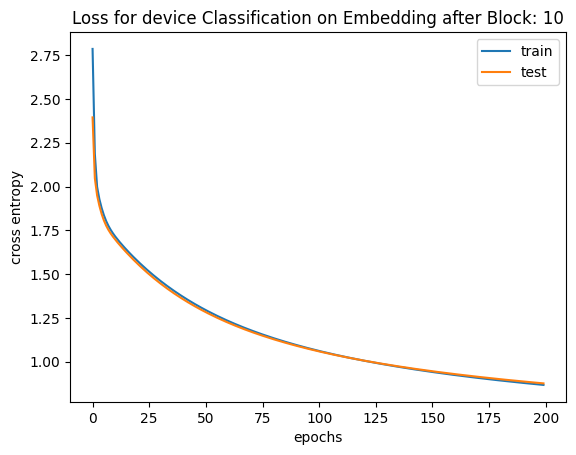

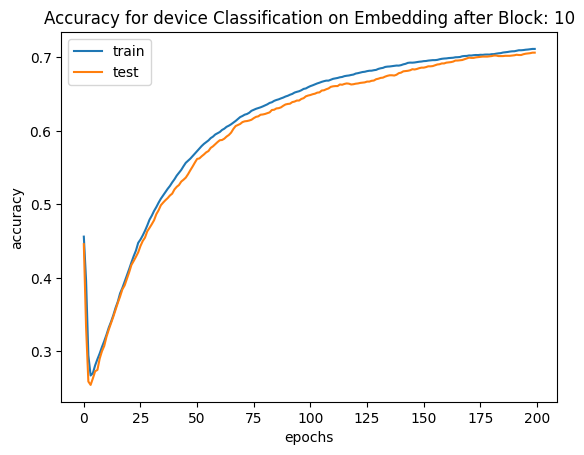

In [193]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [194]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [195]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [196]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [197]:
X_test=train_ready(test_data,col_name)

In [198]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


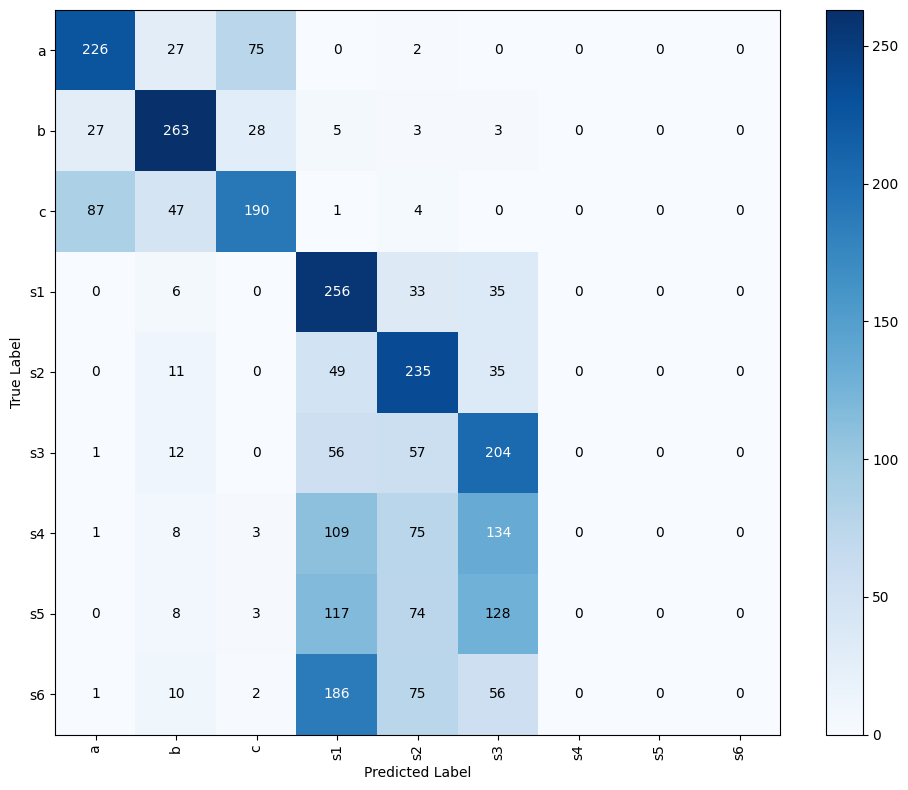

Accuracy: 0.4629


In [199]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-11

In [200]:
Block_number=11

In [201]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [202]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [203]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [204]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [205]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [206]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [207]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [208]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [209]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [210]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 294.33batch/s, acc=0.18, loss=2.11] 


Epoch 0 validation: Cross-entropy=2.15, Accuracy=20.8%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 575.07batch/s, acc=0.152, loss=1.96]


Epoch 1 validation: Cross-entropy=2.01, Accuracy=19.8%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 336.66batch/s, acc=0.152, loss=1.86]


Epoch 2 validation: Cross-entropy=1.92, Accuracy=17.9%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 583.92batch/s, acc=0.152, loss=1.8] 


Epoch 3 validation: Cross-entropy=1.86, Accuracy=17.7%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 366.33batch/s, acc=0.145, loss=1.75]


Epoch 4 validation: Cross-entropy=1.81, Accuracy=18.6%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 404.84batch/s, acc=0.191, loss=1.72]


Epoch 5 validation: Cross-entropy=1.78, Accuracy=19.7%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 349.19batch/s, acc=0.223, loss=1.69]


Epoch 6 validation: Cross-entropy=1.75, Accuracy=21.1%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 591.09batch/s, acc=0.215, loss=1.67]


Epoch 7 validation: Cross-entropy=1.73, Accuracy=23.1%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 336.76batch/s, acc=0.242, loss=1.65]


Epoch 8 validation: Cross-entropy=1.71, Accuracy=25.1%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 597.24batch/s, acc=0.258, loss=1.63]


Epoch 9 validation: Cross-entropy=1.69, Accuracy=27.3%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 348.99batch/s, acc=0.27, loss=1.61] 


Epoch 10 validation: Cross-entropy=1.67, Accuracy=29.5%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 583.32batch/s, acc=0.297, loss=1.59]


Epoch 11 validation: Cross-entropy=1.65, Accuracy=31.0%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 367.15batch/s, acc=0.312, loss=1.57]


Epoch 12 validation: Cross-entropy=1.63, Accuracy=32.8%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 571.89batch/s, acc=0.352, loss=1.55]


Epoch 13 validation: Cross-entropy=1.61, Accuracy=34.2%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 367.57batch/s, acc=0.363, loss=1.53]


Epoch 14 validation: Cross-entropy=1.60, Accuracy=35.9%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 420.17batch/s, acc=0.375, loss=1.51]


Epoch 15 validation: Cross-entropy=1.58, Accuracy=37.8%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 361.39batch/s, acc=0.398, loss=1.5] 


Epoch 16 validation: Cross-entropy=1.57, Accuracy=39.2%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 603.72batch/s, acc=0.406, loss=1.48]


Epoch 17 validation: Cross-entropy=1.55, Accuracy=40.8%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 365.99batch/s, acc=0.434, loss=1.47]


Epoch 18 validation: Cross-entropy=1.54, Accuracy=42.4%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 619.62batch/s, acc=0.445, loss=1.45]


Epoch 19 validation: Cross-entropy=1.52, Accuracy=43.5%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 360.81batch/s, acc=0.473, loss=1.44]


Epoch 20 validation: Cross-entropy=1.51, Accuracy=44.6%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 577.05batch/s, acc=0.48, loss=1.42] 


Epoch 21 validation: Cross-entropy=1.50, Accuracy=45.9%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 267.28batch/s, acc=0.484, loss=1.41]


Epoch 22 validation: Cross-entropy=1.48, Accuracy=46.7%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 602.88batch/s, acc=0.5, loss=1.4]   


Epoch 23 validation: Cross-entropy=1.47, Accuracy=47.5%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 368.97batch/s, acc=0.52, loss=1.38] 


Epoch 24 validation: Cross-entropy=1.46, Accuracy=48.8%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 587.99batch/s, acc=0.539, loss=1.37]


Epoch 25 validation: Cross-entropy=1.45, Accuracy=49.6%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 340.84batch/s, acc=0.562, loss=1.36]


Epoch 26 validation: Cross-entropy=1.44, Accuracy=50.4%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 623.50batch/s, acc=0.57, loss=1.35] 


Epoch 27 validation: Cross-entropy=1.43, Accuracy=51.3%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 353.06batch/s, acc=0.57, loss=1.34] 


Epoch 28 validation: Cross-entropy=1.42, Accuracy=51.7%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 408.33batch/s, acc=0.574, loss=1.33]


Epoch 29 validation: Cross-entropy=1.41, Accuracy=52.6%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 368.61batch/s, acc=0.578, loss=1.31]


Epoch 30 validation: Cross-entropy=1.40, Accuracy=53.3%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 573.66batch/s, acc=0.598, loss=1.3] 


Epoch 31 validation: Cross-entropy=1.39, Accuracy=54.1%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 373.38batch/s, acc=0.602, loss=1.29]


Epoch 32 validation: Cross-entropy=1.38, Accuracy=54.5%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 600.95batch/s, acc=0.605, loss=1.28]


Epoch 33 validation: Cross-entropy=1.37, Accuracy=55.0%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 354.85batch/s, acc=0.617, loss=1.27]


Epoch 34 validation: Cross-entropy=1.36, Accuracy=55.5%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 586.08batch/s, acc=0.617, loss=1.26]


Epoch 35 validation: Cross-entropy=1.35, Accuracy=56.1%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 258.38batch/s, acc=0.617, loss=1.26]


Epoch 36 validation: Cross-entropy=1.35, Accuracy=56.4%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 582.66batch/s, acc=0.617, loss=1.25]


Epoch 37 validation: Cross-entropy=1.34, Accuracy=56.8%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 348.88batch/s, acc=0.621, loss=1.24]


Epoch 38 validation: Cross-entropy=1.33, Accuracy=57.3%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 594.23batch/s, acc=0.621, loss=1.23]


Epoch 39 validation: Cross-entropy=1.32, Accuracy=57.7%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 369.09batch/s, acc=0.633, loss=1.22]


Epoch 40 validation: Cross-entropy=1.32, Accuracy=58.1%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 578.48batch/s, acc=0.633, loss=1.21]


Epoch 41 validation: Cross-entropy=1.31, Accuracy=58.3%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 344.27batch/s, acc=0.629, loss=1.2] 


Epoch 42 validation: Cross-entropy=1.30, Accuracy=58.7%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 516.94batch/s, acc=0.633, loss=1.2] 


Epoch 43 validation: Cross-entropy=1.29, Accuracy=58.9%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 350.94batch/s, acc=0.637, loss=1.19]


Epoch 44 validation: Cross-entropy=1.29, Accuracy=59.2%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 571.54batch/s, acc=0.641, loss=1.18]


Epoch 45 validation: Cross-entropy=1.28, Accuracy=59.7%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 347.92batch/s, acc=0.641, loss=1.17]


Epoch 46 validation: Cross-entropy=1.27, Accuracy=59.8%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 604.08batch/s, acc=0.648, loss=1.17]


Epoch 47 validation: Cross-entropy=1.27, Accuracy=60.1%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 364.44batch/s, acc=0.652, loss=1.16]


Epoch 48 validation: Cross-entropy=1.26, Accuracy=60.4%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 383.32batch/s, acc=0.648, loss=1.15]


Epoch 49 validation: Cross-entropy=1.26, Accuracy=60.5%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 298.24batch/s, acc=0.645, loss=1.15]


Epoch 50 validation: Cross-entropy=1.25, Accuracy=60.7%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 552.02batch/s, acc=0.641, loss=1.14]


Epoch 51 validation: Cross-entropy=1.24, Accuracy=60.6%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 388.84batch/s, acc=0.641, loss=1.13]


Epoch 52 validation: Cross-entropy=1.24, Accuracy=61.0%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 582.81batch/s, acc=0.652, loss=1.13]


Epoch 53 validation: Cross-entropy=1.23, Accuracy=61.2%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 348.44batch/s, acc=0.66, loss=1.12] 


Epoch 54 validation: Cross-entropy=1.23, Accuracy=61.2%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 593.19batch/s, acc=0.668, loss=1.11]


Epoch 55 validation: Cross-entropy=1.22, Accuracy=61.4%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 377.60batch/s, acc=0.668, loss=1.11]


Epoch 56 validation: Cross-entropy=1.22, Accuracy=61.6%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 384.76batch/s, acc=0.684, loss=1.1] 


Epoch 57 validation: Cross-entropy=1.21, Accuracy=61.8%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 382.74batch/s, acc=0.68, loss=1.1]  


Epoch 58 validation: Cross-entropy=1.21, Accuracy=61.9%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 548.27batch/s, acc=0.68, loss=1.09] 


Epoch 59 validation: Cross-entropy=1.20, Accuracy=62.1%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 364.59batch/s, acc=0.68, loss=1.08] 


Epoch 60 validation: Cross-entropy=1.20, Accuracy=62.2%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 530.04batch/s, acc=0.684, loss=1.08]


Epoch 61 validation: Cross-entropy=1.19, Accuracy=62.3%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 423.78batch/s, acc=0.691, loss=1.07]


Epoch 62 validation: Cross-entropy=1.19, Accuracy=62.6%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 547.68batch/s, acc=0.691, loss=1.07]


Epoch 63 validation: Cross-entropy=1.18, Accuracy=62.6%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 336.06batch/s, acc=0.691, loss=1.06]


Epoch 64 validation: Cross-entropy=1.18, Accuracy=62.9%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 469.61batch/s, acc=0.691, loss=1.06]


Epoch 65 validation: Cross-entropy=1.17, Accuracy=62.9%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 480.85batch/s, acc=0.695, loss=1.05]


Epoch 66 validation: Cross-entropy=1.17, Accuracy=63.0%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 455.29batch/s, acc=0.695, loss=1.05]


Epoch 67 validation: Cross-entropy=1.16, Accuracy=63.0%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 605.88batch/s, acc=0.695, loss=1.04]


Epoch 68 validation: Cross-entropy=1.16, Accuracy=63.1%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 339.13batch/s, acc=0.695, loss=1.04]


Epoch 69 validation: Cross-entropy=1.16, Accuracy=63.3%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 536.66batch/s, acc=0.699, loss=1.04]


Epoch 70 validation: Cross-entropy=1.15, Accuracy=63.4%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 311.21batch/s, acc=0.695, loss=1.03]


Epoch 71 validation: Cross-entropy=1.15, Accuracy=63.7%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 519.64batch/s, acc=0.695, loss=1.03]


Epoch 72 validation: Cross-entropy=1.14, Accuracy=63.8%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 439.68batch/s, acc=0.699, loss=1.02]


Epoch 73 validation: Cross-entropy=1.14, Accuracy=63.8%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 464.71batch/s, acc=0.699, loss=1.02]


Epoch 74 validation: Cross-entropy=1.14, Accuracy=63.8%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 456.89batch/s, acc=0.699, loss=1.01]


Epoch 75 validation: Cross-entropy=1.13, Accuracy=63.7%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 616.82batch/s, acc=0.695, loss=1.01]


Epoch 76 validation: Cross-entropy=1.13, Accuracy=63.8%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 379.87batch/s, acc=0.699, loss=1.01]


Epoch 77 validation: Cross-entropy=1.13, Accuracy=63.9%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 413.69batch/s, acc=0.703, loss=1]   


Epoch 78 validation: Cross-entropy=1.12, Accuracy=64.1%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 344.75batch/s, acc=0.703, loss=0.998]


Epoch 79 validation: Cross-entropy=1.12, Accuracy=64.3%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 595.00batch/s, acc=0.703, loss=0.994]


Epoch 80 validation: Cross-entropy=1.12, Accuracy=64.3%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 353.45batch/s, acc=0.703, loss=0.99]


Epoch 81 validation: Cross-entropy=1.11, Accuracy=64.2%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 586.60batch/s, acc=0.703, loss=0.986]


Epoch 82 validation: Cross-entropy=1.11, Accuracy=64.2%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 348.90batch/s, acc=0.703, loss=0.983]


Epoch 83 validation: Cross-entropy=1.11, Accuracy=64.3%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 584.75batch/s, acc=0.707, loss=0.979]


Epoch 84 validation: Cross-entropy=1.10, Accuracy=64.4%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 272.44batch/s, acc=0.707, loss=0.975]


Epoch 85 validation: Cross-entropy=1.10, Accuracy=64.4%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 589.70batch/s, acc=0.707, loss=0.972]


Epoch 86 validation: Cross-entropy=1.10, Accuracy=64.5%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 347.33batch/s, acc=0.707, loss=0.968]


Epoch 87 validation: Cross-entropy=1.09, Accuracy=64.6%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 605.31batch/s, acc=0.703, loss=0.965]


Epoch 88 validation: Cross-entropy=1.09, Accuracy=64.6%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 365.10batch/s, acc=0.703, loss=0.962]


Epoch 89 validation: Cross-entropy=1.09, Accuracy=64.8%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 611.46batch/s, acc=0.703, loss=0.958]


Epoch 90 validation: Cross-entropy=1.08, Accuracy=65.0%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 370.76batch/s, acc=0.699, loss=0.955]


Epoch 91 validation: Cross-entropy=1.08, Accuracy=65.2%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 403.26batch/s, acc=0.699, loss=0.952]


Epoch 92 validation: Cross-entropy=1.08, Accuracy=65.3%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 360.57batch/s, acc=0.695, loss=0.949]


Epoch 93 validation: Cross-entropy=1.07, Accuracy=65.4%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 572.58batch/s, acc=0.695, loss=0.946]


Epoch 94 validation: Cross-entropy=1.07, Accuracy=65.5%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 304.68batch/s, acc=0.695, loss=0.942]


Epoch 95 validation: Cross-entropy=1.07, Accuracy=65.7%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 589.26batch/s, acc=0.695, loss=0.939]


Epoch 96 validation: Cross-entropy=1.07, Accuracy=65.6%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 227.95batch/s, acc=0.695, loss=0.936]


Epoch 97 validation: Cross-entropy=1.06, Accuracy=65.8%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 581.05batch/s, acc=0.691, loss=0.934]


Epoch 98 validation: Cross-entropy=1.06, Accuracy=65.9%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 293.18batch/s, acc=0.691, loss=0.931]


Epoch 99 validation: Cross-entropy=1.06, Accuracy=65.8%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 559.65batch/s, acc=0.691, loss=0.928]


Epoch 100 validation: Cross-entropy=1.06, Accuracy=66.0%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 353.23batch/s, acc=0.691, loss=0.925]


Epoch 101 validation: Cross-entropy=1.05, Accuracy=66.1%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 587.02batch/s, acc=0.691, loss=0.922]


Epoch 102 validation: Cross-entropy=1.05, Accuracy=66.1%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 373.63batch/s, acc=0.691, loss=0.919]


Epoch 103 validation: Cross-entropy=1.05, Accuracy=66.2%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 613.76batch/s, acc=0.691, loss=0.917]


Epoch 104 validation: Cross-entropy=1.05, Accuracy=66.3%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 374.60batch/s, acc=0.695, loss=0.914]


Epoch 105 validation: Cross-entropy=1.04, Accuracy=66.3%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 607.30batch/s, acc=0.695, loss=0.911]


Epoch 106 validation: Cross-entropy=1.04, Accuracy=66.3%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 258.86batch/s, acc=0.695, loss=0.909]


Epoch 107 validation: Cross-entropy=1.04, Accuracy=66.4%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 576.09batch/s, acc=0.695, loss=0.906]


Epoch 108 validation: Cross-entropy=1.04, Accuracy=66.4%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 335.05batch/s, acc=0.695, loss=0.904]


Epoch 109 validation: Cross-entropy=1.03, Accuracy=66.4%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 608.75batch/s, acc=0.695, loss=0.901]


Epoch 110 validation: Cross-entropy=1.03, Accuracy=66.4%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 364.40batch/s, acc=0.695, loss=0.899]


Epoch 111 validation: Cross-entropy=1.03, Accuracy=66.5%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 556.85batch/s, acc=0.695, loss=0.896]


Epoch 112 validation: Cross-entropy=1.03, Accuracy=66.5%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 362.28batch/s, acc=0.691, loss=0.894]


Epoch 113 validation: Cross-entropy=1.02, Accuracy=66.6%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 417.89batch/s, acc=0.691, loss=0.891]


Epoch 114 validation: Cross-entropy=1.02, Accuracy=66.6%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 371.46batch/s, acc=0.691, loss=0.889]


Epoch 115 validation: Cross-entropy=1.02, Accuracy=66.6%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 609.64batch/s, acc=0.691, loss=0.887]


Epoch 116 validation: Cross-entropy=1.02, Accuracy=66.6%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 359.64batch/s, acc=0.691, loss=0.884]


Epoch 117 validation: Cross-entropy=1.02, Accuracy=66.6%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 611.54batch/s, acc=0.695, loss=0.882]


Epoch 118 validation: Cross-entropy=1.01, Accuracy=66.6%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 350.02batch/s, acc=0.695, loss=0.88] 


Epoch 119 validation: Cross-entropy=1.01, Accuracy=66.7%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 602.62batch/s, acc=0.699, loss=0.878]


Epoch 120 validation: Cross-entropy=1.01, Accuracy=66.7%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 266.71batch/s, acc=0.699, loss=0.875]


Epoch 121 validation: Cross-entropy=1.01, Accuracy=66.7%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 550.61batch/s, acc=0.699, loss=0.873]


Epoch 122 validation: Cross-entropy=1.01, Accuracy=66.8%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 346.16batch/s, acc=0.699, loss=0.871]


Epoch 123 validation: Cross-entropy=1.00, Accuracy=66.9%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 601.97batch/s, acc=0.699, loss=0.869]


Epoch 124 validation: Cross-entropy=1.00, Accuracy=66.9%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 362.06batch/s, acc=0.699, loss=0.867]


Epoch 125 validation: Cross-entropy=1.00, Accuracy=66.9%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 580.25batch/s, acc=0.699, loss=0.865]


Epoch 126 validation: Cross-entropy=1.00, Accuracy=66.9%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 363.47batch/s, acc=0.699, loss=0.863]


Epoch 127 validation: Cross-entropy=1.00, Accuracy=67.0%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 611.08batch/s, acc=0.699, loss=0.861]


Epoch 128 validation: Cross-entropy=0.99, Accuracy=67.1%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 271.44batch/s, acc=0.699, loss=0.859]


Epoch 129 validation: Cross-entropy=0.99, Accuracy=67.1%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 601.80batch/s, acc=0.699, loss=0.857]


Epoch 130 validation: Cross-entropy=0.99, Accuracy=67.0%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 355.42batch/s, acc=0.699, loss=0.855]


Epoch 131 validation: Cross-entropy=0.99, Accuracy=67.1%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 613.58batch/s, acc=0.699, loss=0.853]


Epoch 132 validation: Cross-entropy=0.99, Accuracy=67.1%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 368.58batch/s, acc=0.699, loss=0.851]


Epoch 133 validation: Cross-entropy=0.99, Accuracy=67.2%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 611.11batch/s, acc=0.699, loss=0.849]


Epoch 134 validation: Cross-entropy=0.98, Accuracy=67.2%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 371.48batch/s, acc=0.703, loss=0.847]


Epoch 135 validation: Cross-entropy=0.98, Accuracy=67.1%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 405.24batch/s, acc=0.703, loss=0.845]


Epoch 136 validation: Cross-entropy=0.98, Accuracy=67.1%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 361.77batch/s, acc=0.703, loss=0.843]


Epoch 137 validation: Cross-entropy=0.98, Accuracy=67.1%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 602.13batch/s, acc=0.703, loss=0.841]


Epoch 138 validation: Cross-entropy=0.98, Accuracy=67.0%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 347.38batch/s, acc=0.707, loss=0.84] 


Epoch 139 validation: Cross-entropy=0.98, Accuracy=67.1%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 575.68batch/s, acc=0.703, loss=0.838]


Epoch 140 validation: Cross-entropy=0.97, Accuracy=67.2%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 341.25batch/s, acc=0.707, loss=0.836]


Epoch 141 validation: Cross-entropy=0.97, Accuracy=67.2%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 583.23batch/s, acc=0.707, loss=0.834]


Epoch 142 validation: Cross-entropy=0.97, Accuracy=67.2%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 284.06batch/s, acc=0.707, loss=0.833]


Epoch 143 validation: Cross-entropy=0.97, Accuracy=67.3%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 579.24batch/s, acc=0.707, loss=0.831]


Epoch 144 validation: Cross-entropy=0.97, Accuracy=67.3%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 372.65batch/s, acc=0.707, loss=0.829]


Epoch 145 validation: Cross-entropy=0.97, Accuracy=67.3%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 587.84batch/s, acc=0.707, loss=0.827]


Epoch 146 validation: Cross-entropy=0.96, Accuracy=67.4%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 350.98batch/s, acc=0.711, loss=0.826]


Epoch 147 validation: Cross-entropy=0.96, Accuracy=67.5%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 590.92batch/s, acc=0.711, loss=0.824]


Epoch 148 validation: Cross-entropy=0.96, Accuracy=67.5%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 385.93batch/s, acc=0.711, loss=0.822]


Epoch 149 validation: Cross-entropy=0.96, Accuracy=67.5%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 407.00batch/s, acc=0.711, loss=0.821]


Epoch 150 validation: Cross-entropy=0.96, Accuracy=67.5%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 357.28batch/s, acc=0.715, loss=0.819]


Epoch 151 validation: Cross-entropy=0.96, Accuracy=67.5%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 389.33batch/s, acc=0.715, loss=0.818]


Epoch 152 validation: Cross-entropy=0.95, Accuracy=67.5%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 540.62batch/s, acc=0.715, loss=0.816]


Epoch 153 validation: Cross-entropy=0.95, Accuracy=67.5%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 355.30batch/s, acc=0.715, loss=0.814]


Epoch 154 validation: Cross-entropy=0.95, Accuracy=67.5%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 603.51batch/s, acc=0.715, loss=0.813]


Epoch 155 validation: Cross-entropy=0.95, Accuracy=67.5%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 341.34batch/s, acc=0.715, loss=0.811]


Epoch 156 validation: Cross-entropy=0.95, Accuracy=67.5%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 588.35batch/s, acc=0.715, loss=0.81] 


Epoch 157 validation: Cross-entropy=0.95, Accuracy=67.4%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 256.93batch/s, acc=0.715, loss=0.808]


Epoch 158 validation: Cross-entropy=0.95, Accuracy=67.5%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 597.39batch/s, acc=0.715, loss=0.807]


Epoch 159 validation: Cross-entropy=0.94, Accuracy=67.6%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 323.59batch/s, acc=0.715, loss=0.805]


Epoch 160 validation: Cross-entropy=0.94, Accuracy=67.5%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 610.46batch/s, acc=0.715, loss=0.804]


Epoch 161 validation: Cross-entropy=0.94, Accuracy=67.6%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 373.85batch/s, acc=0.715, loss=0.802]


Epoch 162 validation: Cross-entropy=0.94, Accuracy=67.7%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 614.00batch/s, acc=0.715, loss=0.801]


Epoch 163 validation: Cross-entropy=0.94, Accuracy=67.7%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 373.29batch/s, acc=0.715, loss=0.8]  


Epoch 164 validation: Cross-entropy=0.94, Accuracy=67.6%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 455.05batch/s, acc=0.715, loss=0.798]


Epoch 165 validation: Cross-entropy=0.94, Accuracy=67.7%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 357.36batch/s, acc=0.715, loss=0.797]


Epoch 166 validation: Cross-entropy=0.93, Accuracy=67.8%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 596.24batch/s, acc=0.715, loss=0.795]


Epoch 167 validation: Cross-entropy=0.93, Accuracy=67.8%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 353.37batch/s, acc=0.715, loss=0.794]


Epoch 168 validation: Cross-entropy=0.93, Accuracy=67.8%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 600.82batch/s, acc=0.719, loss=0.793]


Epoch 169 validation: Cross-entropy=0.93, Accuracy=67.8%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 328.52batch/s, acc=0.719, loss=0.791]


Epoch 170 validation: Cross-entropy=0.93, Accuracy=68.0%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 539.43batch/s, acc=0.719, loss=0.79] 


Epoch 171 validation: Cross-entropy=0.93, Accuracy=68.0%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 371.49batch/s, acc=0.719, loss=0.789]


Epoch 172 validation: Cross-entropy=0.93, Accuracy=68.0%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 417.46batch/s, acc=0.719, loss=0.787]


Epoch 173 validation: Cross-entropy=0.93, Accuracy=68.0%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 342.94batch/s, acc=0.719, loss=0.786]


Epoch 174 validation: Cross-entropy=0.92, Accuracy=68.0%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 598.18batch/s, acc=0.719, loss=0.785]


Epoch 175 validation: Cross-entropy=0.92, Accuracy=68.0%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 349.33batch/s, acc=0.719, loss=0.783]


Epoch 176 validation: Cross-entropy=0.92, Accuracy=68.0%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 520.49batch/s, acc=0.719, loss=0.782]


Epoch 177 validation: Cross-entropy=0.92, Accuracy=68.1%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 429.38batch/s, acc=0.719, loss=0.781]


Epoch 178 validation: Cross-entropy=0.92, Accuracy=68.0%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 433.12batch/s, acc=0.719, loss=0.779]


Epoch 179 validation: Cross-entropy=0.92, Accuracy=68.0%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 345.41batch/s, acc=0.719, loss=0.778]


Epoch 180 validation: Cross-entropy=0.92, Accuracy=68.0%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 361.49batch/s, acc=0.719, loss=0.777]


Epoch 181 validation: Cross-entropy=0.92, Accuracy=68.1%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 556.52batch/s, acc=0.719, loss=0.776]


Epoch 182 validation: Cross-entropy=0.92, Accuracy=68.2%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 368.73batch/s, acc=0.719, loss=0.775]


Epoch 183 validation: Cross-entropy=0.91, Accuracy=68.3%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 566.36batch/s, acc=0.719, loss=0.773]


Epoch 184 validation: Cross-entropy=0.91, Accuracy=68.3%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 379.38batch/s, acc=0.719, loss=0.772]


Epoch 185 validation: Cross-entropy=0.91, Accuracy=68.4%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 583.98batch/s, acc=0.719, loss=0.771]


Epoch 186 validation: Cross-entropy=0.91, Accuracy=68.6%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 283.17batch/s, acc=0.719, loss=0.77] 


Epoch 187 validation: Cross-entropy=0.91, Accuracy=68.6%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 552.53batch/s, acc=0.719, loss=0.769]


Epoch 188 validation: Cross-entropy=0.91, Accuracy=68.6%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 380.94batch/s, acc=0.719, loss=0.767]


Epoch 189 validation: Cross-entropy=0.91, Accuracy=68.6%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 577.22batch/s, acc=0.719, loss=0.766]


Epoch 190 validation: Cross-entropy=0.91, Accuracy=68.6%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 361.29batch/s, acc=0.719, loss=0.765]


Epoch 191 validation: Cross-entropy=0.90, Accuracy=68.5%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 582.55batch/s, acc=0.719, loss=0.764]


Epoch 192 validation: Cross-entropy=0.90, Accuracy=68.5%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 369.52batch/s, acc=0.719, loss=0.763]


Epoch 193 validation: Cross-entropy=0.90, Accuracy=68.6%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 567.18batch/s, acc=0.719, loss=0.762]


Epoch 194 validation: Cross-entropy=0.90, Accuracy=68.6%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 255.05batch/s, acc=0.719, loss=0.761]


Epoch 195 validation: Cross-entropy=0.90, Accuracy=68.6%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 538.71batch/s, acc=0.719, loss=0.759]


Epoch 196 validation: Cross-entropy=0.90, Accuracy=68.7%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 385.34batch/s, acc=0.719, loss=0.758]


Epoch 197 validation: Cross-entropy=0.90, Accuracy=68.7%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 564.99batch/s, acc=0.715, loss=0.757]


Epoch 198 validation: Cross-entropy=0.90, Accuracy=68.8%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 364.64batch/s, acc=0.715, loss=0.756]


Epoch 199 validation: Cross-entropy=0.90, Accuracy=68.7%


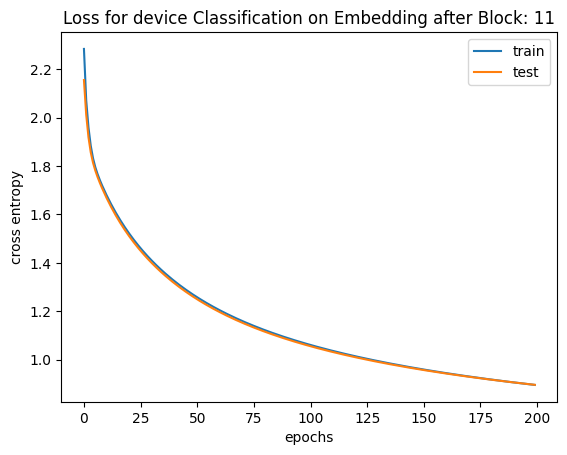

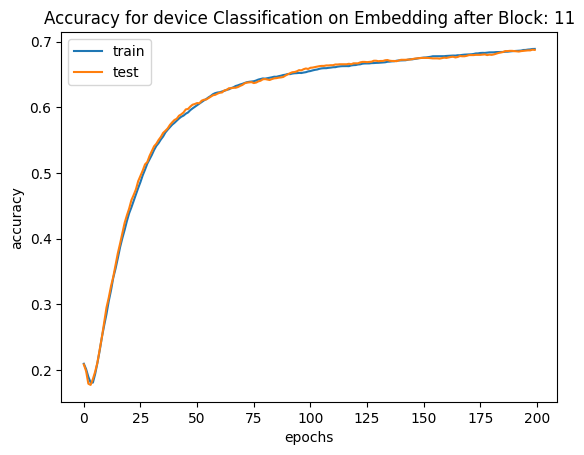

In [211]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [212]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [213]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')

In [214]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [215]:
X_test=train_ready(test_data,col_name)

In [216]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


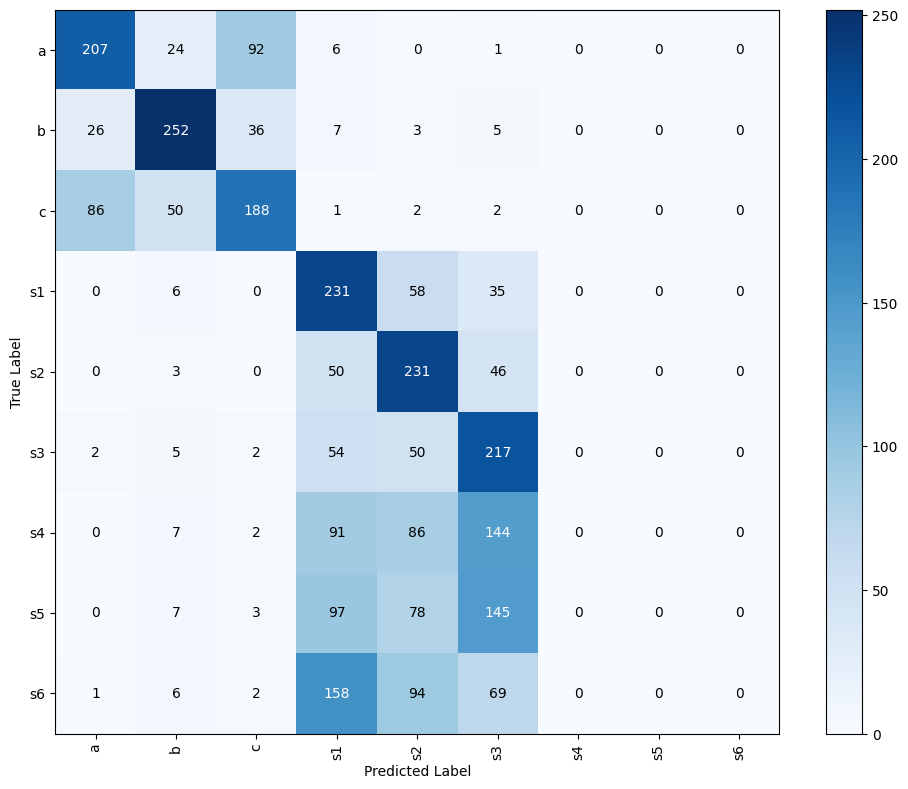

Accuracy: 0.4468


In [217]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-12

In [218]:
Block_number=12

In [219]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth',map_location=torch.device('cpu'))
new_fc3 = nn.Linear(256, 6)

# Replace the existing fc3 layer with the new one
model.fc3 = new_fc3

In [220]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [221]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [222]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [223]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 6)
(2793, 6)


In [224]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 198406
Number of parameters in the last layer is 1542


In [225]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [226]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [227]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1542


In [228]:
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(weights_array))
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 198406
Total number of paramerters being trained:  1542


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 308.73batch/s, acc=0.0703, loss=2.13]


Epoch 0 validation: Cross-entropy=2.08, Accuracy=7.4%


Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 579.54batch/s, acc=0.113, loss=2]    


Epoch 1 validation: Cross-entropy=2.00, Accuracy=11.4%


Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 250.97batch/s, acc=0.125, loss=1.94] 


Epoch 2 validation: Cross-entropy=1.94, Accuracy=12.3%


Epoch 3: 100%|██████████| 43/43 [00:00<00:00, 379.00batch/s, acc=0.125, loss=1.9]  


Epoch 3 validation: Cross-entropy=1.90, Accuracy=13.6%


Epoch 4: 100%|██████████| 43/43 [00:00<00:00, 509.93batch/s, acc=0.148, loss=1.86] 


Epoch 4 validation: Cross-entropy=1.87, Accuracy=14.7%


Epoch 5: 100%|██████████| 43/43 [00:00<00:00, 445.30batch/s, acc=0.176, loss=1.82] 


Epoch 5 validation: Cross-entropy=1.84, Accuracy=16.1%


Epoch 6: 100%|██████████| 43/43 [00:00<00:00, 463.48batch/s, acc=0.188, loss=1.79] 


Epoch 6 validation: Cross-entropy=1.81, Accuracy=17.4%


Epoch 7: 100%|██████████| 43/43 [00:00<00:00, 529.76batch/s, acc=0.188, loss=1.76]


Epoch 7 validation: Cross-entropy=1.79, Accuracy=18.5%


Epoch 8: 100%|██████████| 43/43 [00:00<00:00, 422.88batch/s, acc=0.203, loss=1.73]


Epoch 8 validation: Cross-entropy=1.77, Accuracy=20.2%


Epoch 9: 100%|██████████| 43/43 [00:00<00:00, 427.95batch/s, acc=0.219, loss=1.7] 


Epoch 9 validation: Cross-entropy=1.74, Accuracy=21.6%


Epoch 10: 100%|██████████| 43/43 [00:00<00:00, 358.22batch/s, acc=0.223, loss=1.68]


Epoch 10 validation: Cross-entropy=1.72, Accuracy=23.2%


Epoch 11: 100%|██████████| 43/43 [00:00<00:00, 329.25batch/s, acc=0.234, loss=1.65]


Epoch 11 validation: Cross-entropy=1.70, Accuracy=24.4%


Epoch 12: 100%|██████████| 43/43 [00:00<00:00, 555.71batch/s, acc=0.25, loss=1.63] 


Epoch 12 validation: Cross-entropy=1.68, Accuracy=25.8%


Epoch 13: 100%|██████████| 43/43 [00:00<00:00, 386.29batch/s, acc=0.27, loss=1.6]  


Epoch 13 validation: Cross-entropy=1.67, Accuracy=27.1%


Epoch 14: 100%|██████████| 43/43 [00:00<00:00, 546.38batch/s, acc=0.309, loss=1.58]


Epoch 14 validation: Cross-entropy=1.65, Accuracy=28.8%


Epoch 15: 100%|██████████| 43/43 [00:00<00:00, 379.04batch/s, acc=0.332, loss=1.56]


Epoch 15 validation: Cross-entropy=1.63, Accuracy=30.1%


Epoch 16: 100%|██████████| 43/43 [00:00<00:00, 521.73batch/s, acc=0.336, loss=1.54]


Epoch 16 validation: Cross-entropy=1.61, Accuracy=31.6%


Epoch 17: 100%|██████████| 43/43 [00:00<00:00, 276.37batch/s, acc=0.352, loss=1.52]


Epoch 17 validation: Cross-entropy=1.60, Accuracy=33.0%


Epoch 18: 100%|██████████| 43/43 [00:00<00:00, 564.05batch/s, acc=0.363, loss=1.5] 


Epoch 18 validation: Cross-entropy=1.58, Accuracy=34.4%


Epoch 19: 100%|██████████| 43/43 [00:00<00:00, 381.20batch/s, acc=0.379, loss=1.48]


Epoch 19 validation: Cross-entropy=1.57, Accuracy=35.7%


Epoch 20: 100%|██████████| 43/43 [00:00<00:00, 534.85batch/s, acc=0.398, loss=1.47]


Epoch 20 validation: Cross-entropy=1.55, Accuracy=36.9%


Epoch 21: 100%|██████████| 43/43 [00:00<00:00, 356.96batch/s, acc=0.398, loss=1.45]


Epoch 21 validation: Cross-entropy=1.54, Accuracy=38.5%


Epoch 22: 100%|██████████| 43/43 [00:00<00:00, 538.17batch/s, acc=0.418, loss=1.43]


Epoch 22 validation: Cross-entropy=1.52, Accuracy=39.5%


Epoch 23: 100%|██████████| 43/43 [00:00<00:00, 336.91batch/s, acc=0.426, loss=1.42]


Epoch 23 validation: Cross-entropy=1.51, Accuracy=40.7%


Epoch 24: 100%|██████████| 43/43 [00:00<00:00, 419.92batch/s, acc=0.438, loss=1.4] 


Epoch 24 validation: Cross-entropy=1.50, Accuracy=41.5%


Epoch 25: 100%|██████████| 43/43 [00:00<00:00, 370.02batch/s, acc=0.453, loss=1.39]


Epoch 25 validation: Cross-entropy=1.49, Accuracy=42.4%


Epoch 26: 100%|██████████| 43/43 [00:00<00:00, 613.92batch/s, acc=0.465, loss=1.37]


Epoch 26 validation: Cross-entropy=1.47, Accuracy=43.5%


Epoch 27: 100%|██████████| 43/43 [00:00<00:00, 365.62batch/s, acc=0.469, loss=1.36]


Epoch 27 validation: Cross-entropy=1.46, Accuracy=44.4%


Epoch 28: 100%|██████████| 43/43 [00:00<00:00, 583.14batch/s, acc=0.469, loss=1.35]


Epoch 28 validation: Cross-entropy=1.45, Accuracy=44.9%


Epoch 29: 100%|██████████| 43/43 [00:00<00:00, 352.98batch/s, acc=0.473, loss=1.33]


Epoch 29 validation: Cross-entropy=1.44, Accuracy=46.3%


Epoch 30: 100%|██████████| 43/43 [00:00<00:00, 610.95batch/s, acc=0.48, loss=1.32] 


Epoch 30 validation: Cross-entropy=1.43, Accuracy=47.0%


Epoch 31: 100%|██████████| 43/43 [00:00<00:00, 279.16batch/s, acc=0.484, loss=1.31]


Epoch 31 validation: Cross-entropy=1.42, Accuracy=47.5%


Epoch 32: 100%|██████████| 43/43 [00:00<00:00, 595.35batch/s, acc=0.488, loss=1.3] 


Epoch 32 validation: Cross-entropy=1.41, Accuracy=48.3%


Epoch 33: 100%|██████████| 43/43 [00:00<00:00, 357.54batch/s, acc=0.492, loss=1.29]


Epoch 33 validation: Cross-entropy=1.40, Accuracy=48.7%


Epoch 34: 100%|██████████| 43/43 [00:00<00:00, 611.89batch/s, acc=0.5, loss=1.28]  


Epoch 34 validation: Cross-entropy=1.39, Accuracy=48.9%


Epoch 35: 100%|██████████| 43/43 [00:00<00:00, 379.54batch/s, acc=0.504, loss=1.27]


Epoch 35 validation: Cross-entropy=1.38, Accuracy=49.2%


Epoch 36: 100%|██████████| 43/43 [00:00<00:00, 594.34batch/s, acc=0.508, loss=1.26]


Epoch 36 validation: Cross-entropy=1.37, Accuracy=49.8%


Epoch 37: 100%|██████████| 43/43 [00:00<00:00, 370.18batch/s, acc=0.516, loss=1.25]


Epoch 37 validation: Cross-entropy=1.36, Accuracy=50.2%


Epoch 38: 100%|██████████| 43/43 [00:00<00:00, 431.19batch/s, acc=0.523, loss=1.24]


Epoch 38 validation: Cross-entropy=1.36, Accuracy=50.9%


Epoch 39: 100%|██████████| 43/43 [00:00<00:00, 360.16batch/s, acc=0.527, loss=1.23]


Epoch 39 validation: Cross-entropy=1.35, Accuracy=51.4%


Epoch 40: 100%|██████████| 43/43 [00:00<00:00, 592.21batch/s, acc=0.539, loss=1.22]


Epoch 40 validation: Cross-entropy=1.34, Accuracy=51.6%


Epoch 41: 100%|██████████| 43/43 [00:00<00:00, 341.16batch/s, acc=0.539, loss=1.21]


Epoch 41 validation: Cross-entropy=1.33, Accuracy=51.9%


Epoch 42: 100%|██████████| 43/43 [00:00<00:00, 623.61batch/s, acc=0.547, loss=1.2] 


Epoch 42 validation: Cross-entropy=1.32, Accuracy=52.5%


Epoch 43: 100%|██████████| 43/43 [00:00<00:00, 368.56batch/s, acc=0.547, loss=1.19]


Epoch 43 validation: Cross-entropy=1.32, Accuracy=52.8%


Epoch 44: 100%|██████████| 43/43 [00:00<00:00, 620.12batch/s, acc=0.551, loss=1.18]


Epoch 44 validation: Cross-entropy=1.31, Accuracy=53.1%


Epoch 45: 100%|██████████| 43/43 [00:00<00:00, 328.13batch/s, acc=0.551, loss=1.18]


Epoch 45 validation: Cross-entropy=1.30, Accuracy=53.5%


Epoch 46: 100%|██████████| 43/43 [00:00<00:00, 481.64batch/s, acc=0.555, loss=1.17]


Epoch 46 validation: Cross-entropy=1.29, Accuracy=53.7%


Epoch 47: 100%|██████████| 43/43 [00:00<00:00, 361.73batch/s, acc=0.555, loss=1.16]


Epoch 47 validation: Cross-entropy=1.29, Accuracy=54.2%


Epoch 48: 100%|██████████| 43/43 [00:00<00:00, 614.96batch/s, acc=0.555, loss=1.15]


Epoch 48 validation: Cross-entropy=1.28, Accuracy=54.6%


Epoch 49: 100%|██████████| 43/43 [00:00<00:00, 366.78batch/s, acc=0.562, loss=1.15]


Epoch 49 validation: Cross-entropy=1.27, Accuracy=54.9%


Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 609.57batch/s, acc=0.562, loss=1.14]


Epoch 50 validation: Cross-entropy=1.27, Accuracy=55.1%


Epoch 51: 100%|██████████| 43/43 [00:00<00:00, 354.65batch/s, acc=0.566, loss=1.13]


Epoch 51 validation: Cross-entropy=1.26, Accuracy=55.4%


Epoch 52: 100%|██████████| 43/43 [00:00<00:00, 598.95batch/s, acc=0.566, loss=1.13]


Epoch 52 validation: Cross-entropy=1.26, Accuracy=55.6%


Epoch 53: 100%|██████████| 43/43 [00:00<00:00, 268.56batch/s, acc=0.57, loss=1.12] 


Epoch 53 validation: Cross-entropy=1.25, Accuracy=55.9%


Epoch 54: 100%|██████████| 43/43 [00:00<00:00, 585.39batch/s, acc=0.57, loss=1.11] 


Epoch 54 validation: Cross-entropy=1.24, Accuracy=56.2%


Epoch 55: 100%|██████████| 43/43 [00:00<00:00, 342.01batch/s, acc=0.566, loss=1.11]


Epoch 55 validation: Cross-entropy=1.24, Accuracy=56.6%


Epoch 56: 100%|██████████| 43/43 [00:00<00:00, 589.51batch/s, acc=0.574, loss=1.1] 


Epoch 56 validation: Cross-entropy=1.23, Accuracy=56.9%


Epoch 57: 100%|██████████| 43/43 [00:00<00:00, 351.20batch/s, acc=0.57, loss=1.1]  


Epoch 57 validation: Cross-entropy=1.23, Accuracy=57.0%


Epoch 58: 100%|██████████| 43/43 [00:00<00:00, 588.26batch/s, acc=0.57, loss=1.09] 


Epoch 58 validation: Cross-entropy=1.22, Accuracy=57.2%


Epoch 59: 100%|██████████| 43/43 [00:00<00:00, 369.60batch/s, acc=0.57, loss=1.08] 


Epoch 59 validation: Cross-entropy=1.22, Accuracy=57.4%


Epoch 60: 100%|██████████| 43/43 [00:00<00:00, 379.97batch/s, acc=0.566, loss=1.08]


Epoch 60 validation: Cross-entropy=1.21, Accuracy=57.5%


Epoch 61: 100%|██████████| 43/43 [00:00<00:00, 369.78batch/s, acc=0.566, loss=1.07]


Epoch 61 validation: Cross-entropy=1.21, Accuracy=57.8%


Epoch 62: 100%|██████████| 43/43 [00:00<00:00, 546.63batch/s, acc=0.566, loss=1.07]


Epoch 62 validation: Cross-entropy=1.20, Accuracy=58.1%


Epoch 63: 100%|██████████| 43/43 [00:00<00:00, 284.01batch/s, acc=0.566, loss=1.06]


Epoch 63 validation: Cross-entropy=1.20, Accuracy=58.3%


Epoch 64: 100%|██████████| 43/43 [00:00<00:00, 558.39batch/s, acc=0.578, loss=1.06]


Epoch 64 validation: Cross-entropy=1.19, Accuracy=58.4%


Epoch 65: 100%|██████████| 43/43 [00:00<00:00, 355.37batch/s, acc=0.582, loss=1.05]


Epoch 65 validation: Cross-entropy=1.19, Accuracy=58.5%


Epoch 66: 100%|██████████| 43/43 [00:00<00:00, 594.88batch/s, acc=0.582, loss=1.05]


Epoch 66 validation: Cross-entropy=1.18, Accuracy=58.8%


Epoch 67: 100%|██████████| 43/43 [00:00<00:00, 268.28batch/s, acc=0.594, loss=1.04]


Epoch 67 validation: Cross-entropy=1.18, Accuracy=59.0%


Epoch 68: 100%|██████████| 43/43 [00:00<00:00, 605.76batch/s, acc=0.598, loss=1.04]


Epoch 68 validation: Cross-entropy=1.18, Accuracy=59.2%


Epoch 69: 100%|██████████| 43/43 [00:00<00:00, 297.87batch/s, acc=0.602, loss=1.03]


Epoch 69 validation: Cross-entropy=1.17, Accuracy=59.4%


Epoch 70: 100%|██████████| 43/43 [00:00<00:00, 415.69batch/s, acc=0.605, loss=1.03]


Epoch 70 validation: Cross-entropy=1.17, Accuracy=59.4%


Epoch 71: 100%|██████████| 43/43 [00:00<00:00, 549.98batch/s, acc=0.609, loss=1.03]


Epoch 71 validation: Cross-entropy=1.16, Accuracy=59.3%


Epoch 72: 100%|██████████| 43/43 [00:00<00:00, 443.79batch/s, acc=0.609, loss=1.02]


Epoch 72 validation: Cross-entropy=1.16, Accuracy=59.3%


Epoch 73: 100%|██████████| 43/43 [00:00<00:00, 481.99batch/s, acc=0.617, loss=1.02]


Epoch 73 validation: Cross-entropy=1.15, Accuracy=59.5%


Epoch 74: 100%|██████████| 43/43 [00:00<00:00, 296.33batch/s, acc=0.621, loss=1.01]


Epoch 74 validation: Cross-entropy=1.15, Accuracy=59.7%


Epoch 75: 100%|██████████| 43/43 [00:00<00:00, 505.10batch/s, acc=0.621, loss=1.01]


Epoch 75 validation: Cross-entropy=1.15, Accuracy=59.7%


Epoch 76: 100%|██████████| 43/43 [00:00<00:00, 455.12batch/s, acc=0.621, loss=1]   


Epoch 76 validation: Cross-entropy=1.14, Accuracy=59.8%


Epoch 77: 100%|██████████| 43/43 [00:00<00:00, 486.95batch/s, acc=0.621, loss=1]   


Epoch 77 validation: Cross-entropy=1.14, Accuracy=59.8%


Epoch 78: 100%|██████████| 43/43 [00:00<00:00, 370.57batch/s, acc=0.621, loss=0.996]


Epoch 78 validation: Cross-entropy=1.14, Accuracy=60.1%


Epoch 79: 100%|██████████| 43/43 [00:00<00:00, 530.74batch/s, acc=0.617, loss=0.992]


Epoch 79 validation: Cross-entropy=1.13, Accuracy=60.1%


Epoch 80: 100%|██████████| 43/43 [00:00<00:00, 401.72batch/s, acc=0.617, loss=0.989]


Epoch 80 validation: Cross-entropy=1.13, Accuracy=60.2%


Epoch 81: 100%|██████████| 43/43 [00:00<00:00, 563.31batch/s, acc=0.617, loss=0.985]


Epoch 81 validation: Cross-entropy=1.13, Accuracy=60.3%


Epoch 82: 100%|██████████| 43/43 [00:00<00:00, 289.08batch/s, acc=0.617, loss=0.981]


Epoch 82 validation: Cross-entropy=1.12, Accuracy=60.4%


Epoch 83: 100%|██████████| 43/43 [00:00<00:00, 510.62batch/s, acc=0.621, loss=0.978]


Epoch 83 validation: Cross-entropy=1.12, Accuracy=60.6%


Epoch 84: 100%|██████████| 43/43 [00:00<00:00, 449.00batch/s, acc=0.621, loss=0.974]


Epoch 84 validation: Cross-entropy=1.12, Accuracy=60.7%


Epoch 85: 100%|██████████| 43/43 [00:00<00:00, 506.98batch/s, acc=0.621, loss=0.971]


Epoch 85 validation: Cross-entropy=1.11, Accuracy=60.9%


Epoch 86: 100%|██████████| 43/43 [00:00<00:00, 384.45batch/s, acc=0.625, loss=0.967]


Epoch 86 validation: Cross-entropy=1.11, Accuracy=61.0%


Epoch 87: 100%|██████████| 43/43 [00:00<00:00, 571.94batch/s, acc=0.629, loss=0.964]


Epoch 87 validation: Cross-entropy=1.11, Accuracy=61.0%


Epoch 88: 100%|██████████| 43/43 [00:00<00:00, 367.62batch/s, acc=0.633, loss=0.961]


Epoch 88 validation: Cross-entropy=1.10, Accuracy=61.1%


Epoch 89: 100%|██████████| 43/43 [00:00<00:00, 415.84batch/s, acc=0.633, loss=0.957]


Epoch 89 validation: Cross-entropy=1.10, Accuracy=61.3%


Epoch 90: 100%|██████████| 43/43 [00:00<00:00, 368.33batch/s, acc=0.629, loss=0.954]


Epoch 90 validation: Cross-entropy=1.10, Accuracy=61.4%


Epoch 91: 100%|██████████| 43/43 [00:00<00:00, 601.60batch/s, acc=0.629, loss=0.951]


Epoch 91 validation: Cross-entropy=1.09, Accuracy=61.5%


Epoch 92: 100%|██████████| 43/43 [00:00<00:00, 396.47batch/s, acc=0.629, loss=0.948]


Epoch 92 validation: Cross-entropy=1.09, Accuracy=61.6%


Epoch 93: 100%|██████████| 43/43 [00:00<00:00, 554.08batch/s, acc=0.633, loss=0.945]


Epoch 93 validation: Cross-entropy=1.09, Accuracy=61.7%


Epoch 94: 100%|██████████| 43/43 [00:00<00:00, 401.44batch/s, acc=0.637, loss=0.942]


Epoch 94 validation: Cross-entropy=1.08, Accuracy=61.7%


Epoch 95: 100%|██████████| 43/43 [00:00<00:00, 547.33batch/s, acc=0.637, loss=0.939]


Epoch 95 validation: Cross-entropy=1.08, Accuracy=61.8%


Epoch 96: 100%|██████████| 43/43 [00:00<00:00, 259.07batch/s, acc=0.637, loss=0.936]


Epoch 96 validation: Cross-entropy=1.08, Accuracy=61.9%


Epoch 97: 100%|██████████| 43/43 [00:00<00:00, 564.76batch/s, acc=0.637, loss=0.933]


Epoch 97 validation: Cross-entropy=1.08, Accuracy=61.9%


Epoch 98: 100%|██████████| 43/43 [00:00<00:00, 379.30batch/s, acc=0.637, loss=0.93] 


Epoch 98 validation: Cross-entropy=1.07, Accuracy=62.2%


Epoch 99: 100%|██████████| 43/43 [00:00<00:00, 584.76batch/s, acc=0.637, loss=0.927]


Epoch 99 validation: Cross-entropy=1.07, Accuracy=62.2%


Epoch 100: 100%|██████████| 43/43 [00:00<00:00, 376.37batch/s, acc=0.637, loss=0.924]


Epoch 100 validation: Cross-entropy=1.07, Accuracy=62.3%


Epoch 101: 100%|██████████| 43/43 [00:00<00:00, 525.23batch/s, acc=0.633, loss=0.922]


Epoch 101 validation: Cross-entropy=1.07, Accuracy=62.3%


Epoch 102: 100%|██████████| 43/43 [00:00<00:00, 302.84batch/s, acc=0.633, loss=0.919]


Epoch 102 validation: Cross-entropy=1.06, Accuracy=62.4%


Epoch 103: 100%|██████████| 43/43 [00:00<00:00, 403.62batch/s, acc=0.637, loss=0.916]


Epoch 103 validation: Cross-entropy=1.06, Accuracy=62.5%


Epoch 104: 100%|██████████| 43/43 [00:00<00:00, 369.78batch/s, acc=0.637, loss=0.914]


Epoch 104 validation: Cross-entropy=1.06, Accuracy=62.5%


Epoch 105: 100%|██████████| 43/43 [00:00<00:00, 615.03batch/s, acc=0.637, loss=0.911]


Epoch 105 validation: Cross-entropy=1.06, Accuracy=62.5%


Epoch 106: 100%|██████████| 43/43 [00:00<00:00, 356.32batch/s, acc=0.637, loss=0.908]


Epoch 106 validation: Cross-entropy=1.05, Accuracy=62.5%


Epoch 107: 100%|██████████| 43/43 [00:00<00:00, 591.14batch/s, acc=0.637, loss=0.906]


Epoch 107 validation: Cross-entropy=1.05, Accuracy=62.5%


Epoch 108: 100%|██████████| 43/43 [00:00<00:00, 355.68batch/s, acc=0.637, loss=0.903]


Epoch 108 validation: Cross-entropy=1.05, Accuracy=62.7%


Epoch 109: 100%|██████████| 43/43 [00:00<00:00, 624.26batch/s, acc=0.637, loss=0.901]


Epoch 109 validation: Cross-entropy=1.05, Accuracy=62.8%


Epoch 110: 100%|██████████| 43/43 [00:00<00:00, 276.76batch/s, acc=0.637, loss=0.899]


Epoch 110 validation: Cross-entropy=1.04, Accuracy=62.8%


Epoch 111: 100%|██████████| 43/43 [00:00<00:00, 587.22batch/s, acc=0.637, loss=0.896]


Epoch 111 validation: Cross-entropy=1.04, Accuracy=62.9%


Epoch 112: 100%|██████████| 43/43 [00:00<00:00, 352.34batch/s, acc=0.637, loss=0.894]


Epoch 112 validation: Cross-entropy=1.04, Accuracy=63.1%


Epoch 113: 100%|██████████| 43/43 [00:00<00:00, 604.70batch/s, acc=0.637, loss=0.891]


Epoch 113 validation: Cross-entropy=1.04, Accuracy=63.1%


Epoch 114: 100%|██████████| 43/43 [00:00<00:00, 349.35batch/s, acc=0.637, loss=0.889]


Epoch 114 validation: Cross-entropy=1.03, Accuracy=63.3%


Epoch 115: 100%|██████████| 43/43 [00:00<00:00, 607.73batch/s, acc=0.637, loss=0.887]


Epoch 115 validation: Cross-entropy=1.03, Accuracy=63.3%


Epoch 116: 100%|██████████| 43/43 [00:00<00:00, 365.72batch/s, acc=0.637, loss=0.885]


Epoch 116 validation: Cross-entropy=1.03, Accuracy=63.4%


Epoch 117: 100%|██████████| 43/43 [00:00<00:00, 576.45batch/s, acc=0.637, loss=0.882]


Epoch 117 validation: Cross-entropy=1.03, Accuracy=63.4%


Epoch 118: 100%|██████████| 43/43 [00:00<00:00, 216.28batch/s, acc=0.637, loss=0.88] 


Epoch 118 validation: Cross-entropy=1.03, Accuracy=63.5%


Epoch 119: 100%|██████████| 43/43 [00:00<00:00, 591.96batch/s, acc=0.637, loss=0.878]


Epoch 119 validation: Cross-entropy=1.02, Accuracy=63.5%


Epoch 120: 100%|██████████| 43/43 [00:00<00:00, 360.20batch/s, acc=0.637, loss=0.876]


Epoch 120 validation: Cross-entropy=1.02, Accuracy=63.7%


Epoch 121: 100%|██████████| 43/43 [00:00<00:00, 611.09batch/s, acc=0.641, loss=0.874]


Epoch 121 validation: Cross-entropy=1.02, Accuracy=63.7%


Epoch 122: 100%|██████████| 43/43 [00:00<00:00, 357.51batch/s, acc=0.641, loss=0.872]


Epoch 122 validation: Cross-entropy=1.02, Accuracy=63.8%


Epoch 123: 100%|██████████| 43/43 [00:00<00:00, 608.16batch/s, acc=0.645, loss=0.87] 


Epoch 123 validation: Cross-entropy=1.02, Accuracy=63.8%


Epoch 124: 100%|██████████| 43/43 [00:00<00:00, 376.87batch/s, acc=0.645, loss=0.867]


Epoch 124 validation: Cross-entropy=1.01, Accuracy=63.8%


Epoch 125: 100%|██████████| 43/43 [00:00<00:00, 403.71batch/s, acc=0.641, loss=0.865]


Epoch 125 validation: Cross-entropy=1.01, Accuracy=63.9%


Epoch 126: 100%|██████████| 43/43 [00:00<00:00, 361.13batch/s, acc=0.641, loss=0.863]


Epoch 126 validation: Cross-entropy=1.01, Accuracy=63.8%


Epoch 127: 100%|██████████| 43/43 [00:00<00:00, 603.29batch/s, acc=0.641, loss=0.861]


Epoch 127 validation: Cross-entropy=1.01, Accuracy=63.9%


Epoch 128: 100%|██████████| 43/43 [00:00<00:00, 369.95batch/s, acc=0.641, loss=0.86] 


Epoch 128 validation: Cross-entropy=1.01, Accuracy=64.0%


Epoch 129: 100%|██████████| 43/43 [00:00<00:00, 600.65batch/s, acc=0.637, loss=0.858]


Epoch 129 validation: Cross-entropy=1.00, Accuracy=64.0%


Epoch 130: 100%|██████████| 43/43 [00:00<00:00, 362.06batch/s, acc=0.637, loss=0.856]


Epoch 130 validation: Cross-entropy=1.00, Accuracy=64.1%


Epoch 131: 100%|██████████| 43/43 [00:00<00:00, 379.12batch/s, acc=0.637, loss=0.854]


Epoch 131 validation: Cross-entropy=1.00, Accuracy=64.0%


Epoch 132: 100%|██████████| 43/43 [00:00<00:00, 315.84batch/s, acc=0.645, loss=0.852]


Epoch 132 validation: Cross-entropy=1.00, Accuracy=64.1%


Epoch 133: 100%|██████████| 43/43 [00:00<00:00, 605.77batch/s, acc=0.645, loss=0.85] 


Epoch 133 validation: Cross-entropy=1.00, Accuracy=64.3%


Epoch 134: 100%|██████████| 43/43 [00:00<00:00, 376.03batch/s, acc=0.645, loss=0.848]


Epoch 134 validation: Cross-entropy=0.99, Accuracy=64.3%


Epoch 135: 100%|██████████| 43/43 [00:00<00:00, 418.98batch/s, acc=0.645, loss=0.846]


Epoch 135 validation: Cross-entropy=0.99, Accuracy=64.5%


Epoch 136: 100%|██████████| 43/43 [00:00<00:00, 511.39batch/s, acc=0.645, loss=0.845]


Epoch 136 validation: Cross-entropy=0.99, Accuracy=64.6%


Epoch 137: 100%|██████████| 43/43 [00:00<00:00, 585.75batch/s, acc=0.645, loss=0.843]


Epoch 137 validation: Cross-entropy=0.99, Accuracy=64.5%


Epoch 138: 100%|██████████| 43/43 [00:00<00:00, 404.27batch/s, acc=0.645, loss=0.841]


Epoch 138 validation: Cross-entropy=0.99, Accuracy=64.5%


Epoch 139: 100%|██████████| 43/43 [00:00<00:00, 433.07batch/s, acc=0.645, loss=0.839]


Epoch 139 validation: Cross-entropy=0.99, Accuracy=64.4%


Epoch 140: 100%|██████████| 43/43 [00:00<00:00, 411.05batch/s, acc=0.645, loss=0.838]


Epoch 140 validation: Cross-entropy=0.98, Accuracy=64.5%


Epoch 141: 100%|██████████| 43/43 [00:00<00:00, 370.56batch/s, acc=0.645, loss=0.836]


Epoch 141 validation: Cross-entropy=0.98, Accuracy=64.6%


Epoch 142: 100%|██████████| 43/43 [00:00<00:00, 555.85batch/s, acc=0.641, loss=0.834]


Epoch 142 validation: Cross-entropy=0.98, Accuracy=64.7%


Epoch 143: 100%|██████████| 43/43 [00:00<00:00, 358.11batch/s, acc=0.645, loss=0.833]


Epoch 143 validation: Cross-entropy=0.98, Accuracy=64.7%


Epoch 144: 100%|██████████| 43/43 [00:00<00:00, 577.96batch/s, acc=0.645, loss=0.831]


Epoch 144 validation: Cross-entropy=0.98, Accuracy=64.7%


Epoch 145: 100%|██████████| 43/43 [00:00<00:00, 368.33batch/s, acc=0.648, loss=0.829]


Epoch 145 validation: Cross-entropy=0.98, Accuracy=64.7%


Epoch 146: 100%|██████████| 43/43 [00:00<00:00, 562.12batch/s, acc=0.645, loss=0.828]


Epoch 146 validation: Cross-entropy=0.97, Accuracy=64.7%


Epoch 147: 100%|██████████| 43/43 [00:00<00:00, 300.04batch/s, acc=0.645, loss=0.826]


Epoch 147 validation: Cross-entropy=0.97, Accuracy=64.9%


Epoch 148: 100%|██████████| 43/43 [00:00<00:00, 529.61batch/s, acc=0.645, loss=0.824]


Epoch 148 validation: Cross-entropy=0.97, Accuracy=64.9%


Epoch 149: 100%|██████████| 43/43 [00:00<00:00, 404.39batch/s, acc=0.645, loss=0.823]


Epoch 149 validation: Cross-entropy=0.97, Accuracy=64.9%


Epoch 150: 100%|██████████| 43/43 [00:00<00:00, 571.10batch/s, acc=0.645, loss=0.821]


Epoch 150 validation: Cross-entropy=0.97, Accuracy=65.0%


Epoch 151: 100%|██████████| 43/43 [00:00<00:00, 345.91batch/s, acc=0.648, loss=0.82] 


Epoch 151 validation: Cross-entropy=0.97, Accuracy=65.0%


Epoch 152: 100%|██████████| 43/43 [00:00<00:00, 612.38batch/s, acc=0.648, loss=0.818]


Epoch 152 validation: Cross-entropy=0.97, Accuracy=65.0%


Epoch 153: 100%|██████████| 43/43 [00:00<00:00, 358.68batch/s, acc=0.648, loss=0.817]


Epoch 153 validation: Cross-entropy=0.96, Accuracy=65.1%


Epoch 154: 100%|██████████| 43/43 [00:00<00:00, 400.77batch/s, acc=0.648, loss=0.815]


Epoch 154 validation: Cross-entropy=0.96, Accuracy=65.1%


Epoch 155: 100%|██████████| 43/43 [00:00<00:00, 349.50batch/s, acc=0.648, loss=0.814]


Epoch 155 validation: Cross-entropy=0.96, Accuracy=65.1%


Epoch 156: 100%|██████████| 43/43 [00:00<00:00, 591.27batch/s, acc=0.648, loss=0.812]


Epoch 156 validation: Cross-entropy=0.96, Accuracy=65.2%


Epoch 157: 100%|██████████| 43/43 [00:00<00:00, 347.96batch/s, acc=0.648, loss=0.811]


Epoch 157 validation: Cross-entropy=0.96, Accuracy=65.2%


Epoch 158: 100%|██████████| 43/43 [00:00<00:00, 541.97batch/s, acc=0.645, loss=0.809]


Epoch 158 validation: Cross-entropy=0.96, Accuracy=65.2%


Epoch 159: 100%|██████████| 43/43 [00:00<00:00, 345.40batch/s, acc=0.645, loss=0.808]


Epoch 159 validation: Cross-entropy=0.96, Accuracy=65.3%


Epoch 160: 100%|██████████| 43/43 [00:00<00:00, 376.73batch/s, acc=0.648, loss=0.807]


Epoch 160 validation: Cross-entropy=0.95, Accuracy=65.5%


Epoch 161: 100%|██████████| 43/43 [00:00<00:00, 412.75batch/s, acc=0.645, loss=0.805]


Epoch 161 validation: Cross-entropy=0.95, Accuracy=65.7%


Epoch 162: 100%|██████████| 43/43 [00:00<00:00, 370.73batch/s, acc=0.645, loss=0.804]


Epoch 162 validation: Cross-entropy=0.95, Accuracy=65.8%


Epoch 163: 100%|██████████| 43/43 [00:00<00:00, 509.09batch/s, acc=0.645, loss=0.802]


Epoch 163 validation: Cross-entropy=0.95, Accuracy=65.8%


Epoch 164: 100%|██████████| 43/43 [00:00<00:00, 368.10batch/s, acc=0.645, loss=0.801]


Epoch 164 validation: Cross-entropy=0.95, Accuracy=65.8%


Epoch 165: 100%|██████████| 43/43 [00:00<00:00, 583.85batch/s, acc=0.645, loss=0.8]  


Epoch 165 validation: Cross-entropy=0.95, Accuracy=65.8%


Epoch 166: 100%|██████████| 43/43 [00:00<00:00, 389.46batch/s, acc=0.648, loss=0.798]


Epoch 166 validation: Cross-entropy=0.95, Accuracy=65.8%


Epoch 167: 100%|██████████| 43/43 [00:00<00:00, 594.01batch/s, acc=0.648, loss=0.797]


Epoch 167 validation: Cross-entropy=0.94, Accuracy=65.8%


Epoch 168: 100%|██████████| 43/43 [00:00<00:00, 350.13batch/s, acc=0.648, loss=0.796]


Epoch 168 validation: Cross-entropy=0.94, Accuracy=65.7%


Epoch 169: 100%|██████████| 43/43 [00:00<00:00, 393.36batch/s, acc=0.648, loss=0.794]


Epoch 169 validation: Cross-entropy=0.94, Accuracy=65.8%


Epoch 170: 100%|██████████| 43/43 [00:00<00:00, 358.88batch/s, acc=0.648, loss=0.793]


Epoch 170 validation: Cross-entropy=0.94, Accuracy=65.8%


Epoch 171: 100%|██████████| 43/43 [00:00<00:00, 597.83batch/s, acc=0.648, loss=0.792]


Epoch 171 validation: Cross-entropy=0.94, Accuracy=65.8%


Epoch 172: 100%|██████████| 43/43 [00:00<00:00, 368.65batch/s, acc=0.648, loss=0.79] 


Epoch 172 validation: Cross-entropy=0.94, Accuracy=65.8%


Epoch 173: 100%|██████████| 43/43 [00:00<00:00, 567.79batch/s, acc=0.648, loss=0.789]


Epoch 173 validation: Cross-entropy=0.94, Accuracy=65.9%


Epoch 174: 100%|██████████| 43/43 [00:00<00:00, 373.81batch/s, acc=0.648, loss=0.788]


Epoch 174 validation: Cross-entropy=0.94, Accuracy=66.0%


Epoch 175: 100%|██████████| 43/43 [00:00<00:00, 597.32batch/s, acc=0.652, loss=0.787]


Epoch 175 validation: Cross-entropy=0.93, Accuracy=66.0%


Epoch 176: 100%|██████████| 43/43 [00:00<00:00, 274.71batch/s, acc=0.652, loss=0.785]


Epoch 176 validation: Cross-entropy=0.93, Accuracy=66.0%


Epoch 177: 100%|██████████| 43/43 [00:00<00:00, 576.39batch/s, acc=0.652, loss=0.784]


Epoch 177 validation: Cross-entropy=0.93, Accuracy=66.0%


Epoch 178: 100%|██████████| 43/43 [00:00<00:00, 339.34batch/s, acc=0.656, loss=0.783]


Epoch 178 validation: Cross-entropy=0.93, Accuracy=66.1%


Epoch 179: 100%|██████████| 43/43 [00:00<00:00, 603.52batch/s, acc=0.656, loss=0.782]


Epoch 179 validation: Cross-entropy=0.93, Accuracy=66.1%


Epoch 180: 100%|██████████| 43/43 [00:00<00:00, 373.12batch/s, acc=0.652, loss=0.781]


Epoch 180 validation: Cross-entropy=0.93, Accuracy=66.1%


Epoch 181: 100%|██████████| 43/43 [00:00<00:00, 599.67batch/s, acc=0.652, loss=0.779]


Epoch 181 validation: Cross-entropy=0.93, Accuracy=66.1%


Epoch 182: 100%|██████████| 43/43 [00:00<00:00, 367.98batch/s, acc=0.652, loss=0.778]


Epoch 182 validation: Cross-entropy=0.93, Accuracy=66.1%


Epoch 183: 100%|██████████| 43/43 [00:00<00:00, 431.17batch/s, acc=0.652, loss=0.777]


Epoch 183 validation: Cross-entropy=0.92, Accuracy=66.1%


Epoch 184: 100%|██████████| 43/43 [00:00<00:00, 326.42batch/s, acc=0.652, loss=0.776]


Epoch 184 validation: Cross-entropy=0.92, Accuracy=66.2%


Epoch 185: 100%|██████████| 43/43 [00:00<00:00, 605.23batch/s, acc=0.652, loss=0.775]


Epoch 185 validation: Cross-entropy=0.92, Accuracy=66.4%


Epoch 186: 100%|██████████| 43/43 [00:00<00:00, 350.85batch/s, acc=0.656, loss=0.774]


Epoch 186 validation: Cross-entropy=0.92, Accuracy=66.4%


Epoch 187: 100%|██████████| 43/43 [00:00<00:00, 599.05batch/s, acc=0.656, loss=0.773]


Epoch 187 validation: Cross-entropy=0.92, Accuracy=66.5%


Epoch 188: 100%|██████████| 43/43 [00:00<00:00, 360.21batch/s, acc=0.66, loss=0.771] 


Epoch 188 validation: Cross-entropy=0.92, Accuracy=66.5%


Epoch 189: 100%|██████████| 43/43 [00:00<00:00, 588.93batch/s, acc=0.66, loss=0.77]  


Epoch 189 validation: Cross-entropy=0.92, Accuracy=66.5%


Epoch 190: 100%|██████████| 43/43 [00:00<00:00, 347.76batch/s, acc=0.656, loss=0.769]


Epoch 190 validation: Cross-entropy=0.92, Accuracy=66.5%


Epoch 191: 100%|██████████| 43/43 [00:00<00:00, 392.27batch/s, acc=0.656, loss=0.768]


Epoch 191 validation: Cross-entropy=0.92, Accuracy=66.5%


Epoch 192: 100%|██████████| 43/43 [00:00<00:00, 363.19batch/s, acc=0.656, loss=0.767]


Epoch 192 validation: Cross-entropy=0.91, Accuracy=66.5%


Epoch 193: 100%|██████████| 43/43 [00:00<00:00, 610.56batch/s, acc=0.656, loss=0.766]


Epoch 193 validation: Cross-entropy=0.91, Accuracy=66.5%


Epoch 194: 100%|██████████| 43/43 [00:00<00:00, 360.25batch/s, acc=0.656, loss=0.765]


Epoch 194 validation: Cross-entropy=0.91, Accuracy=66.5%


Epoch 195: 100%|██████████| 43/43 [00:00<00:00, 591.20batch/s, acc=0.656, loss=0.764]


Epoch 195 validation: Cross-entropy=0.91, Accuracy=66.5%


Epoch 196: 100%|██████████| 43/43 [00:00<00:00, 334.05batch/s, acc=0.66, loss=0.763] 


Epoch 196 validation: Cross-entropy=0.91, Accuracy=66.5%


Epoch 197: 100%|██████████| 43/43 [00:00<00:00, 610.74batch/s, acc=0.66, loss=0.762] 


Epoch 197 validation: Cross-entropy=0.91, Accuracy=66.6%


Epoch 198: 100%|██████████| 43/43 [00:00<00:00, 279.54batch/s, acc=0.66, loss=0.761] 


Epoch 198 validation: Cross-entropy=0.91, Accuracy=66.7%


Epoch 199: 100%|██████████| 43/43 [00:00<00:00, 430.59batch/s, acc=0.66, loss=0.76]  


Epoch 199 validation: Cross-entropy=0.91, Accuracy=66.7%


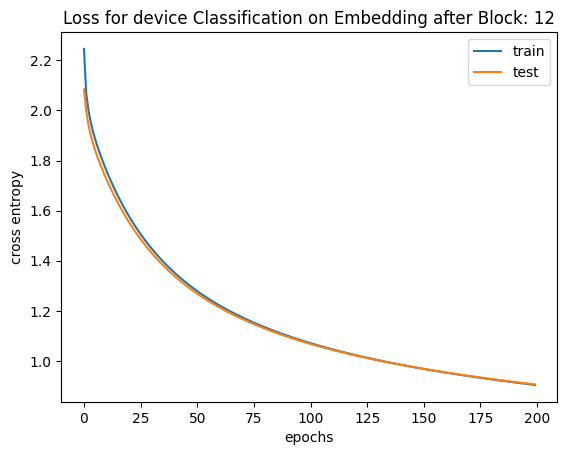

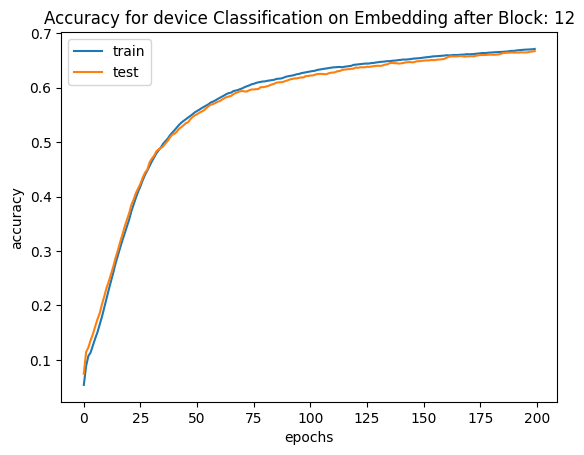

In [229]:
n_epochs = 200
batch_size = b_s
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            labels = np.argmax(y_batch, axis=1)
            loss = criterion(y_pred, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if acc > best_acc:
        best_acc = acc

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)
list_val_acc.append(best_acc)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [230]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [231]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')


In [232]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}_scene_0.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
)

In [233]:
X_test=train_ready(test_data,col_name)

In [234]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


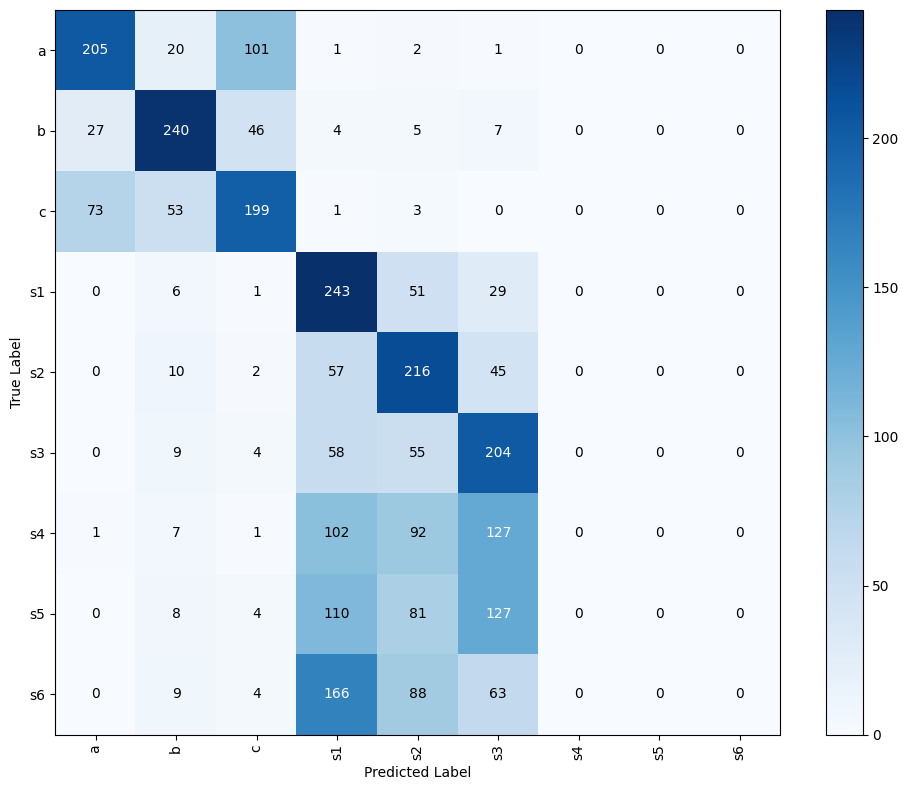

Accuracy: 0.4404


In [235]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

In [236]:
df.to_csv(fr'{run_mode}_predictions.csv')

# Accuracy Plots of Block-by-Block

In [237]:
acc_list


[0.33524258760107817,
 0.3948787061994609,
 0.3884770889487871,
 0.4326145552560647,
 0.4272237196765499,
 0.4454177897574124,
 0.45956873315363883,
 0.433288409703504,
 0.4686657681940701,
 0.46293800539083557,
 0.4467654986522911,
 0.44036388140161725]

In [238]:
list_val_acc

[0.5420694351196289,
 0.5621196031570435,
 0.563193678855896,
 0.6484067440032959,
 0.6133190393447876,
 0.6623702049255371,
 0.7013963460922241,
 0.7042606472969055,
 0.7103472948074341,
 0.7064088582992554,
 0.6877909302711487,
 0.6673827171325684]

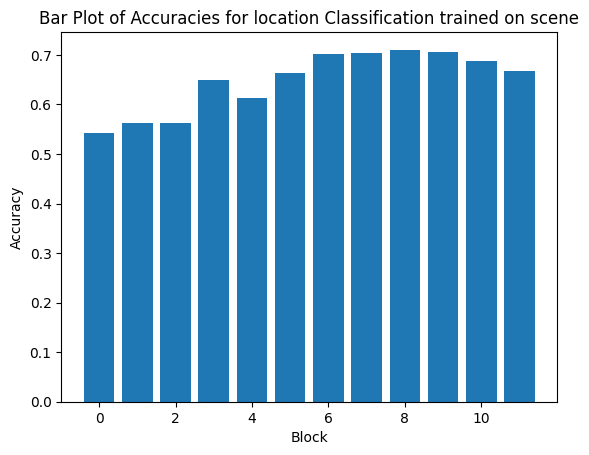

In [239]:
import matplotlib.pyplot as plt

# Example list of numbers
numbers = list_val_acc

# Create the plot
plt.bar(range(len(numbers)), numbers)

# Add labels and title
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Accuracies for location Classification trained on scene')

# Display the plot
plt.show()
